## import library
- http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/
- http://learningtensorflow.com/index.html
- http://suriyadeepan.github.io/2016-12-31-practical-seq2seq/

In [221]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
import pprint
pp = pprint.PrettyPrinter(indent=4)
sess = tf.InteractiveSession()

C:\Users\user\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# 0. Tensorflow basic

- **tf.constant(), tf.Variable()**: 그래프의 객체
- **tf.Session()/ tf.InteractiveSession()**: 그래프를 시작
- **sess.run(c)**: 텐서 'c'를 계산 -> sess.close() 해야함
- **with 절**: tf.Session()은 with 절과 사용, with 절에서 sess.close() 생략가능
- **c.eval()**: sess.run(c)와 같음

### - **tf.variable_scope()**
- 모델에서 필요한 변수들을 관리하는 클래스(변수 범위 만들기)
- tf.get_variable(): 직접호출 없이 변수를 가져오거나 생성(initializer 사용)
- reuse = False: '현재 variable scope 이름 + 제공된 name'이 없으면 생성
- reuse = True: '현재 variable scope 이름 + 제공된 name'이 있으면 반환
- reuse = AUTO_REUSE: 둘다

# 1. Create RNN Cell

In [222]:
#one-hot encoding for each char in 'hello'
h = [1, 0, 0, 0]
e = [0, 1, 0, 0]
l = [0, 0, 1, 0]
o = [0, 0, 0, 1]

![image](https://cloud.githubusercontent.com/assets/901975/23348727/cc981856-fce7-11e6-83ea-4b187473466b.png)


### Create Cell
- tf.variable_scope('one_cell')이라는 객체 -> scope
- cell 정의: 출력의 크기 = hidden_size
- cell 구동: cell, 입력 data 넘겨주면 -> output, 마지막 state를 리턴
- 연산은 graph로 표현: graph는 session 내에서 실행

In [223]:
with tf.variable_scope('one_cell', reuse=tf.AUTO_REUSE) as scope:
    # One cell RNN input_dim (4) -> output_dim (2)
    
    hidden_size = 2
    cell = tf.keras.layers.SimpleRNNCell(units=hidden_size)
    # cell 정의: 출력의 크기 = hidden_size
    print(cell.output_size, cell.state_size)

    x_data = np.array([[h]], dtype=np.float32) # x_data = [[[1,0,0,0]]]
    pp.pprint(x_data)
    outputs, _states = tf.nn.dynamic_rnn(cell, x_data, dtype=tf.float32)
    # cell 구동: cell, 입력 data 넘겨주면 -> output, 마지막 state를 리턴

    sess.run(tf.global_variables_initializer())
    # 연산 실행 전 initialize 수행
    pp.pprint(outputs.eval())
    # output: random한 weignt와 연산되어서 나온 값(dim=2)

2 2
array([[[1., 0., 0., 0.]]], dtype=float32)
array([[[-0.7222932 , -0.66547453]]], dtype=float32)


![image](https://cloud.githubusercontent.com/assets/901975/23383634/649efd0a-fd82-11e6-925d-8041242743b0.png)

### Input data = [h,e,l,l,o]

In [224]:
with tf.variable_scope('two_sequances', reuse=tf.AUTO_REUSE) as scope:
    # One cell RNN input_dim (4) -> output_dim (2). sequence: 5
    hidden_size = 2
    cell = tf.keras.layers.SimpleRNNCell(units=hidden_size)
    # 셀 생성
    
    x_data = np.array([[h, e, l, l, o]], dtype=np.float32)
    print(x_data.shape)  
    pp.pprint(x_data)
    # input data(1,5,4): sequence_length = 5
    
    outputs, _states = tf.nn.dynamic_rnn(cell, x_data, dtype=tf.float32)
    # 셀 구동
    
    sess.run(tf.global_variables_initializer())
    # initialize
    pp.pprint(outputs.eval())
    # output data(1,5,2) 연산

(1, 5, 4)
array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]], dtype=float32)
array([[[-0.05333436,  0.04476343],
        [ 0.18493548,  0.33910292],
        [-0.6018327 , -0.5577788 ],
        [-0.47069603,  0.4997868 ],
        [-0.45652887, -0.256991  ]]], dtype=float32)


![image](https://cloud.githubusercontent.com/assets/901975/23383681/9943a9fc-fd82-11e6-8121-bd187994e249.png)

### Multiple sequences (문자열 여러 개)
- batch size = 3

In [227]:
with tf.variable_scope('3_batches', reuse=tf.AUTO_REUSE) as scope:
    # One cell RNN input_dim (4) -> output_dim (2). sequence: 5
    hidden_size = 2
    cell = tf.keras.layers.SimpleRNNCell(units=hidden_size)
    # 셀 생성
    
    x_data = np.array([[h, e, l, l, o],
                       [e, o, l, l, l],
                       [l, l, e, e, l]], dtype=np.float32)
    print(x_data.shape)  
    pp.pprint(x_data)
    # input data(3,5,4): sequence_length = 5
    
    outputs, _states = tf.nn.dynamic_rnn(cell, x_data, dtype=tf.float32)
    # 셀 구동
    
    sess.run(tf.global_variables_initializer())
    # initialize
    pp.pprint(outputs.eval())
    print(outputs)
    # output data(3,5,2)


(3, 5, 4)
array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]]], dtype=float32)
array([[[-0.23214158, -0.34446883],
        [-0.20883243, -0.11361437],
        [ 0.7603682 , -0.07143668],
        [ 0.04450443, -0.24991965],
        [ 0.5719381 ,  0.75261325]],

       [[-0.37230787, -0.45332623],
        [ 0.7750683 ,  0.84581274],
        [ 0.16295896, -0.82260656],
        [ 0.48185742,  0.51923215],
        [ 0.38558698, -0.66336495]],

       [[ 0.6680213 , -0.21131997],
        [ 0.11487292, -0.1030528 ],
        [-0.47757316, -0.38317412],
        [ 0.02515319, -0.03982811],
        [ 0.6506601 , -0.17695844]]], dtype=float32)
Tensor("3_batches/

### Using LSTMCell (RNNCell 대신)

In [229]:
with tf.variable_scope('3_batches_dynamic_length', reuse=tf.AUTO_REUSE) as scope:
    # One cell RNN input_dim (4) -> output_dim (5). sequence: 5, batch 3
    # 3 batches 'hello', 'eolll', 'lleel'
    x_data = np.array([[h, e, l, l, o],
                       [e, o, l, l, l],
                       [l, l, e, e, l]], dtype=np.float32)
    pp.pprint(x_data)
    
    hidden_size = 2
    cell = tf.nn.rnn_cell.LSTMCell(num_units=hidden_size, state_is_tuple=True)
    outputs, _states = tf.nn.dynamic_rnn(
        cell, x_data, sequence_length=[5,3,4], dtype=tf.float32)
    sess.run(tf.global_variables_initializer())
    pp.pprint(outputs.eval())

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.]]], dtype=float32)
array([[[ 0.09944302, -0.0439918 ],
        [ 0.20460467,  0.01923851],
        [ 0.10933731, -0.09381735],
        [ 0.09634162, -0.16490276],
        [-0.0195423 , -0.1446609 ]],

       [[ 0.11585934,  0.07305477],
        [-0.04375046,  0.00809151],
        [-0.02351889, -0.05223451],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.00821466, -0.06998002],
        [ 0.0193393 , -0.12730166],
        [ 0.14276637, -0.02120978],
        [ 0.1998821 ,  0.03963428],
        [ 0.        ,  0.        ]]], dtype=float32)


## Cost: sequence_loss
- logits : 예측
- targets : 정답

In [124]:
# [batch_size, sequence_length]
y_data = tf.constant([[1, 1, 1]])  # 정답

# [batch_size, sequence_length, emb_dim ]
prediction = tf.constant([[[0.2, 0.7], [0.6, 0.2], [0.2, 0.9]]], dtype=tf.float32)
# -> one-hot: [1, 0, 1]

# [batch_size * sequence_length]
weights = tf.constant([[1, 1, 1]], dtype=tf.float32)

sequence_loss = tf.contrib.seq2seq.sequence_loss(logits=prediction, targets=y_data, weights=weights)
sess.run(tf.global_variables_initializer())
print("Loss: ", sequence_loss.eval())

Loss:  0.5967595


In [230]:
# [batch_size, sequence_length]
y_data = tf.constant([[1, 1, 1]])

# [batch_size, sequence_length, emb_dim ]
prediction1 = tf.constant([[[0.3, 0.7], [0.3, 0.7], [0.3, 0.7]]], dtype=tf.float32)
# -> one-hot: [1, 1, 1]
prediction2 = tf.constant([[[0.1, 0.9], [0.1, 0.9], [0.1, 0.9]]], dtype=tf.float32)
# -> one-hot: [1, 1, 1] (하지만 정답에 더 가까움: loss작음)

prediction3 = tf.constant([[[1, 0], [1, 0], [1, 0]]], dtype=tf.float32)
# -> one-hot: [0, 0, 0] 모두 오답
prediction4 = tf.constant([[[0, 1], [0, 1], [0, 1]]], dtype=tf.float32)
# -> one-hot: [1, 1, 1] 모두 정답

# [batch_size * sequence_length]
weights = tf.constant([[1, 1, 1]], dtype=tf.float32)

sequence_loss1 = tf.contrib.seq2seq.sequence_loss(prediction1, y_data, weights)
sequence_loss2 = tf.contrib.seq2seq.sequence_loss(prediction2, y_data, weights)
sequence_loss3 = tf.contrib.seq2seq.sequence_loss(prediction3, y_data, weights)
sequence_loss4 = tf.contrib.seq2seq.sequence_loss(prediction4, y_data, weights)

sess.run(tf.global_variables_initializer())
print("Loss1: ", sequence_loss1.eval())
print("Loss2: ", sequence_loss2.eval())
print("Loss3: ", sequence_loss3.eval())
print("Loss4: ", sequence_loss4.eval())

Loss1:  0.5130153
Loss2:  0.3711007
Loss3:  1.3132616
Loss4:  0.31326166


# 2. RNN Training

In [68]:
tf.set_random_seed(777)  # reproducibility

idx2char = ['h', 'i', 'e', 'l', 'o']
# Teach hello: hihell -> ihello

### Initialize (input_data, output_data, parameters)

In [136]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

x_data = [[0, 1, 0, 2, 3, 3]]   # hihell
x_one_hot = [[[1, 0, 0, 0, 0],   # h 0
              [0, 1, 0, 0, 0],   # i 1
              [1, 0, 0, 0, 0],   # h 0
              [0, 0, 1, 0, 0],   # e 2
              [0, 0, 0, 1, 0],   # l 3
              [0, 0, 0, 1, 0]]]  # l 3

y_data = [[1, 0, 2, 3, 3, 4]]    # ihello

num_classes = 5
input_dim = 5  # one-hot size
hidden_size = 5  # output from the LSTM. 5 to directly predict one-hot
batch_size = 1   # one sentence
sequence_length = 6  # |ihello| == 6
learning_rate = 0.1

X = tf.placeholder(
    tf.float32, [None, sequence_length, input_dim])  # X one-hot
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label
# None자리: batch size -> 1이라서 생략
print(X)
print(Y)

Tensor("Placeholder:0", shape=(?, 6, 5), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 6), dtype=int32)


### Create Cell

In [137]:
# LSTM cell 사용
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)
initial_state = cell.zero_state(batch_size, tf.float32)
outputs, _states = tf.nn.dynamic_rnn(
    cell, X, initial_state=initial_state, dtype=tf.float32)

# RNN cell 사용
#x_data2 = np.array([[x_one_hot[0][0],x_one_hot[0][1],x_one_hot[0][2],x_one_hot[0][3],
#                   x_one_hot[0][4],x_one_hot[0][5]]], dtype=np.float32)
#print(x_data2.shape)
#cell = tf.keras.layers.SimpleRNNCell(units=hidden_size)
#outputs, _states = tf.nn.dynamic_rnn(cell, x_data2, dtype=tf.float32)

### Train RNN (initialization)

In [139]:
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(
    logits=outputs, targets=Y, weights=weights)
loss = tf.reduce_mean(sequence_loss)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
# 학습을 위한 그래프 setting 완료

### Training

In [140]:
prediction = tf.argmax(outputs, axis=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50):
        l, _ = sess.run([loss, train], feed_dict={X: x_one_hot, Y: y_data})
        result = sess.run(prediction, feed_dict={X: x_one_hot})
        print(i, "loss:", l, "prediction: ", result, "true Y: ", y_data)

        # print char using dic
        result_str = [idx2char[c] for c in np.squeeze(result)]
        print("\tPrediction str: ", ''.join(result_str))

0 loss: 1.6061102 prediction:  [[2 2 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  eeelll
1 loss: 1.5172483 prediction:  [[3 2 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  leelll
2 loss: 1.4458308 prediction:  [[3 3 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llelll
3 loss: 1.3757234 prediction:  [[2 3 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  elelll
4 loss: 1.3051718 prediction:  [[2 3 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  elelll
5 loss: 1.241162 prediction:  [[2 2 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  eeelll
6 loss: 1.1981349 prediction:  [[2 2 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  eeelll
7 loss: 1.1576614 prediction:  [[2 2 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  eeelll
8 loss: 1.1198928 prediction:  [[2 2 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  eeelll
9 loss: 1.0877069 prediction:  [[2 2 2 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Predi

# 3. Long Sequence RNN(automatic)

In [212]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

sample = "Hello my name is hyejin"
idx2char = list(set(sample))  # index -> char
# 중복 제거
char2idx = {c: i for i, c in enumerate(idx2char)}  # char -> idex
# character별 숫자 딕셔너리
print(idx2char)
print(char2idx)

['H', ' ', 'h', 'e', 'm', 'y', 'o', 'a', 'i', 'j', 'l', 'n', 's']
{'H': 0, ' ': 1, 'h': 2, 'e': 3, 'm': 4, 'y': 5, 'o': 6, 'a': 7, 'i': 8, 'j': 9, 'l': 10, 'n': 11, 's': 12}


### Set parameters

In [213]:
# hyper parameters
dic_size = len(char2idx)  # RNN input size (one hot size)
rnn_hidden_size = len(char2idx)  # RNN output size
num_classes = len(char2idx)  # final output size (RNN or softmax, etc.)

batch_size = 1  # one sample data, one batch
sequence_length = len(sample) - 1  # number of lstm rollings (unit #)
learning_rate = 0.1
print(dic_size, rnn_hidden_size, num_classes)
print(sequence_length)

13 13 13
22


### One-hot encoding

In [214]:
sample_idx = [char2idx[c] for c in sample]  # char to index
x_data = [sample_idx[:-1]]  # X data sample (0 ~ n-1) hello: hell
y_data = [sample_idx[1:]]   # Y label sample (1 ~ n) hello: ello

X = tf.placeholder(tf.int32, [None, sequence_length])  # X data
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label
                            #batch_size = 1

# flatten the data (ignore batches for now). No effect if the batch size is 1
x_one_hot = tf.one_hot(X, num_classes)  # one hot: 1 -> 0 1 0 0 0 0 0 0 0 0
print(X)
print(Y)
print(X_one_hot)

Tensor("Placeholder:0", shape=(?, 22), dtype=int32)
Tensor("Placeholder_1:0", shape=(?, 22), dtype=int32)
Tensor("one_hot_6:0", shape=(?, 15, 10), dtype=float32)


C:\Users\user\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Create cell

In [215]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_hidden_size, state_is_tuple=True)
initial_state = cell.zero_state(batch_size, tf.float32)
outputs, _states = tf.nn.dynamic_rnn(cell, x_one_hot, initial_state=initial_state, dtype=tf.float32)

### Train RNN

In [216]:
# reshape out for sequence_loss
print(outputs.shape)
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])
print(outputs.shape)

weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(logits=outputs, targets=Y, weights=weights)
loss = tf.reduce_mean(sequence_loss)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
prediction = tf.argmax(outputs, axis=2)

(1, 22, 13)
(1, 22, 13)


In [217]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50):
        l, _ = sess.run([loss, train], feed_dict={X: x_data, Y: y_data})
        result = sess.run(prediction, feed_dict={X: x_data})

        # print char using dic
        result_str = [idx2char[c] for c in np.squeeze(result)]

        print(i, "loss:", l, "Prediction:", ''.join(result_str))

0 loss: 2.575422 Prediction: e   l eeeeeeehhhhheenn
1 loss: 2.4515016 Prediction: e     eeeeeeehhhhyhhhh
2 loss: 2.3242366 Prediction: e         mm        nn
3 loss: 2.2703338 Prediction: e  o            nnnnnn
4 loss: 2.182235 Prediction: e ooooooommm  s yynnnn
5 loss: 2.1380637 Prediction: e oo mmmmmmm iiiiynnnn
6 loss: 2.0464647 Prediction: e ommmmmmmmmmmmmiiiiii
7 loss: 2.1022942 Prediction: e    my iiinninninnnin
8 loss: 2.1552591 Prediction: elo  my inne innnnniin
9 loss: 2.0199387 Prediction: ello my nmmm inniyniin
10 loss: 1.9002366 Prediction: ello my nmmm innhyeiin
11 loss: 1.8524112 Prediction: ello my nmmm isnhyennn
12 loss: 1.8225601 Prediction: ello my nmmm ishhyennn
13 loss: 1.7886847 Prediction: ello my nmmm sshhyenin
14 loss: 1.7432549 Prediction: ello my nmmm sshhyeiin
15 loss: 1.7079978 Prediction: ello my nmme ss hyeiin
16 loss: 1.6697178 Prediction: ello my nmme is hyejin
17 loss: 1.6274269 Prediction: ello my nmme is hyejin
18 loss: 1.5950619 Prediction: ello my n

# 4. Stacked RNN + Softmax Layer
- sentence가 길 때, 학습이 잘 되지 않는 현상
- depth를 더 깊게(Deep Learning) + Softmax(=Fully Connected) Layer 사용
- Rnn output sequence를 Softmax function에 넣어줌
- Softmax = Logistic function(Wx + b) -> classification(각 선택지가 정답일 확률)
- (Softmax의 output) - (One-hot 벡터) = 오차

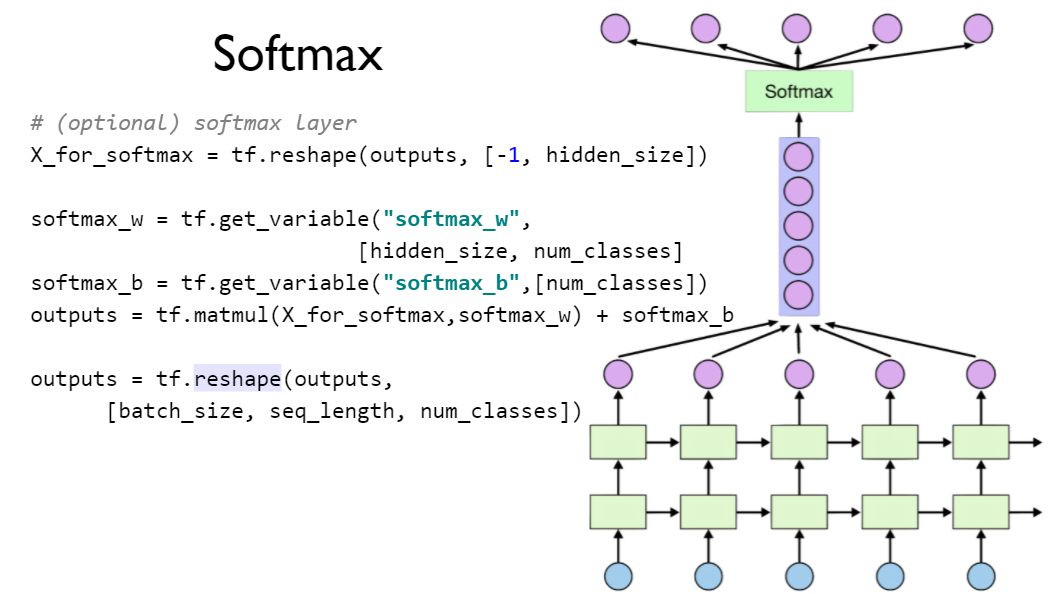

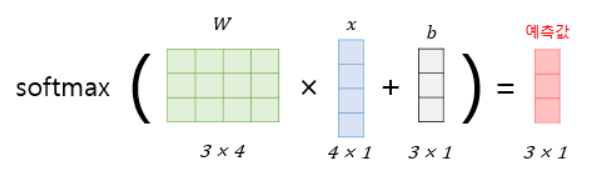

### Initialize

In [284]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

char_set = list(set(sentence))
char_dic = {w: i for i, w in enumerate(char_set)}

data_dim = len(char_set)
hidden_size = len(char_set)
num_classes = len(char_set)
sequence_length = 10  # Any arbitrary number
learning_rate = 0.1

C:\Users\user\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### One-hot encoding

In [285]:
dataX = []
dataY = []
for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
    print(i, x_str, '->', y_str)

    x = [char_dic[c] for c in x_str]  # x str to index
    y = [char_dic[c] for c in y_str]  # y str to index

    dataX.append(x)
    dataY.append(y)

batch_size = len(dataX)

X = tf.placeholder(tf.int32, [None, sequence_length])
Y = tf.placeholder(tf.int32, [None, sequence_length])

# One-hot encoding
X_one_hot = tf.one_hot(X, num_classes)
print(X_one_hot)  # check out the shape

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

### Create cell

In [286]:
def lstm_cell():
    cell = rnn.BasicLSTMCell(hidden_size, state_is_tuple=True)
    return cell

                              # cell() * 2 
multi_cells = rnn.MultiRNNCell([lstm_cell() for _ in range(2)], state_is_tuple=True)

In [287]:
# outputs: unfolding size x hidden size, state = hidden size
outputs, _states = tf.nn.dynamic_rnn(multi_cells, X_one_hot, dtype=tf.float32)

### Fully connected layer

In [288]:
# reshape output for FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])

# FC layer(softmax)
outputs = tf.contrib.layers.fully_connected(X_for_fc, num_classes, activation_fn=None)

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

### Train RNN

In [289]:
# All weights are 1 (equal weights)
weights = tf.ones([batch_size, sequence_length])

sequence_loss = tf.contrib.seq2seq.sequence_loss(logits=outputs, targets=Y, weights=weights)
mean_loss = tf.reduce_mean(sequence_loss)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mean_loss)

In [291]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(500):
    _, l, results = sess.run([train_op, mean_loss, outputs], feed_dict={X: dataX, Y: dataY})
    for j, result in enumerate(results):
        index = np.argmax(result, axis=1)
        print("*",i, j, ''.join([char_set[t] for t in index]), l)

# Let's print the last char of each result to check it works
results = sess.run(outputs, feed_dict={X: dataX})
for j, result in enumerate(results):
    index = np.argmax(result, axis=1)
    if j is 0:  # print all for the first result to make a sentence
        print(''.join([char_set[t] for t in index]), end='')
    else:
        print(char_set[index[-1]], end='')

* 0 0 mmmmgggggd 3.2203205
* 0 1 iiiggggiid 3.2203205
* 0 2 bggggggddi 3.2203205
* 0 3 ggggggddii 3.2203205
* 0 4 lgbidddiyl 3.2203205
* 0 5 fbidddyyyi 3.2203205
* 0 6 biddyyyyih 3.2203205
* 0 7 dduyyyymmh 3.2203205
* 0 8 uuyyyymhhg 3.2203205
* 0 9 mmmmmmgggg 3.2203205
* 0 10 mmmmgggggg 3.2203205
* 0 11 bbbbgggggg 3.2203205
* 0 12 mmmgggggg. 3.2203205
* 0 13 lbbbbb...h 3.2203205
* 0 14 bhhhs,,,,, 3.2203205
* 0 15 ssnss,,,,, 3.2203205
* 0 16 ffffg.hh,w 3.2203205
* 0 17 m''g..,,,, 3.2203205
* 0 18 'ygyhh,,,s 3.2203205
* 0 19 gg.hh,,,ss 3.2203205
* 0 20 bppppppspp 3.2203205
* 0 21 upppposmmm 3.2203205
* 0 22 bppp'mmmmm 3.2203205
* 0 23 cooommmmmm 3.2203205
* 0 24 oonmmmmmmm 3.2203205
* 0 25 mmmmmmmmmm 3.2203205
* 0 26 mmmmm.mmmy 3.2203205
* 0 27 iiii.iliy. 3.2203205
* 0 28 bgg.llllll 3.2203205
* 0 29 g..llmy..g 3.2203205
* 0 30 lmmmmmmggg 3.2203205
* 0 31 mmmmmygggg 3.2203205
* 0 32   mggggggg 3.2203205
* 0 33 mmgggggggl 3.2203205
* 0 34 bg.lggwlll 3.2203205
* 0 35 g..wwwwlll 3.2203205
* 

* 3 69 t    tttee 2.8998818
* 3 70     ttttee 2.8998818
* 3 71 t  tttttee 2.8998818
* 3 72 t     ttet 2.8998818
* 3 73          t 2.8998818
* 3 74 t       tt 2.8998818
* 3 75         tt 2.8998818
* 3 76        tte 2.8998818
* 3 77        tte 2.8998818
* 3 78 t     ttee 2.8998818
* 3 79      tttee 2.8998818
* 3 80 t   ttteee 2.8998818
* 3 81       ttee 2.8998818
* 3 82        eee 2.8998818
* 3 83        eee 2.8998818
* 3 84 t        e 2.8998818
* 3 85          e 2.8998818
* 3 86         ee 2.8998818
* 3 87       teee 2.8998818
* 3 88      teeee 2.8998818
* 3 89 t   tteeee 2.8998818
* 3 90      tteee 2.8998818
* 3 91 t    teeee 2.8998818
* 3 92     tteeee 2.8998818
* 3 93      teeee 2.8998818
* 3 94       eeee 2.8998818
* 3 95         ee 2.8998818
* 3 96 t      eee 2.8998818
* 3 97         ee 2.8998818
* 3 98            2.8998818
* 3 99            2.8998818
* 3 100         ee 2.8998818
* 3 101          e 2.8998818
* 3 102 t      ttt 2.8998818
* 3 103        tte 2.8998818
* 3 104       tt

* 6 161 tttttttttt 2.9140122
* 6 162 tttttttttt 2.9140122
* 6 163 tttttttttt 2.9140122
* 6 164 tttttttttt 2.9140122
* 6 165 tttttttttt 2.9140122
* 6 166 tttttttttt 2.9140122
* 6 167 tttttttttt 2.9140122
* 6 168 tttttttttt 2.9140122
* 6 169 tttttttttt 2.9140122
* 7 0 tttttttttt 2.8920586
* 7 1 tttttttttt 2.8920586
* 7 2 tttttttttt 2.8920586
* 7 3 tttttttttt 2.8920586
* 7 4 tttttttttt 2.8920586
* 7 5 tttttttttt 2.8920586
* 7 6 tttttttttt 2.8920586
* 7 7 tttttttttt 2.8920586
* 7 8 tttttttttt 2.8920586
* 7 9 tttttttttt 2.8920586
* 7 10 tttttttttt 2.8920586
* 7 11 tttttttttt 2.8920586
* 7 12 tttttttttt 2.8920586
* 7 13 tttttttttt 2.8920586
* 7 14 tttttttttt 2.8920586
* 7 15 tttttttttt 2.8920586
* 7 16 tttttttttt 2.8920586
* 7 17 tttttttttt 2.8920586
* 7 18 tttttttttt 2.8920586
* 7 19 tttttttttt 2.8920586
* 7 20 tttttttttt 2.8920586
* 7 21 tttttttttt 2.8920586
* 7 22 tttttttttt 2.8920586
* 7 23 tttttttttt 2.8920586
* 7 24 tttttttttt 2.8920586
* 7 25 tttttttttt 2.8920586
* 7 26 tttttttttt 2.8

* 9 124 tttttooott 2.7997415
* 9 125 t  tooot   2.7997415
* 9 126 tttooottoo 2.7997415
* 9 127 ttootttooo 2.7997415
* 9 128 ttotttoooo 2.7997415
* 9 129 tttttooooo 2.7997415
* 9 130 ttttoooooo 2.7997415
* 9 131 ttt ooo    2.7997415
* 9 132 tt ooooo   2.7997415
* 9 133 ttoooooooo 2.7997415
* 9 134 tttooooooo 2.7997415
* 9 135 ttooootooo 2.7997415
* 9 136 tttootoooo 2.7997415
* 9 137 tttttooooo 2.7997415
* 9 138 ttttoooooo 2.7997415
* 9 139 tttoootoot 2.7997415
* 9 140 tttootoott 2.7997415
* 9 141 tttttootto 2.7997415
* 9 142 ttttoottoo 2.7997415
* 9 143 ttttottooo 2.7997415
* 9 144 tttottoooo 2.7997415
* 9 145 tttttoooo  2.7997415
* 9 146 ttttooo    2.7997415
* 9 147 ttttott    2.7997415
* 9 148 ttttt      2.7997415
* 9 149 tttt       2.7997415
* 9 150 ttt        2.7997415
* 9 151 tt         2.7997415
* 9 152 tt         2.7997415
* 9 153 t          2.7997415
* 9 154 tt         2.7997415
* 9 155 t          2.7997415
* 9 156            2.7997415
* 9 157            2.7997415
* 9 158 tt    

* 12 107 o          2.6564193
* 12 108 tt         2.6564193
* 12 109 e          2.6564193
* 12 110            2.6564193
* 12 111 tt         2.6564193
* 12 112 eo         2.6564193
* 12 113 t          2.6564193
* 12 114 teee       2.6564193
* 12 115 eee        2.6564193
* 12 116 ee         2.6564193
* 12 117 e          2.6564193
* 12 118            2.6564193
* 12 119 ee   e     2.6564193
* 12 120 e          2.6564193
* 12 121    e       2.6564193
* 12 122 eee        2.6564193
* 12 123 ee         2.6564193
* 12 124 e          2.6564193
* 12 125            2.6564193
* 12 126            2.6564193
* 12 127 eeeee      2.6564193
* 12 128 eeee       2.6564193
* 12 129 eee        2.6564193
* 12 130 ee         2.6564193
* 12 131 e          2.6564193
* 12 132            2.6564193
* 12 133            2.6564193
* 12 134 eee        2.6564193
* 12 135 eto        2.6564193
* 12 136 tt         2.6564193
* 12 137 e          2.6564193
* 12 138 t          2.6564193
* 12 139 t          2.6564193
* 12 140  

* 14 49 oeeeeeeeee 2.504821
* 14 50 ete eeeeee 2.504821
* 14 51 tt  e  eee 2.504821
* 14 52 e eeeeeeee 2.504821
* 14 53   e   eeee 2.504821
* 14 54 eeeeeeeeee 2.504821
* 14 55 e   eeeeee 2.504821
* 14 56    ee eeee 2.504821
* 14 57 eeeeoeeeee 2.504821
* 14 58 oeeoeoeeee 2.504821
* 14 59 etoooeeeee 2.504821
* 14 60 too  eeeee 2.504821
* 14 61 oooeeeeeeo 2.504821
* 14 62 etee eeeoo 2.504821
* 14 63 t     eoo  2.504821
* 14 64 t   eeoo   2.504821
* 14 65 t  eeoo    2.504821
* 14 66  teeo      2.504821
* 14 67 eeeoo      2.504821
* 14 68 eeo        2.504821
* 14 69 oo         2.504821
* 14 70 o          2.504821
* 14 71 t          2.504821
* 14 72 t          2.504821
* 14 73    s       2.504821
* 14 74 o s        2.504821
* 14 75  s         2.504821
* 14 76            2.504821
* 14 77            2.504821
* 14 78 o        s 2.504821
* 14 79         s  2.504821
* 14 80 t      s   2.504821
* 14 81       s    2.504821
* 14 82      s     2.504821
* 14 83 ee  s    o 2.504821
* 14 84 o ss    o  2

* 17 0   ooo ua s 2.2115293
* 17 1  ooo ua s  2.2115293
* 17 2 ooo ua s o 2.2115293
* 17 3 oo ua s oo 2.2115293
* 17 4    a s oo  2.2115293
* 17 5   o s oo u 2.2115293
* 17 6 oo s oo uu 2.2115293
* 17 7 o s oo uu  2.2115293
* 17 8  s oo uu   2.2115293
* 17 9   oo uo    2.2115293
* 17 10 oooeuo   a 2.2115293
* 17 11 ooeou   ao 2.2115293
* 17 12 o uu   ao  2.2115293
* 17 13  ou   ao   2.2115293
* 17 14 ou   ao    2.2115293
* 17 15 o    o     2.2115293
* 17 16     o      2.2115293
* 17 17    o  i    2.2115293
* 17 18 e o  i     2.2115293
* 17 19 oo  i      2.2115293
* 17 20 o        o 2.2115293
* 17 21         ot 2.2115293
* 17 22 o      ot  2.2115293
* 17 23       ot   2.2115293
* 17 24 e    o     2.2115293
* 17 25  ht o    o 2.2115293
* 17 26 ee o    oo 2.2115293
* 17 27  oo    ooo 2.2115293
* 17 28 oo    ooo  2.2115293
* 17 29 o    ooo   2.2115293
* 17 30     ooo    2.2115293
* 17 31    ooo     2.2115293
* 17 32   oo       2.2115293
* 17 33 oooo     e 2.2115293
* 17 34 ooo     ee 2.211

* 20 20 os      do 1.8440307
* 20 21 s      dod 1.8440307
* 20 22 oni   dod  1.8440307
* 20 23 ii    od   1.8440307
* 20 24 e   dod    1.8440307
* 20 25    lor   o 1.8440307
* 20 26 eelor   oo 1.8440307
* 20 27  uor   oou 1.8440307
* 20 28 oon   ooun 1.8440307
* 20 29 on   oornu 1.8440307
* 20 30     oornuu 1.8440307
* 20 31    oorn up 1.8440307
* 20 32   ooanuupp 1.8440307
* 20 33 oooapuuppp 1.8440307
* 20 34 ooapuupppe 1.8440307
* 20 35 oap upppee 1.8440307
* 20 36    upppeel 1.8440307
* 20 37   upppeell 1.8440307
* 20 38  op peelle 1.8440307
* 20 39 op eelllee 1.8440307
* 20 40   eeellee  1.8440307
* 20 41 eeeelleelo 1.8440307
* 20 42 oee  e  ol 1.8440307
* 20 43 ee  ee ole 1.8440307
* 20 44    e  ot   1.8440307
* 20 45  oee o     1.8440307
* 20 46 eee o    e 1.8440307
* 20 47 e to    e  1.8440307
* 20 48   o   oe   1.8440307
* 20 49 ooe   e  t 1.8440307
* 20 50 o   oe  to 1.8440307
* 20 51     e  tot 1.8440307
* 20 52 e  e  totl 1.8440307
* 20 53   e  to lo 1.8440307
* 20 54 oe  to

* 23 0   aoo dans 1.4761481
* 23 1  ooo lans  1.4761481
* 23 2 oor lans t 1.4761481
* 23 3 tf lans to 1.4761481
* 23 4   dans to  1.4761481
* 23 5   ans to b 1.4761481
* 23 6 oons to bu 1.4761481
* 23 7 ons to bui 1.4761481
* 23 8 s  to buil 1.4761481
* 23 9  hoo buil  1.4761481
* 23 10 hoo buil   1.4761481
* 23 11 oo buil  a 1.4761481
* 23 12 h buil  an 1.4761481
* 23 13  luil  ans 1.4761481
* 23 14 ouil  ansi 1.4761481
* 23 15 u d  ansii 1.4761481
* 23 16  d  ansiim 1.4761481
* 23 17    ansiim  1.4761481
* 23 18 e onsiim,  1.4761481
* 23 19 oonsiim  d 1.4761481
* 23 20 os iim  do 1.4761481
* 23 21 s iim  don 1.4761481
* 23 22 oaim  don' 1.4761481
* 23 23 iim, don't 1.4761481
* 23 24 et  don't  1.4761481
* 23 25    don't d 1.4761481
* 23 26 e lon't dr 1.4761481
* 23 27 tdan't rru 1.4761481
* 23 28 oon't aaum 1.4761481
* 23 29 on't drum  1.4761481
* 23 30  dt aaup u 1.4761481
* 23 31  t aaup up 1.4761481
* 23 32 t taup upa 1.4761481
* 23 33 hooup upap 1.4761481
* 23 34 ooupuupape 1.476

* 25 169    oes hns 1.2713996
* 26 0 g aortlan  1.1705338
* 26 1  ood lan   1.1705338
* 26 2 oor lan  t 1.1705338
* 26 3 tf lan  to 1.1705338
* 26 4   lan  to  1.1705338
* 26 5 plan  to b 1.1705338
* 26 6 oond to bu 1.1705338
* 26 7 on  to bui 1.1705338
* 26 8 s  to buil 1.1705338
* 26 9 d to buil  1.1705338
* 26 10 hoo buil   1.1705338
* 26 11 oo buil  a 1.1705338
* 26 12 h buil  an 1.1705338
* 26 13  lutl  ans 1.1705338
* 26 14 outl  ansi 1.1705338
* 26 15 utl  ansii 1.1705338
* 26 16 pd  ansiig 1.1705338
* 26 17 g  ansiig, 1.1705338
* 26 18 e onsiig,  1.1705338
* 26 19 oonsiig, d 1.1705338
* 26 20 os iig, do 1.1705338
* 26 21 s iig, don 1.1705338
* 26 22 oaim, don' 1.1705338
* 26 23 iig, don't 1.1705338
* 26 24 eg  don't  1.1705338
* 26 25 g  don't d 1.1705338
* 26 26 e don't dr 1.1705338
* 26 27 tbon't dru 1.1705338
* 26 28 oon't arum 1.1705338
* 26 29 on't drum  1.1705338
* 26 30  dt drum u 1.1705338
* 26 31 dt arum up 1.1705338
* 26 32 t arum up  1.1705338
* 26 33 hooum up p 1.17

* 27 159 g  nsigy w 1.0653764
* 27 160   nsity wf 1.0653764
* 27 161  sssgy of  1.0653764
* 27 162    gy of t 1.0653764
* 27 163 d gy tu th 1.0653764
* 27 164 igy ou the 1.0653764
* 27 165 gy ou the  1.0653764
* 27 166 h wf the   1.0653764
* 27 167 tou the  h 1.0653764
* 27 168 tu the  hn 1.0653764
* 27 169    he  hns 1.0653764
* 28 0 g aortland 0.98175216
* 28 1  oor land  0.98175216
* 28 2 tof land t 0.98175216
* 28 3 tftland to 0.98175216
* 28 4  gland to  0.98175216
* 28 5 pland to b 0.98175216
* 28 6 tond to bu 0.98175216
* 28 7 ond to bui 0.98175216
* 28 8 sd to buil 0.98175216
* 28 9 d th buil  0.98175216
* 28 10 hro tuil   0.98175216
* 28 11 th buil  a 0.98175216
* 28 12 h build an 0.98175216
* 28 13  luild ans 0.98175216
* 28 14 tutl  ansi 0.98175216
* 28 15 utl  ansii 0.98175216
* 28 16 pl  ansiip 0.98175216
* 28 17 g  ansiip, 0.98175216
* 28 18 e onsiip,  0.98175216
* 28 19  onsiip, d 0.98175216
* 28 20 tssiip, do 0.98175216
* 28 21 s iip, don 0.98175216
* 28 22 taip, don' 0

* 29 100 d and work 0.9037299
* 29 101 iand work  0.9037299
* 29 102 tsd work   0.9037299
* 29 103 sd work  b 0.9037299
* 29 104 d work  bu 0.9037299
* 29 105  oork' but 0.9037299
* 29 106 tork  but  0.9037299
* 29 107 ork' but r 0.9037299
* 29 108     but ra 0.9037299
* 29 109  s but rat 0.9037299
* 29 110 d but rath 0.9037299
* 29 111 tdut rathe 0.9037299
* 29 112 tut rathe  0.9037299
* 29 113 ut rathe   0.9037299
* 29 114 p aathe  t 0.9037299
* 29 115 hrashe  to 0.9037299
* 29 116 tathe  toa 0.9037299
* 29 117  she  thas 0.9037299
* 29 118 she  toash 0.9037299
* 29 119 he  toash  0.9037299
* 29 120 es teash t 0.9037299
* 29 121   thash th 0.9037299
* 29 122  thash the 0.9037299
* 29 123 thash the  0.9037299
* 29 124 h sh the   0.9037299
* 29 125  sh the  t 0.9037299
* 29 126 sh the  to 0.9037299
* 29 127 letoem to  0.9037299
* 29 128 ethem to l 0.9037299
* 29 129 the  to lo 0.9037299
* 29 130 he  to lon 0.9037299
* 29 131 es to lond 0.9037299
* 29 132   to lond  0.9037299
* 29 133  

* 32 142 tor the en 0.7095124
* 32 143  r the ent 0.7095124
* 32 144   the endl 0.7095124
* 32 145  tee endle 0.7095124
* 32 146 toe endles 0.7095124
* 32 147 he  sdless 0.7095124
* 32 148 e  ndless  0.7095124
* 32 149  tndlessii 0.7095124
* 32 150 tndless im 0.7095124
* 32 151  dless imm 0.7095124
* 32 152 d essiimme 0.7095124
* 32 153   ssiimmen 0.7095124
* 32 154 e siimmens 0.7095124
* 32 155  siimmensi 0.7095124
* 32 156 iiimmensit 0.7095124
* 32 157 iammensity 0.7095124
* 32 158 tnmensity  0.7095124
* 32 159 g,ensity o 0.7095124
* 32 160   nsity of 0.7095124
* 32 161  nsity of  0.7095124
* 32 162  d ty of t 0.7095124
* 32 163 digy of th 0.7095124
* 32 164 igy of the 0.7095124
* 32 165 gy of the  0.7095124
* 32 166 h wf the e 0.7095124
* 32 167 tof the ee 0.7095124
* 32 168 tu the een 0.7095124
* 32 169   ahe eens 0.7095124
* 33 0 g yoftlant 0.65865844
* 33 1  aort ant  0.65865844
* 33 2 tofg ant t 0.65865844
* 33 3 oftlant to 0.65865844
* 33 4  tlant ta  0.65865844
* 33 5 plans ta

* 36 69 tood and d 0.5272063
* 36 70 ood and do 0.5272063
* 36 71 rg and don 0.5272063
* 36 72 r and don' 0.5272063
* 36 73  and don't 0.5272063
* 36 74 tnd won't  0.5272063
* 36 75 sd won't a 0.5272063
* 36 76 d won't as 0.5272063
* 36 77  aon't ass 0.5272063
* 36 78 ton't assi 0.5272063
* 36 79  n't assig 0.5272063
* 36 80 r't dssign 0.5272063
* 36 81 dt assign  0.5272063
* 36 82 t assign t 0.5272063
* 36 83 hrssign th 0.5272063
* 36 84 tnsign the 0.5272063
* 36 85 ssign them 0.5272063
* 36 86 sign them  0.5272063
* 36 87 stn them t 0.5272063
* 36 88 g  them ta 0.5272063
* 36 89 etthem tas 0.5272063
* 36 90 dthem tass 0.5272063
* 36 91 toem tasss 0.5272063
* 36 92 her tasss  0.5272063
* 36 93 em tosss a 0.5272063
* 36 94   tasss an 0.5272063
* 36 95  tosss and 0.5272063
* 36 96 tosss and  0.5272063
* 36 97 hsss and d 0.5272063
* 36 98 sss and wo 0.5272063
* 36 99 ss and wor 0.5272063
* 36 100 d and dork 0.5272063
* 36 101 sind dork, 0.5272063
* 36 102 tnd work,  0.5272063
* 36 103 sd

* 39 133 eta long f 0.4391651
* 39 134 to bong fo 0.4391651
* 39 135 h bong for 0.4391651
* 39 136 rlong for  0.4391651
* 39 137 tong for t 0.4391651
* 39 138 epg for th 0.4391651
* 39 139 r' for the 0.4391651
* 39 140 d for the  0.4391651
* 39 141 etor the e 0.4391651
* 39 142 tor the en 0.4391651
* 39 143  r the end 0.4391651
* 39 144 r the endl 0.4391651
* 39 145  the endle 0.4391651
* 39 146 toem ndles 0.4391651
* 39 147 herendless 0.4391651
* 39 148 emendless  0.4391651
* 39 149  tndless i 0.4391651
* 39 150 tndless im 0.4391651
* 39 151  dless imm 0.4391651
* 39 152 d ess imme 0.4391651
* 39 153  ess immen 0.4391651
* 39 154 e s immens 0.4391651
* 39 155  siimmensi 0.4391651
* 39 156 siimmensit 0.4391651
* 39 157 simmensity 0.4391651
* 39 158 tnmensity  0.4391651
* 39 159 gmensity o 0.4391651
* 39 160 eensity of 0.4391651
* 39 161 ensity of  0.4391651
* 39 162  dity of t 0.4391651
* 39 163 dity of th 0.4391651
* 39 164 sty of the 0.4391651
* 39 165 gy of the  0.4391651
* 39 166 h

* 41 104 d work, bu 0.39730978
* 41 105  aork, but 0.39730978
* 41 106 taok, but  0.39730978
* 41 107 ook, but r 0.39730978
* 41 108 l , but ra 0.39730978
* 41 109  s but rat 0.39730978
* 41 110 d but rath 0.39730978
* 41 111  but rathe 0.39730978
* 41 112 tui rather 0.39730978
* 41 113 ui rather  0.39730978
* 41 114 p rather t 0.39730978
* 41 115  dather te 0.39730978
* 41 116 tather tea 0.39730978
* 41 117  ther teac 0.39730978
* 41 118 sher teach 0.39730978
* 41 119  er toach  0.39730978
* 41 120 em teach t 0.39730978
* 41 121   toach th 0.39730978
* 41 122  thach the 0.39730978
* 41 123 thach them 0.39730978
* 41 124   ch them  0.39730978
* 41 125  ch them t 0.39730978
* 41 126 sh them to 0.39730978
* 41 127  ethem to  0.39730978
* 41 128 ethem to l 0.39730978
* 41 129 them ta lo 0.39730978
* 41 130  er ta lon 0.39730978
* 41 131 em ta long 0.39730978
* 41 132   ta long  0.39730978
* 41 133 eta long f 0.39730978
* 41 134 th long fo 0.39730978
* 41 135   cong for 0.39730978
* 41 136

* 45 0 g you want 0.33984676
* 45 1 oaou want  0.33984676
* 45 2 tou want t 0.33984676
* 45 3 ou want to 0.33984676
* 45 4 n want to  0.33984676
* 45 5 pwant to b 0.33984676
* 45 6 tont to bu 0.33984676
* 45 7 ont to bui 0.33984676
* 45 8 sd to buil 0.33984676
* 45 9 d to build 0.33984676
* 45 10 hdo build  0.33984676
* 45 11 to build a 0.33984676
* 45 12 h cuild a  0.33984676
* 45 13 nluild a s 0.33984676
* 45 14 tuild a sh 0.33984676
* 45 15 utld a shi 0.33984676
* 45 16 pld a ship 0.33984676
* 45 17 gd a ship, 0.33984676
* 45 18 ona ship,  0.33984676
* 45 19  anship, d 0.33984676
* 45 20 tnship, do 0.33984676
* 45 21 sship, don 0.33984676
* 45 22 thip, don' 0.33984676
* 45 23  ip, don't 0.33984676
* 45 24 ep, don't  0.33984676
* 45 25 g, don't d 0.33984676
* 45 26   don't dr 0.33984676
* 45 27  bon't dru 0.33984676
* 45 28 trn't arum 0.33984676
* 45 29  n't drum  0.33984676
* 45 30 n't drum u 0.33984676
* 45 31 dt arum up 0.33984676
* 45 32 t drum up  0.33984676
* 45 33 hdrum up p 0

* 46 164 sty of the 0.33333164
* 46 165 gy of the  0.33333164
* 46 166 h of the s 0.33333164
* 46 167 oof the se 0.33333164
* 46 168 tf the sea 0.33333164
* 46 169 n the seas 0.33333164
* 47 0 g you want 0.33513778
* 47 1  aou want  0.33513778
* 47 2 tou want t 0.33513778
* 47 3 ou want to 0.33513778
* 47 4 n want to  0.33513778
* 47 5 pwant to b 0.33513778
* 47 6 tont to bu 0.33513778
* 47 7 ont to bui 0.33513778
* 47 8 sd to buil 0.33513778
* 47 9 d to build 0.33513778
* 47 10 hao build  0.33513778
* 47 11 th cuild a 0.33513778
* 47 12 h cuild a  0.33513778
* 47 13 nluild a s 0.33513778
* 47 14 tuild a sh 0.33513778
* 47 15 utld a shi 0.33513778
* 47 16 pld a ship 0.33513778
* 47 17 gd a ship, 0.33513778
* 47 18 ona ship,  0.33513778
* 47 19  anship, d 0.33513778
* 47 20 tnship, do 0.33513778
* 47 21 sship, don 0.33513778
* 47 22 thip, don' 0.33513778
* 47 23 sip, don't 0.33513778
* 47 24 ep, don't  0.33513778
* 47 25 g, don't d 0.33513778
* 47 26   don't dr 0.33513778
* 47 27  bon't

* 48 129 toem ta lo 0.32769176
* 48 130 hem ta lon 0.32769176
* 48 131 em to long 0.32769176
* 48 132   to long  0.32769176
* 48 133  ta long f 0.32769176
* 48 134 to cong fo 0.32769176
* 48 135 h cong for 0.32769176
* 48 136 nlong for  0.32769176
* 48 137 tong for t 0.32769176
* 48 138 lng for th 0.32769176
* 48 139 n' for the 0.32769176
* 48 140 d for the  0.32769176
* 48 141 efor the e 0.32769176
* 48 142 tor the en 0.32769176
* 48 143  r the end 0.32769176
* 48 144 n the endl 0.32769176
* 48 145  the endle 0.32769176
* 48 146 toemendles 0.32769176
* 48 147 hemendless 0.32769176
* 48 148 emendless  0.32769176
* 48 149  endless i 0.32769176
* 48 150 tndless im 0.32769176
* 48 151  sless imm 0.32769176
* 48 152 d ess imme 0.32769176
* 48 153  ess immen 0.32769176
* 48 154 lss immens 0.32769176
* 48 155  s immensi 0.32769176
* 48 156 s immensit 0.32769176
* 48 157 sammensity 0.32769176
* 48 158 tmmensity  0.32769176
* 48 159 gmensity o 0.32769176
* 48 160  ensity of 0.32769176
* 48 161

* 52 83 hassign th 0.29530728
* 52 84 tnsign the 0.29530728
* 52 85 ssign them 0.29530728
* 52 86 sign them  0.29530728
* 52 87 sgn them t 0.29530728
* 52 88 gn them ta 0.29530728
* 52 89  tthem tas 0.29530728
* 52 90 dthem task 0.29530728
* 52 91 them tasks 0.29530728
* 52 92 her tasks  0.29530728
* 52 93 er tasks a 0.29530728
* 52 94   tosks an 0.29530728
* 52 95  tasks and 0.29530728
* 52 96 thsks and  0.29530728
* 52 97 hsks and w 0.29530728
* 52 98 sss and wo 0.29530728
* 52 99 ss and wor 0.29530728
* 52 100 , and work 0.29530728
* 52 101 sind work, 0.29530728
* 52 102 tnd dork,  0.29530728
* 52 103 sd dork, b 0.29530728
* 52 104 d dork, bu 0.29530728
* 52 105  aork, but 0.29530728
* 52 106 taok, but  0.29530728
* 52 107 ork, but r 0.29530728
* 52 108 n , but ra 0.29530728
* 52 109  , but rat 0.29530728
* 52 110 , but rath 0.29530728
* 52 111  dut rathe 0.29530728
* 52 112 tui rather 0.29530728
* 52 113 ut rather  0.29530728
* 52 114 m rather t 0.29530728
* 52 115 haather te 0.295

* 55 159 gmensity o 0.28085238
* 55 160  ensity of 0.28085238
* 55 161  nsity of  0.28085238
* 55 162  dity of t 0.28085238
* 55 163 dity of th 0.28085238
* 55 164  gy of the 0.28085238
* 55 165 gy of the  0.28085238
* 55 166 h of the s 0.28085238
* 55 167 oof the se 0.28085238
* 55 168 tf the sea 0.28085238
* 55 169 n the seas 0.28085238
* 56 0 g you want 0.27630916
* 56 1  you want  0.27630916
* 56 2 tou want t 0.27630916
* 56 3 ou want to 0.27630916
* 56 4 n want to  0.27630916
* 56 5 mwant to b 0.27630916
* 56 6 tont to bu 0.27630916
* 56 7 ont to bui 0.27630916
* 56 8 sd to buil 0.27630916
* 56 9 d to build 0.27630916
* 56 10 hdo build  0.27630916
* 56 11 to luild a 0.27630916
* 56 12 h luild a  0.27630916
* 56 13 nluild a s 0.27630916
* 56 14 tuild a sh 0.27630916
* 56 15 utld a shi 0.27630916
* 56 16 mld a ship 0.27630916
* 56 17 gd a ship, 0.27630916
* 56 18 e a ship,  0.27630916
* 56 19  a ship, d 0.27630916
* 56 20 tnship, do 0.27630916
* 56 21 sship, don 0.27630916
* 56 22 t

* 57 142 tor the en 0.27279192
* 57 143  r the end 0.27279192
* 57 144 nkthe endl 0.27279192
* 57 145  toe endle 0.27279192
* 57 146 toemendles 0.27279192
* 57 147 herendless 0.27279192
* 57 148 emendless  0.27279192
* 57 149  tndless i 0.27279192
* 57 150 tndless im 0.27279192
* 57 151  dless imm 0.27279192
* 57 152 d ess imme 0.27279192
* 57 153  ess immen 0.27279192
* 57 154 ess immens 0.27279192
* 57 155  s immensi 0.27279192
* 57 156 s immensit 0.27279192
* 57 157 sammensity 0.27279192
* 57 158 tmmensity  0.27279192
* 57 159 gmensity o 0.27279192
* 57 160  ensity of 0.27279192
* 57 161  nsity of  0.27279192
* 57 162  dity of t 0.27279192
* 57 163 dity of th 0.27279192
* 57 164 sty of the 0.27279192
* 57 165 gy of the  0.27279192
* 57 166 h of the s 0.27279192
* 57 167 oof the se 0.27279192
* 57 168 tf the sea 0.27279192
* 57 169 n the seas 0.27279192
* 58 0 g you want 0.27024475
* 58 1  you want  0.27024475
* 58 2 tou want t 0.27024475
* 58 3 ou want to 0.27024475
* 58 4 n want to

* 59 102 tnd dork,  0.2666201
* 59 103 sd dork, b 0.2666201
* 59 104 d work, bu 0.2666201
* 59 105  aork, but 0.2666201
* 59 106 took, but  0.2666201
* 59 107 ork, but r 0.2666201
* 59 108 nk, but ra 0.2666201
* 59 109  , but rat 0.2666201
* 59 110 , but rath 0.2666201
* 59 111  dut rathe 0.2666201
* 59 112 tui rather 0.2666201
* 59 113 ut rather  0.2666201
* 59 114 m rather t 0.2666201
* 59 115  aather te 0.2666201
* 59 116 tather tea 0.2666201
* 59 117  ther teac 0.2666201
* 59 118 sher teach 0.2666201
* 59 119  er toach  0.2666201
* 59 120 em toach t 0.2666201
* 59 121   teach th 0.2666201
* 59 122  thach the 0.2666201
* 59 123 toach them 0.2666201
* 59 124  ach them  0.2666201
* 59 125  ch them t 0.2666201
* 59 126 sh them to 0.2666201
* 59 127 o them to  0.2666201
* 59 128 ethem to l 0.2666201
* 59 129 toem ta lo 0.2666201
* 59 130  er to lon 0.2666201
* 59 131 em ta long 0.2666201
* 59 132   to long  0.2666201
* 59 133  ta long f 0.2666201
* 59 134 to long fo 0.2666201
* 59 135  

* 61 62 hllect woo 0.261838
* 61 63 nlect wood 0.261838
* 61 64 eect wood  0.261838
* 61 65 ect wood a 0.261838
* 61 66  t wood an 0.261838
* 61 67 h wood and 0.261838
* 61 68  wood and  0.261838
* 61 69 tord and d 0.261838
* 61 70 ord and do 0.261838
* 61 71 nd and don 0.261838
* 61 72 n and don' 0.261838
* 61 73  a d don't 0.261838
* 61 74 tnd won't  0.261838
* 61 75 sd won't a 0.261838
* 61 76 d won't as 0.261838
* 61 77  aon't ass 0.261838
* 61 78 ton't dssi 0.261838
* 61 79  n't dssig 0.261838
* 61 80 n't dssign 0.261838
* 61 81 dt assign  0.261838
* 61 82 t assign t 0.261838
* 61 83  wssign th 0.261838
* 61 84 tnsign the 0.261838
* 61 85 ssign them 0.261838
* 61 86   gn them  0.261838
* 61 87  tn them t 0.261838
* 61 88 pn them ta 0.261838
* 61 89  tthem tas 0.261838
* 61 90 dthem task 0.261838
* 61 91 toem tosks 0.261838
* 61 92  em tosks  0.261838
* 61 93 em tasks a 0.261838
* 61 94   tosks an 0.261838
* 61 95  tasks and 0.261838
* 61 96 tosks and  0.261838
* 61 97  sks and w 0

* 64 87  gn them t 0.25596353
* 64 88 pn them ta 0.25596353
* 64 89   them tas 0.25596353
* 64 90 dthem task 0.25596353
* 64 91 them tasks 0.25596353
* 64 92 her tosks  0.25596353
* 64 93 em tasks a 0.25596353
* 64 94   tasks an 0.25596353
* 64 95  tosks and 0.25596353
* 64 96 thsks and  0.25596353
* 64 97 hsks and w 0.25596353
* 64 98 sss and wo 0.25596353
* 64 99  s and wor 0.25596353
* 64 100 s and work 0.25596353
* 64 101  and work, 0.25596353
* 64 102 tnd dork,  0.25596353
* 64 103 sd dork, b 0.25596353
* 64 104 d dork, bu 0.25596353
* 64 105  aork, but 0.25596353
* 64 106 tork, but  0.25596353
* 64 107 ork, but r 0.25596353
* 64 108 n , but ra 0.25596353
* 64 109  , but rat 0.25596353
* 64 110 s but rath 0.25596353
* 64 111  but rathe 0.25596353
* 64 112 tut rather 0.25596353
* 64 113 ui rather  0.25596353
* 64 114 m rather t 0.25596353
* 64 115 hdather te 0.25596353
* 64 116 tather tea 0.25596353
* 64 117  ther teac 0.25596353
* 64 118 sher teach 0.25596353
* 64 119 her teach  0

* 66 76 d don't as 0.25358704
* 66 77  aon't ass 0.25358704
* 66 78 ton't dssi 0.25358704
* 66 79  n't assig 0.25358704
* 66 80  't dssign 0.25358704
* 66 81 dt dssign  0.25358704
* 66 82 t dssign t 0.25358704
* 66 83  assign th 0.25358704
* 66 84 tnsign the 0.25358704
* 66 85 ssign them 0.25358704
* 66 86 sign them  0.25358704
* 66 87 stn them t 0.25358704
* 66 88 pn them ta 0.25358704
* 66 89   them tas 0.25358704
* 66 90 dthem task 0.25358704
* 66 91 toem tasks 0.25358704
* 66 92  em tosks  0.25358704
* 66 93 em tosks a 0.25358704
* 66 94   tasks an 0.25358704
* 66 95  tosks and 0.25358704
* 66 96 tosks and  0.25358704
* 66 97  sks and w 0.25358704
* 66 98 sss and wo 0.25358704
* 66 99 ss and wor 0.25358704
* 66 100 s and work 0.25358704
* 66 101 sind work, 0.25358704
* 66 102 tnd work,  0.25358704
* 66 103 sd work, b 0.25358704
* 66 104 d dork, bu 0.25358704
* 66 105  aork, but 0.25358704
* 66 106 took, but  0.25358704
* 66 107 ook, but r 0.25358704
* 66 108   , but ra 0.25358704
*

* 69 157  ammensity 0.24936922
* 69 158 tmmensity  0.24936922
* 69 159 tmensity o 0.24936922
* 69 160  ensity of 0.24936922
* 69 161  nsity of  0.24936922
* 69 162  sity of t 0.24936922
* 69 163 dity of th 0.24936922
* 69 164  gy of the 0.24936922
* 69 165 ty of the  0.24936922
* 69 166 h of the s 0.24936922
* 69 167 oof the se 0.24936922
* 69 168 tf the sea 0.24936922
* 69 169   the sea. 0.24936922
* 70 0 t you want 0.24802461
* 70 1  you want  0.24802461
* 70 2 tou want t 0.24802461
* 70 3 ou want to 0.24802461
* 70 4   want to  0.24802461
* 70 5 twant to b 0.24802461
* 70 6 tont to bu 0.24802461
* 70 7 ont to bui 0.24802461
* 70 8 sd to buil 0.24802461
* 70 9 d to build 0.24802461
* 70 10 hdo build  0.24802461
* 70 11 to cuild a 0.24802461
* 70 12 h build a  0.24802461
* 70 13  luild a s 0.24802461
* 70 14 tutld a sh 0.24802461
* 70 15 uild a shi 0.24802461
* 70 16 tld a ship 0.24802461
* 70 17 td a ship, 0.24802461
* 70 18 e a ship,  0.24802461
* 70 19  a ship, d 0.24802461
* 70 20

* 71 97  sks and w 0.24703753
* 71 98 sks and wo 0.24703753
* 71 99 ss and wor 0.24703753
* 71 100 , and work 0.24703753
* 71 101 sind work, 0.24703753
* 71 102 tnd dork,  0.24703753
* 71 103 sd work, b 0.24703753
* 71 104 d work, bu 0.24703753
* 71 105  aork, but 0.24703753
* 71 106 took, but  0.24703753
* 71 107 ook, but r 0.24703753
* 71 108   , but ra 0.24703753
* 71 109  , but rat 0.24703753
* 71 110 , but rath 0.24703753
* 71 111  but rathe 0.24703753
* 71 112 tut rather 0.24703753
* 71 113 ut rather  0.24703753
* 71 114 t rather t 0.24703753
* 71 115  dather te 0.24703753
* 71 116 tather tea 0.24703753
* 71 117  ther teac 0.24703753
* 71 118 sher teach 0.24703753
* 71 119  em teach  0.24703753
* 71 120 em teach t 0.24703753
* 71 121   teach th 0.24703753
* 71 122  thach the 0.24703753
* 71 123 toach them 0.24703753
* 71 124  ach them  0.24703753
* 71 125  ch them t 0.24703753
* 71 126 sh them to 0.24703753
* 71 127 h them to  0.24703753
* 71 128 ethem to l 0.24703753
* 71 129 to

* 74 151  dless imm 0.24444626
* 74 152 d ess imme 0.24444626
* 74 153  ess immen 0.24444626
* 74 154 e s immens 0.24444626
* 74 155  s immensi 0.24444626
* 74 156   immensit 0.24444626
* 74 157  ammensity 0.24444626
* 74 158 tmmensity  0.24444626
* 74 159 lmensity o 0.24444626
* 74 160  ensity of 0.24444626
* 74 161  nsity of  0.24444626
* 74 162  dity of t 0.24444626
* 74 163 dity of th 0.24444626
* 74 164  gy of the 0.24444626
* 74 165 ly of the  0.24444626
* 74 166   of the s 0.24444626
* 74 167 oof the se 0.24444626
* 74 168 tf the sea 0.24444626
* 74 169   the sea. 0.24444626
* 75 0 l you want 0.24365193
* 75 1 oyou want  0.24365193
* 75 2 tou want t 0.24365193
* 75 3 ou want to 0.24365193
* 75 4   want to  0.24365193
* 75 5 pwant to b 0.24365193
* 75 6 tont to bu 0.24365193
* 75 7 ont to bui 0.24365193
* 75 8 sd to buil 0.24365193
* 75 9 d to build 0.24365193
* 75 10  wo build  0.24365193
* 75 11 to build a 0.24365193
* 75 12   luild a  0.24365193
* 75 13  build a s 0.24365193
*

* 76 98 sss and wo 0.24298947
* 76 99 ss and wor 0.24298947
* 76 100 , and work 0.24298947
* 76 101 sand work, 0.24298947
* 76 102 tnd dork,  0.24298947
* 76 103 sd dork, b 0.24298947
* 76 104 d dork, bu 0.24298947
* 76 105  aork, but 0.24298947
* 76 106 tork, but  0.24298947
* 76 107 ork, but r 0.24298947
* 76 108  k, but ra 0.24298947
* 76 109  , but rat 0.24298947
* 76 110 , but rath 0.24298947
* 76 111  but rathe 0.24298947
* 76 112 tut rather 0.24298947
* 76 113 ui rather  0.24298947
* 76 114 p rather t 0.24298947
* 76 115 haather te 0.24298947
* 76 116 tather tea 0.24298947
* 76 117  ther teac 0.24298947
* 76 118 sher teach 0.24298947
* 76 119 her teach  0.24298947
* 76 120 em teach t 0.24298947
* 76 121   teach th 0.24298947
* 76 122  teach the 0.24298947
* 76 123 toach them 0.24298947
* 76 124 hach them  0.24298947
* 76 125  ch them t 0.24298947
* 76 126 sh them to 0.24298947
* 76 127 h them to  0.24298947
* 76 128 ethem to l 0.24298947
* 76 129 toem to lo 0.24298947
* 76 130 h

* 78 41 epeople to 0.24169011
* 78 42 teople tog 0.24169011
* 78 43 eople toge 0.24169011
* 78 44  ple toget 0.24169011
* 78 45  le togeth 0.24169011
* 78 46 ee togethe 0.24169011
* 78 47 e together 0.24169011
* 78 48  together  0.24169011
* 78 49 to ether t 0.24169011
* 78 50 h ether to 0.24169011
* 78 51  ether to  0.24169011
* 78 52 ether to c 0.24169011
* 78 53  her to co 0.24169011
* 78 54 her to col 0.24169011
* 78 55 er to coll 0.24169011
* 78 56   to colle 0.24169011
* 78 57  th collec 0.24169011
* 78 58 to bollect 0.24169011
* 78 59 h collect  0.24169011
* 78 60  collect w 0.24169011
* 78 61 tollect wo 0.24169011
* 78 62 ollect woo 0.24169011
* 78 63  lect wood 0.24169011
* 78 64 eect wood  0.24169011
* 78 65 e t wood a 0.24169011
* 78 66  t wood an 0.24169011
* 78 67 o wood and 0.24169011
* 78 68 hdood and  0.24169011
* 78 69 tord and d 0.24169011
* 78 70 ood and do 0.24169011
* 78 71  d and don 0.24169011
* 78 72   and don' 0.24169011
* 78 73  and don't 0.24169011
* 78 74 tn

* 80 0 g you want 0.24090251
* 80 1  you want  0.24090251
* 80 2 tou want t 0.24090251
* 80 3  u want to 0.24090251
* 80 4   want to  0.24090251
* 80 5 mwant to b 0.24090251
* 80 6 tont to bu 0.24090251
* 80 7 ont to bui 0.24090251
* 80 8 nd to buil 0.24090251
* 80 9 d to build 0.24090251
* 80 10  do build  0.24090251
* 80 11 to luild a 0.24090251
* 80 12   luild a  0.24090251
* 80 13  luild a s 0.24090251
* 80 14 tuild a sh 0.24090251
* 80 15 utld a shi 0.24090251
* 80 16 mld a ship 0.24090251
* 80 17 gd a ship, 0.24090251
* 80 18 e a ship,  0.24090251
* 80 19  anship, d 0.24090251
* 80 20 tnship, do 0.24090251
* 80 21 nship, don 0.24090251
* 80 22 thip, don' 0.24090251
* 80 23  ip, don't 0.24090251
* 80 24 ep, don't  0.24090251
* 80 25 g, don't d 0.24090251
* 80 26 l don't dr 0.24090251
* 80 27  don't dru 0.24090251
* 80 28 ton't drum 0.24090251
* 80 29  n't arum  0.24090251
* 80 30  't drum u 0.24090251
* 80 31 dt arum up 0.24090251
* 80 32 t drum up  0.24090251
* 80 33  drum up p 0

* 81 168 tf the sea 0.24035591
* 81 169   the sea. 0.24035591
* 82 0 m you want 0.2400206
* 82 1  you want  0.2400206
* 82 2 tou want t 0.2400206
* 82 3  u want to 0.2400206
* 82 4   want to  0.2400206
* 82 5 mwant to b 0.2400206
* 82 6 tont to bu 0.2400206
* 82 7 ont to bui 0.2400206
* 82 8 nd to buil 0.2400206
* 82 9 d to build 0.2400206
* 82 10  ro build  0.2400206
* 82 11 to build a 0.2400206
* 82 12   cuild a  0.2400206
* 82 13  build a s 0.2400206
* 82 14 tuild a sh 0.2400206
* 82 15 utld a shi 0.2400206
* 82 16 mld a ship 0.2400206
* 82 17 md a ship, 0.2400206
* 82 18 e a ship,  0.2400206
* 82 19  anship, d 0.2400206
* 82 20 tnship, do 0.2400206
* 82 21 nship, don 0.2400206
* 82 22 thip, don' 0.2400206
* 82 23 sip, don't 0.2400206
* 82 24 ep, don't  0.2400206
* 82 25 m, don't d 0.2400206
* 82 26 e don't dr 0.2400206
* 82 27  bon't dru 0.2400206
* 82 28 ton't arum 0.2400206
* 82 29  n't arum  0.2400206
* 82 30  't arum u 0.2400206
* 82 31 dt arum up 0.2400206
* 82 32 t arum up  0

* 83 120 er toach t 0.23956709
* 83 121   teach th 0.23956709
* 83 122  toach the 0.23956709
* 83 123 toach them 0.23956709
* 83 124  ach them  0.23956709
* 83 125  ch them t 0.23956709
* 83 126 nh them to 0.23956709
* 83 127 t them to  0.23956709
* 83 128 ethem to l 0.23956709
* 83 129 toem to lo 0.23956709
* 83 130  er to lon 0.23956709
* 83 131 er to long 0.23956709
* 83 132   ta long  0.23956709
* 83 133  to long f 0.23956709
* 83 134 to cong fo 0.23956709
* 83 135   long for 0.23956709
* 83 136  cong for  0.23956709
* 83 137 tong for t 0.23956709
* 83 138 eng for th 0.23956709
* 83 139  ' for the 0.23956709
* 83 140 d for the  0.23956709
* 83 141 efor the e 0.23956709
* 83 142 tor the en 0.23956709
* 83 143  r the end 0.23956709
* 83 144   the endl 0.23956709
* 83 145  toe endle 0.23956709
* 83 146 toemendles 0.23956709
* 83 147  erendless 0.23956709
* 83 148 erendless  0.23956709
* 83 149  endless i 0.23956709
* 83 150 tndless im 0.23956709
* 83 151  sless imm 0.23956709
* 83 152

* 87 2 tou want t 0.23930524
* 87 3 ou want to 0.23930524
* 87 4 n want to  0.23930524
* 87 5 mwant to b 0.23930524
* 87 6 tont to bu 0.23930524
* 87 7 ont to bui 0.23930524
* 87 8 nd to buil 0.23930524
* 87 9 d to build 0.23930524
* 87 10 hdo build  0.23930524
* 87 11 to build a 0.23930524
* 87 12 h build a  0.23930524
* 87 13 nbuild a s 0.23930524
* 87 14 tutld a sh 0.23930524
* 87 15 utld a shi 0.23930524
* 87 16 mld a ship 0.23930524
* 87 17 ld a ship, 0.23930524
* 87 18 e a ship,  0.23930524
* 87 19  a ship, d 0.23930524
* 87 20 tnship, do 0.23930524
* 87 21 nship, don 0.23930524
* 87 22 thip, don' 0.23930524
* 87 23 sip, don't 0.23930524
* 87 24 ep, don't  0.23930524
* 87 25 l, don't d 0.23930524
* 87 26 e don't dr 0.23930524
* 87 27  don't dru 0.23930524
* 87 28 ton't drum 0.23930524
* 87 29  n't drum  0.23930524
* 87 30 n't drum u 0.23930524
* 87 31 dt drum up 0.23930524
* 87 32 t drum up  0.23930524
* 87 33 hdrum up p 0.23930524
* 87 34 toum up pe 0.23930524
* 87 35  um up peo

* 89 0 g you want 0.23870355
* 89 1 oyou want  0.23870355
* 89 2 tou want t 0.23870355
* 89 3  u want to 0.23870355
* 89 4 n want to  0.23870355
* 89 5 mwant to b 0.23870355
* 89 6 tont to bu 0.23870355
* 89 7 ont to bui 0.23870355
* 89 8 nd to buil 0.23870355
* 89 9 d to build 0.23870355
* 89 10  ao build  0.23870355
* 89 11 to cuild a 0.23870355
* 89 12   build a  0.23870355
* 89 13 nbuild a s 0.23870355
* 89 14 tuild a sh 0.23870355
* 89 15 uild a shi 0.23870355
* 89 16 mld a ship 0.23870355
* 89 17 gd a ship, 0.23870355
* 89 18 e a ship,  0.23870355
* 89 19  a ship, d 0.23870355
* 89 20 tnship, do 0.23870355
* 89 21 nship, don 0.23870355
* 89 22 thip, don' 0.23870355
* 89 23  ip, don't 0.23870355
* 89 24 ep, don't  0.23870355
* 89 25 g, don't d 0.23870355
* 89 26 e don't dr 0.23870355
* 89 27  bon't dru 0.23870355
* 89 28 ton't arum 0.23870355
* 89 29  n't arum  0.23870355
* 89 30 n't arum u 0.23870355
* 89 31 dt arum up 0.23870355
* 89 32 t arum up  0.23870355
* 89 33  arum up p 0

* 92 63 nlect wood 0.23837666
* 92 64 eect wood  0.23837666
* 92 65 est wood a 0.23837666
* 92 66  t wood an 0.23837666
* 92 67 h wood and 0.23837666
* 92 68  aood and  0.23837666
* 92 69 tood and d 0.23837666
* 92 70 ood and do 0.23837666
* 92 71 nd and don 0.23837666
* 92 72 n and don' 0.23837666
* 92 73  and don't 0.23837666
* 92 74 tnd won't  0.23837666
* 92 75 nd won't a 0.23837666
* 92 76 d won't as 0.23837666
* 92 77  aon't ass 0.23837666
* 92 78 ton't assi 0.23837666
* 92 79  n't assig 0.23837666
* 92 80 n't assign 0.23837666
* 92 81 dt assign  0.23837666
* 92 82 t assign t 0.23837666
* 92 83  assign th 0.23837666
* 92 84 tnsign the 0.23837666
* 92 85 nkign them 0.23837666
* 92 86 s gn them  0.23837666
* 92 87 sgn them t 0.23837666
* 92 88 mn them ta 0.23837666
* 92 89 e them tas 0.23837666
* 92 90 dthem task 0.23837666
* 92 91 toem tasks 0.23837666
* 92 92  er tasks  0.23837666
* 92 93 er tasks a 0.23837666
* 92 94   tosks an 0.23837666
* 92 95  tasks and 0.23837666
* 92 96 to

* 94 0 f you want 0.23717545
* 94 1  you want  0.23717545
* 94 2 tou want t 0.23717545
* 94 3 ou want to 0.23717545
* 94 4 n want to  0.23717545
* 94 5 mwant to b 0.23717545
* 94 6 tont to bu 0.23717545
* 94 7 ont to bui 0.23717545
* 94 8 nd to buil 0.23717545
* 94 9 d to build 0.23717545
* 94 10 hdo build  0.23717545
* 94 11 to cuild a 0.23717545
* 94 12 h cuild a  0.23717545
* 94 13 ncuild a s 0.23717545
* 94 14 tutld a sh 0.23717545
* 94 15 uild a shi 0.23717545
* 94 16 mld a ship 0.23717545
* 94 17 fd a ship, 0.23717545
* 94 18 e a ship,  0.23717545
* 94 19  anship, d 0.23717545
* 94 20 tnship, do 0.23717545
* 94 21 nship, don 0.23717545
* 94 22 thip, don' 0.23717545
* 94 23 iip, don't 0.23717545
* 94 24 ep, don't  0.23717545
* 94 25 f, don't d 0.23717545
* 94 26 e don't dr 0.23717545
* 94 27  bon't dru 0.23717545
* 94 28 ton't drum 0.23717545
* 94 29  n't drum  0.23717545
* 94 30 n't drum u 0.23717545
* 94 31 dt drum up 0.23717545
* 94 32 t arum up  0.23717545
* 94 33 hdrum up p 0

* 96 6 tont to bu 0.23708723
* 96 7 ont to bui 0.23708723
* 96 8 nd to buil 0.23708723
* 96 9 d to build 0.23708723
* 96 10 hdo build  0.23708723
* 96 11 to build a 0.23708723
* 96 12 h build a  0.23708723
* 96 13  build a s 0.23708723
* 96 14 tuild a sh 0.23708723
* 96 15 uild a shi 0.23708723
* 96 16 mld a ship 0.23708723
* 96 17 ld a ship, 0.23708723
* 96 18 e a ship,  0.23708723
* 96 19  anship, d 0.23708723
* 96 20 tnship, do 0.23708723
* 96 21 nship, don 0.23708723
* 96 22 thip, don' 0.23708723
* 96 23 iip, don't 0.23708723
* 96 24 ep, don't  0.23708723
* 96 25 l, don't d 0.23708723
* 96 26 e don't dr 0.23708723
* 96 27  bon't dru 0.23708723
* 96 28 ton't arum 0.23708723
* 96 29  n't arum  0.23708723
* 96 30  't drum u 0.23708723
* 96 31 dt arum up 0.23708723
* 96 32 t arum up  0.23708723
* 96 33 hdrum up p 0.23708723
* 96 34 toum up pe 0.23708723
* 96 35  um up peo 0.23708723
* 96 36  m up peop 0.23708723
* 96 37 m up peopl 0.23708723
* 96 38  tp people 0.23708723
* 96 39 tp peo

* 97 140 d for the  0.23658495
* 97 141  for the e 0.23658495
* 97 142 tor the en 0.23658495
* 97 143 or the end 0.23658495
* 97 144   the endl 0.23658495
* 97 145  the endle 0.23658495
* 97 146 toemendles 0.23658495
* 97 147  erendless 0.23658495
* 97 148 erendless  0.23658495
* 97 149  tndless i 0.23658495
* 97 150 tndless im 0.23658495
* 97 151  dless imm 0.23658495
* 97 152 d ess imme 0.23658495
* 97 153  ess immen 0.23658495
* 97 154 ess immens 0.23658495
* 97 155  s immensi 0.23658495
* 97 156 iiimmensit 0.23658495
* 97 157 iammensity 0.23658495
* 97 158 tmmensity  0.23658495
* 97 159 lmensity o 0.23658495
* 97 160  ensity of 0.23658495
* 97 161  nsity of  0.23658495
* 97 162  dity of t 0.23658495
* 97 163 dity of th 0.23658495
* 97 164 igy of the 0.23658495
* 97 165 ly of the  0.23658495
* 97 166   of the s 0.23658495
* 97 167 oof the se 0.23658495
* 97 168 tf the sea 0.23658495
* 97 169   the sea. 0.23658495
* 98 0 l you want 0.23636195
* 98 1 oyou want  0.23636195
* 98 2 tou w

* 99 100 s and work 0.23631766
* 99 101 iand work, 0.23631766
* 99 102 tnd work,  0.23631766
* 99 103 nd work, b 0.23631766
* 99 104 d work, bu 0.23631766
* 99 105  aork, but 0.23631766
* 99 106 tork, but  0.23631766
* 99 107 ork, but r 0.23631766
* 99 108 nk, but ra 0.23631766
* 99 109  , but rat 0.23631766
* 99 110 s but rath 0.23631766
* 99 111  dut rathe 0.23631766
* 99 112 tut rather 0.23631766
* 99 113 ut rather  0.23631766
* 99 114 m rather t 0.23631766
* 99 115  rather te 0.23631766
* 99 116 tather tea 0.23631766
* 99 117  ther teac 0.23631766
* 99 118 nher teach 0.23631766
* 99 119  em toach  0.23631766
* 99 120 em toach t 0.23631766
* 99 121   toach th 0.23631766
* 99 122  toach the 0.23631766
* 99 123 toach them 0.23631766
* 99 124  ach them  0.23631766
* 99 125  ch them t 0.23631766
* 99 126 nh them to 0.23631766
* 99 127 t them to  0.23631766
* 99 128 ethem to l 0.23631766
* 99 129 toem to lo 0.23631766
* 99 130  em to lon 0.23631766
* 99 131 em to long 0.23631766
* 99 132

* 101 26 e don't dr 0.23586157
* 101 27  don't dru 0.23586157
* 101 28 ton't arum 0.23586157
* 101 29  n't arum  0.23586157
* 101 30 n't drum u 0.23586157
* 101 31 dt arum up 0.23586157
* 101 32 t arum up  0.23586157
* 101 33  trum up p 0.23586157
* 101 34 toum up pe 0.23586157
* 101 35  um up peo 0.23586157
* 101 36  m up peop 0.23586157
* 101 37 m up peopl 0.23586157
* 101 38  tp people 0.23586157
* 101 39 tp people  0.23586157
* 101 40 m people t 0.23586157
* 101 41 epeople to 0.23586157
* 101 42 teople tog 0.23586157
* 101 43 eople toge 0.23586157
* 101 44  ple toget 0.23586157
* 101 45 nle togeth 0.23586157
* 101 46 ee togethe 0.23586157
* 101 47 estogether 0.23586157
* 101 48  eogether  0.23586157
* 101 49 to ether t 0.23586157
* 101 50   ether to 0.23586157
* 101 51 nether to  0.23586157
* 101 52 ether to c 0.23586157
* 101 53  her to co 0.23586157
* 101 54  er te col 0.23586157
* 101 55 er te coll 0.23586157
* 101 56   te colle 0.23586157
* 101 57  te collec 0.23586157
* 101 58

* 103 0 g you want 0.2352492
* 103 1  you want  0.2352492
* 103 2 tou want t 0.2352492
* 103 3 ou want to 0.2352492
* 103 4   want to  0.2352492
* 103 5 mwant to b 0.2352492
* 103 6 tont to bu 0.2352492
* 103 7 ont to bui 0.2352492
* 103 8 nd to buil 0.2352492
* 103 9 d to build 0.2352492
* 103 10 hao build  0.2352492
* 103 11 to luild a 0.2352492
* 103 12 h build a  0.2352492
* 103 13  build a s 0.2352492
* 103 14 tutld a sh 0.2352492
* 103 15 utld a shi 0.2352492
* 103 16 mld a ship 0.2352492
* 103 17 gd a ship, 0.2352492
* 103 18 e a ship,  0.2352492
* 103 19  a ship, d 0.2352492
* 103 20 tnship, do 0.2352492
* 103 21 nship, don 0.2352492
* 103 22 thip, don' 0.2352492
* 103 23  ip, don't 0.2352492
* 103 24 ep, don't  0.2352492
* 103 25 g, don't d 0.2352492
* 103 26 e don't dr 0.2352492
* 103 27  bon't dru 0.2352492
* 103 28 ton't arum 0.2352492
* 103 29  n't drum  0.2352492
* 103 30  't drum u 0.2352492
* 103 31 dt arum up 0.2352492
* 103 32 t arum up  0.2352492
* 103 33 harum up p 

* 106 1 oyou want  0.23493539
* 106 2 tou want t 0.23493539
* 106 3  u want to 0.23493539
* 106 4   want to  0.23493539
* 106 5 mwant to b 0.23493539
* 106 6 tont to bu 0.23493539
* 106 7 ont to bui 0.23493539
* 106 8 nd to buil 0.23493539
* 106 9 d to build 0.23493539
* 106 10  ao build  0.23493539
* 106 11 to build a 0.23493539
* 106 12   build a  0.23493539
* 106 13  build a s 0.23493539
* 106 14 tutld a sh 0.23493539
* 106 15 utld a shi 0.23493539
* 106 16 mld a ship 0.23493539
* 106 17 gd a ship, 0.23493539
* 106 18 e a ship,  0.23493539
* 106 19  anship, d 0.23493539
* 106 20 tnship, do 0.23493539
* 106 21 nship, don 0.23493539
* 106 22 thip, don' 0.23493539
* 106 23 sip, don't 0.23493539
* 106 24 ep, don't  0.23493539
* 106 25 g, don't d 0.23493539
* 106 26 e don't dr 0.23493539
* 106 27  don't dru 0.23493539
* 106 28 ton't arum 0.23493539
* 106 29  n't arum  0.23493539
* 106 30  't arum u 0.23493539
* 106 31 dt arum up 0.23493539
* 106 32 t arum up  0.23493539
* 106 33  arum up

* 107 147  erendless 0.23450568
* 107 148 erendless  0.23450568
* 107 149  tndless i 0.23450568
* 107 150 tndless im 0.23450568
* 107 151  sless imm 0.23450568
* 107 152 d ess imme 0.23450568
* 107 153  ess immen 0.23450568
* 107 154 ecs immens 0.23450568
* 107 155  s immensi 0.23450568
* 107 156 siimmensit 0.23450568
* 107 157 simmensity 0.23450568
* 107 158 tmmensity  0.23450568
* 107 159 gmensity o 0.23450568
* 107 160  ensity of 0.23450568
* 107 161  nsity of  0.23450568
* 107 162  sity of t 0.23450568
* 107 163 dity of th 0.23450568
* 107 164 sty of the 0.23450568
* 107 165 gy of the  0.23450568
* 107 166   of the s 0.23450568
* 107 167  of the se 0.23450568
* 107 168 tf the sea 0.23450568
* 107 169 n the sea. 0.23450568
* 108 0 l you want 0.23441085
* 108 1 oyou want  0.23441085
* 108 2 tou want t 0.23441085
* 108 3  u want to 0.23441085
* 108 4   want to  0.23441085
* 108 5 mwant to b 0.23441085
* 108 6 tont to bu 0.23441085
* 108 7 ont to bui 0.23441085
* 108 8 nd to buil 0.234

* 109 101  and work, 0.23429266
* 109 102 tnd dork,  0.23429266
* 109 103 nd dork, b 0.23429266
* 109 104 d work, bu 0.23429266
* 109 105  aork, but 0.23429266
* 109 106 tork, but  0.23429266
* 109 107 ork, but r 0.23429266
* 109 108  k, but ra 0.23429266
* 109 109  , but rat 0.23429266
* 109 110 s but rath 0.23429266
* 109 111  but rathe 0.23429266
* 109 112 tut rather 0.23429266
* 109 113 ut rather  0.23429266
* 109 114 m rather t 0.23429266
* 109 115 hrather te 0.23429266
* 109 116 tather tea 0.23429266
* 109 117  ther teac 0.23429266
* 109 118 nher teach 0.23429266
* 109 119 hem toach  0.23429266
* 109 120 em teach t 0.23429266
* 109 121   teach th 0.23429266
* 109 122  toach the 0.23429266
* 109 123 toach them 0.23429266
* 109 124 hach them  0.23429266
* 109 125  ch them t 0.23429266
* 109 126 nh them to 0.23429266
* 109 127 t them to  0.23429266
* 109 128 ethem to l 0.23429266
* 109 129 toem ta lo 0.23429266
* 109 130 hem ta lon 0.23429266
* 109 131 em ta long 0.23429266
* 109 13

* 111 71 nd and don 0.23401685
* 111 72 n and don' 0.23401685
* 111 73  and don't 0.23401685
* 111 74 tnd don't  0.23401685
* 111 75 nd don't a 0.23401685
* 111 76 d won't as 0.23401685
* 111 77  aon't ass 0.23401685
* 111 78 ton't assi 0.23401685
* 111 79  n't assig 0.23401685
* 111 80 n't assign 0.23401685
* 111 81 dt assign  0.23401685
* 111 82 t assign t 0.23401685
* 111 83 htssign th 0.23401685
* 111 84 tnsign the 0.23401685
* 111 85 nsign them 0.23401685
* 111 86 s gn them  0.23401685
* 111 87 stn them t 0.23401685
* 111 88 gn them ta 0.23401685
* 111 89 e them tas 0.23401685
* 111 90 dthem task 0.23401685
* 111 91 toem tasks 0.23401685
* 111 92 her tasks  0.23401685
* 111 93 er tosks a 0.23401685
* 111 94   tasks an 0.23401685
* 111 95  tasks and 0.23401685
* 111 96 tosks and  0.23401685
* 111 97 hsks and w 0.23401685
* 111 98 nss and wo 0.23401685
* 111 99 ss and wor 0.23401685
* 111 100 s and work 0.23401685
* 111 101 sind work, 0.23401685
* 111 102 tnd dork,  0.23401685
* 111

* 114 58 to lollect 0.23354603
* 114 59   lollect  0.23354603
* 114 60  lollect w 0.23354603
* 114 61 tollect wo 0.23354603
* 114 62 tllect woo 0.23354603
* 114 63  lect wood 0.23354603
* 114 64 eect wood  0.23354603
* 114 65 est wood a 0.23354603
* 114 66  t wood an 0.23354603
* 114 67 t wood and 0.23354603
* 114 68  rood and  0.23354603
* 114 69 tood and d 0.23354603
* 114 70 ood and do 0.23354603
* 114 71  d and don 0.23354603
* 114 72   and don' 0.23354603
* 114 73  and don't 0.23354603
* 114 74 tnd won't  0.23354603
* 114 75 nd won't a 0.23354603
* 114 76 d don't as 0.23354603
* 114 77  aon't ass 0.23354603
* 114 78 ton't dssi 0.23354603
* 114 79  n't dssig 0.23354603
* 114 80  't dssign 0.23354603
* 114 81 dt dssign  0.23354603
* 114 82 t dssign t 0.23354603
* 114 83  rssign th 0.23354603
* 114 84 tnsign the 0.23354603
* 114 85 nsign them 0.23354603
* 114 86  ign them  0.23354603
* 114 87  gn them t 0.23354603
* 114 88 gn them ta 0.23354603
* 114 89 e them tas 0.23354603
* 114 90

* 115 153  ess immen 0.23345055
* 115 154 ecs immens 0.23345055
* 115 155  s immensi 0.23345055
* 115 156  iimmensit 0.23345055
* 115 157  ammensity 0.23345055
* 115 158 tmmensity  0.23345055
* 115 159 gmensity o 0.23345055
* 115 160  ensity of 0.23345055
* 115 161  nsity of  0.23345055
* 115 162  sity of t 0.23345055
* 115 163 dity of th 0.23345055
* 115 164  ty of the 0.23345055
* 115 165 gy of the  0.23345055
* 115 166   of the s 0.23345055
* 115 167  of the se 0.23345055
* 115 168 tf the sea 0.23345055
* 115 169   the sea. 0.23345055
* 116 0 g you want 0.23331147
* 116 1 oyou want  0.23331147
* 116 2 tou want t 0.23331147
* 116 3  u want to 0.23331147
* 116 4   want to  0.23331147
* 116 5 mwant to b 0.23331147
* 116 6 tont to bu 0.23331147
* 116 7 ont to bui 0.23331147
* 116 8 nd to buil 0.23331147
* 116 9 d to build 0.23331147
* 116 10  ro build  0.23331147
* 116 11 to build a 0.23331147
* 116 12   build a  0.23331147
* 116 13  luild a s 0.23331147
* 116 14 tutld a sh 0.23331147
*

* 119 47 estogether 0.23306723
* 119 48  together  0.23306723
* 119 49 to ether t 0.23306723
* 119 50 h ether to 0.23306723
* 119 51 nether to  0.23306723
* 119 52  ther to c 0.23306723
* 119 53  her to co 0.23306723
* 119 54 her to col 0.23306723
* 119 55 er to coll 0.23306723
* 119 56   to colle 0.23306723
* 119 57  to collec 0.23306723
* 119 58 to bollect 0.23306723
* 119 59 h bollect  0.23306723
* 119 60 nbollect w 0.23306723
* 119 61 tollect wo 0.23306723
* 119 62 hllect woo 0.23306723
* 119 63 nlect wood 0.23306723
* 119 64 eect wood  0.23306723
* 119 65 est wood a 0.23306723
* 119 66  t wood an 0.23306723
* 119 67 h wood and 0.23306723
* 119 68 hdood and  0.23306723
* 119 69 tord and d 0.23306723
* 119 70 ord and do 0.23306723
* 119 71 nd and don 0.23306723
* 119 72 n and don' 0.23306723
* 119 73  and don't 0.23306723
* 119 74 tnd won't  0.23306723
* 119 75 nd won't a 0.23306723
* 119 76 d won't as 0.23306723
* 119 77  aon't ass 0.23306723
* 119 78 ton't dssi 0.23306723
* 119 79

* 120 143 or the end 0.2329317
* 120 144 n the endl 0.2329317
* 120 145  the endle 0.2329317
* 120 146 toemendles 0.2329317
* 120 147 hemendless 0.2329317
* 120 148 emendless  0.2329317
* 120 149  tndless i 0.2329317
* 120 150 tndless im 0.2329317
* 120 151  sless imm 0.2329317
* 120 152 d ess imme 0.2329317
* 120 153  ess immen 0.2329317
* 120 154 ess immens 0.2329317
* 120 155  s immensi 0.2329317
* 120 156 iiimmensit 0.2329317
* 120 157 iimmensity 0.2329317
* 120 158 tmmensity  0.2329317
* 120 159 gmensity o 0.2329317
* 120 160  ensity of 0.2329317
* 120 161  nsity of  0.2329317
* 120 162  sity of t 0.2329317
* 120 163 dity of th 0.2329317
* 120 164 igy of the 0.2329317
* 120 165 gy of the  0.2329317
* 120 166 h of the s 0.2329317
* 120 167 oof the se 0.2329317
* 120 168 tf the sea 0.2329317
* 120 169 n the sea. 0.2329317
* 121 0 g you want 0.23283663
* 121 1  you want  0.23283663
* 121 2 tou want t 0.23283663
* 121 3 ou want to 0.23283663
* 121 4 n want to  0.23283663
* 121 5 mwant

* 122 155  s immensi 0.23278557
* 122 156 s immensit 0.23278557
* 122 157 sammensity 0.23278557
* 122 158 tmmensity  0.23278557
* 122 159 gmensity o 0.23278557
* 122 160  ensity of 0.23278557
* 122 161  nsity of  0.23278557
* 122 162  sity of t 0.23278557
* 122 163 dity of th 0.23278557
* 122 164 sty of the 0.23278557
* 122 165 gy of the  0.23278557
* 122 166   of the s 0.23278557
* 122 167 oof the se 0.23278557
* 122 168 tf the sea 0.23278557
* 122 169 n the sea. 0.23278557
* 123 0 g you want 0.23267882
* 123 1  you want  0.23267882
* 123 2 tou want t 0.23267882
* 123 3  u want to 0.23267882
* 123 4 n want to  0.23267882
* 123 5 mwant to b 0.23267882
* 123 6 tont to bu 0.23267882
* 123 7 ont to bui 0.23267882
* 123 8 nd to buil 0.23267882
* 123 9 d to build 0.23267882
* 123 10 hao build  0.23267882
* 123 11 to cuild a 0.23267882
* 123 12 h cuild a  0.23267882
* 123 13 ncuild a s 0.23267882
* 123 14 tutld a sh 0.23267882
* 123 15 utld a shi 0.23267882
* 123 16 mld a ship 0.23267882
* 1

* 126 9 d to build 0.23243918
* 126 10 hto build  0.23243918
* 126 11 to luild a 0.23243918
* 126 12 h build a  0.23243918
* 126 13  build a s 0.23243918
* 126 14 tuild a sh 0.23243918
* 126 15 uild a shi 0.23243918
* 126 16 mld a ship 0.23243918
* 126 17 gd a ship, 0.23243918
* 126 18 e a ship,  0.23243918
* 126 19  anship, d 0.23243918
* 126 20 tnship, do 0.23243918
* 126 21 nship, don 0.23243918
* 126 22 thip, don' 0.23243918
* 126 23 iip, don't 0.23243918
* 126 24 ep, don't  0.23243918
* 126 25 g, don't d 0.23243918
* 126 26 e don't dr 0.23243918
* 126 27  bon't dru 0.23243918
* 126 28 ton't drum 0.23243918
* 126 29  n't drum  0.23243918
* 126 30  't drum u 0.23243918
* 126 31 dt drum up 0.23243918
* 126 32 t drum up  0.23243918
* 126 33 htrum up p 0.23243918
* 126 34 toum up pe 0.23243918
* 126 35  um up peo 0.23243918
* 126 36  m up peop 0.23243918
* 126 37 m up peopl 0.23243918
* 126 38  tp people 0.23243918
* 126 39 tp people  0.23243918
* 126 40 m people t 0.23243918
* 126 41 

* 128 0 g you want 0.23230411
* 128 1 oyou want  0.23230411
* 128 2 tou want t 0.23230411
* 128 3 ou want to 0.23230411
* 128 4   want to  0.23230411
* 128 5 mwant to b 0.23230411
* 128 6 tont to bu 0.23230411
* 128 7 ont to bui 0.23230411
* 128 8 nd to buil 0.23230411
* 128 9 d to build 0.23230411
* 128 10 hro build  0.23230411
* 128 11 to cuild a 0.23230411
* 128 12 h cuild a  0.23230411
* 128 13  luild a s 0.23230411
* 128 14 tuild a sh 0.23230411
* 128 15 utld a shi 0.23230411
* 128 16 mld a ship 0.23230411
* 128 17 gd a ship, 0.23230411
* 128 18 e a ship,  0.23230411
* 128 19  anship, d 0.23230411
* 128 20 tnship, do 0.23230411
* 128 21 nship, don 0.23230411
* 128 22 thip, don' 0.23230411
* 128 23 iip, don't 0.23230411
* 128 24 ep, don't  0.23230411
* 128 25 g, don't d 0.23230411
* 128 26 e don't dr 0.23230411
* 128 27  don't dru 0.23230411
* 128 28 ton't arum 0.23230411
* 128 29  n't drum  0.23230411
* 128 30  't arum u 0.23230411
* 128 31 dt arum up 0.23230411
* 128 32 t arum up

* 129 150 tndless im 0.23225142
* 129 151  dless imm 0.23225142
* 129 152 d ess imme 0.23225142
* 129 153  ess immen 0.23225142
* 129 154 ess immens 0.23225142
* 129 155  s immensi 0.23225142
* 129 156 iiimmensit 0.23225142
* 129 157 iammensity 0.23225142
* 129 158 tmmensity  0.23225142
* 129 159 gmensity o 0.23225142
* 129 160  ensity of 0.23225142
* 129 161  nsity of  0.23225142
* 129 162  dity of t 0.23225142
* 129 163 dity of th 0.23225142
* 129 164 igy of the 0.23225142
* 129 165 gy of the  0.23225142
* 129 166 h of the s 0.23225142
* 129 167 oof the se 0.23225142
* 129 168 tf the sea 0.23225142
* 129 169   the sea. 0.23225142
* 130 0 g you want 0.23217186
* 130 1  you want  0.23217186
* 130 2 tou want t 0.23217186
* 130 3  u want to 0.23217186
* 130 4   want to  0.23217186
* 130 5 mwant to b 0.23217186
* 130 6 tont to bu 0.23217186
* 130 7 ont to bui 0.23217186
* 130 8 nd to buil 0.23217186
* 130 9 d to build 0.23217186
* 130 10  do build  0.23217186
* 130 11 to luild a 0.2321718

* 131 88 gn them ta 0.23210172
* 131 89 e them tas 0.23210172
* 131 90 dthem task 0.23210172
* 131 91 toem tosks 0.23210172
* 131 92  em tosks  0.23210172
* 131 93 em tosks a 0.23210172
* 131 94   tosks an 0.23210172
* 131 95  tasks and 0.23210172
* 131 96 tosks and  0.23210172
* 131 97  sks and w 0.23210172
* 131 98 nss and wo 0.23210172
* 131 99 is and wor 0.23210172
* 131 100 s and work 0.23210172
* 131 101 iand work, 0.23210172
* 131 102 tnd work,  0.23210172
* 131 103 nd work, b 0.23210172
* 131 104 d work, bu 0.23210172
* 131 105  aork, but 0.23210172
* 131 106 tork, but  0.23210172
* 131 107 ook, but r 0.23210172
* 131 108 n , but ra 0.23210172
* 131 109  , but rat 0.23210172
* 131 110 s but rath 0.23210172
* 131 111  but rathe 0.23210172
* 131 112 tui rather 0.23210172
* 131 113 ut rather  0.23210172
* 131 114 m rather t 0.23210172
* 131 115  tather te 0.23210172
* 131 116 tather tea 0.23210172
* 131 117  ther teac 0.23210172
* 131 118 nher teach 0.23210172
* 131 119  em toach 

* 133 78 ton't dssi 0.23198308
* 133 79  n't dssig 0.23198308
* 133 80 n't dssign 0.23198308
* 133 81 dt assign  0.23198308
* 133 82 t assign t 0.23198308
* 133 83 hrssign th 0.23198308
* 133 84 tnsign the 0.23198308
* 133 85 nsign them 0.23198308
* 133 86 s gn them  0.23198308
* 133 87 stn them t 0.23198308
* 133 88 gn them ta 0.23198308
* 133 89 e them tas 0.23198308
* 133 90 dthem task 0.23198308
* 133 91 toem tasks 0.23198308
* 133 92 hem tasks  0.23198308
* 133 93 em tasks a 0.23198308
* 133 94   tasks an 0.23198308
* 133 95  tasks and 0.23198308
* 133 96 tosks and  0.23198308
* 133 97 hsks and w 0.23198308
* 133 98 nss and wo 0.23198308
* 133 99 ss and wor 0.23198308
* 133 100 s and work 0.23198308
* 133 101 sand work, 0.23198308
* 133 102 tnd dork,  0.23198308
* 133 103 nd dork, b 0.23198308
* 133 104 d dork, bu 0.23198308
* 133 105  aork, but 0.23198308
* 133 106 tork, but  0.23198308
* 133 107 ork, but r 0.23198308
* 133 108 n , but ra 0.23198308
* 133 109  , but rat 0.2319830

* 135 160  ensity of 0.23188104
* 135 161  nsity of  0.23188104
* 135 162  sity of t 0.23188104
* 135 163 dity of th 0.23188104
* 135 164  gy of the 0.23188104
* 135 165 gy of the  0.23188104
* 135 166 h of the s 0.23188104
* 135 167 oof the se 0.23188104
* 135 168 tf the sea 0.23188104
* 135 169   the sea. 0.23188104
* 136 0 g you want 0.23183417
* 136 1 oyou want  0.23183417
* 136 2 tou want t 0.23183417
* 136 3 ou want to 0.23183417
* 136 4 n want to  0.23183417
* 136 5 mwant to b 0.23183417
* 136 6 tont to bu 0.23183417
* 136 7 ont to bui 0.23183417
* 136 8 nd to buil 0.23183417
* 136 9 d to build 0.23183417
* 136 10 hdo build  0.23183417
* 136 11 to build a 0.23183417
* 136 12 h build a  0.23183417
* 136 13 nbuild a s 0.23183417
* 136 14 tutld a sh 0.23183417
* 136 15 uild a shi 0.23183417
* 136 16 mld a ship 0.23183417
* 136 17 gd a ship, 0.23183417
* 136 18 e a ship,  0.23183417
* 136 19  anship, d 0.23183417
* 136 20 tnship, do 0.23183417
* 136 21 nship, don 0.23183417
* 136 22

* 137 151  sless imm 0.2317858
* 137 152 d ess imme 0.2317858
* 137 153  ess immen 0.2317858
* 137 154 ess immens 0.2317858
* 137 155  s immensi 0.2317858
* 137 156 i immensit 0.2317858
* 137 157 iammensity 0.2317858
* 137 158 tmmensity  0.2317858
* 137 159 gmensity o 0.2317858
* 137 160  ensity of 0.2317858
* 137 161  nsity of  0.2317858
* 137 162  sity of t 0.2317858
* 137 163 dity of th 0.2317858
* 137 164 ity of the 0.2317858
* 137 165 gy of the  0.2317858
* 137 166 h of the s 0.2317858
* 137 167  of the se 0.2317858
* 137 168 tf the sea 0.2317858
* 137 169 n the sea. 0.2317858
* 138 0 g you want 0.23172872
* 138 1 oyou want  0.23172872
* 138 2 tou want t 0.23172872
* 138 3  u want to 0.23172872
* 138 4 n want to  0.23172872
* 138 5 mwant to b 0.23172872
* 138 6 tont to bu 0.23172872
* 138 7 ont to bui 0.23172872
* 138 8 nd to buil 0.23172872
* 138 9 d to build 0.23172872
* 138 10  ao build  0.23172872
* 138 11 to build a 0.23172872
* 138 12   build a  0.23172872
* 138 13 nbuild a 

* 141 31 dt arum up 0.23165576
* 141 32 t drum up  0.23165576
* 141 33 hrrum up p 0.23165576
* 141 34 toum up pe 0.23165576
* 141 35  um up peo 0.23165576
* 141 36  m up peop 0.23165576
* 141 37 m up peopl 0.23165576
* 141 38  tp people 0.23165576
* 141 39 tp people  0.23165576
* 141 40 m people t 0.23165576
* 141 41 epeople to 0.23165576
* 141 42 teople tog 0.23165576
* 141 43 eople toge 0.23165576
* 141 44  ple toget 0.23165576
* 141 45  le togeth 0.23165576
* 141 46 ee togethe 0.23165576
* 141 47 estogether 0.23165576
* 141 48  together  0.23165576
* 141 49 to ether t 0.23165576
* 141 50 h ether to 0.23165576
* 141 51  ether to  0.23165576
* 141 52 ether to c 0.23165576
* 141 53  her to co 0.23165576
* 141 54 hem to col 0.23165576
* 141 55 em to coll 0.23165576
* 141 56   to colle 0.23165576
* 141 57  to collec 0.23165576
* 141 58 to collect 0.23165576
* 141 59 h collect  0.23165576
* 141 60  lollect w 0.23165576
* 141 61 tollect wo 0.23165576
* 141 62 tllect woo 0.23165576
* 141 63

* 143 0 g you want 0.23184268
* 143 1 oyou want  0.23184268
* 143 2 tou want t 0.23184268
* 143 3 ou want to 0.23184268
* 143 4   want to  0.23184268
* 143 5 mwant to b 0.23184268
* 143 6 tont to bu 0.23184268
* 143 7 ont to bui 0.23184268
* 143 8 nd to buil 0.23184268
* 143 9 d to build 0.23184268
* 143 10  wo build  0.23184268
* 143 11 to luild a 0.23184268
* 143 12   luild a  0.23184268
* 143 13  luild a s 0.23184268
* 143 14 tutld a sh 0.23184268
* 143 15 utld a shi 0.23184268
* 143 16 mld a ship 0.23184268
* 143 17 gd a ship, 0.23184268
* 143 18 e a ship,  0.23184268
* 143 19  anship, d 0.23184268
* 143 20 tnship, do 0.23184268
* 143 21 nship, don 0.23184268
* 143 22 thip, don' 0.23184268
* 143 23  ip, don't 0.23184268
* 143 24 ep, don't  0.23184268
* 143 25 g, don't d 0.23184268
* 143 26 e don't dr 0.23184268
* 143 27  don't dru 0.23184268
* 143 28 ton't drum 0.23184268
* 143 29  n't drum  0.23184268
* 143 30  't drum u 0.23184268
* 143 31 dt arum up 0.23184268
* 143 32 t drum up

* 144 142 tor the en 0.23210521
* 144 143  r the end 0.23210521
* 144 144   the endl 0.23210521
* 144 145  tee endle 0.23210521
* 144 146 toemendles 0.23210521
* 144 147  erendless 0.23210521
* 144 148 erendless  0.23210521
* 144 149 nendless i 0.23210521
* 144 150 tndless im 0.23210521
* 144 151 ndless imm 0.23210521
* 144 152 d ess imme 0.23210521
* 144 153  ess immen 0.23210521
* 144 154 ess immens 0.23210521
* 144 155 ns immensi 0.23210521
* 144 156 s immensit 0.23210521
* 144 157 sammensity 0.23210521
* 144 158 tmmensity  0.23210521
* 144 159 gmensity o 0.23210521
* 144 160  ensity of 0.23210521
* 144 161  nsity of  0.23210521
* 144 162 ndity of t 0.23210521
* 144 163 dity of th 0.23210521
* 144 164 sty of the 0.23210521
* 144 165 gy of the  0.23210521
* 144 166   of the s 0.23210521
* 144 167  of the se 0.23210521
* 144 168 tf the sea 0.23210521
* 144 169   the sea. 0.23210521
* 145 0 g you want 0.23234688
* 145 1 oyou want  0.23234688
* 145 2 tou want t 0.23234688
* 145 3  u wan

* 146 84 tnsign the 0.232059
* 146 85 nsign them 0.232059
* 146 86 s gn them  0.232059
* 146 87 sgn them t 0.232059
* 146 88 gn them ta 0.232059
* 146 89 e them tas 0.232059
* 146 90 dthem task 0.232059
* 146 91 toem tasks 0.232059
* 146 92  er tasks  0.232059
* 146 93 er tasks a 0.232059
* 146 94 n tasks an 0.232059
* 146 95  tasks and 0.232059
* 146 96 tosks and  0.232059
* 146 97  sks and w 0.232059
* 146 98 nss and wo 0.232059
* 146 99 ss and wor 0.232059
* 146 100 s and work 0.232059
* 146 101 sand work, 0.232059
* 146 102 tnd work,  0.232059
* 146 103 nd dork, b 0.232059
* 146 104 d dork, bu 0.232059
* 146 105  aork, but 0.232059
* 146 106 tork, but  0.232059
* 146 107 ork, but r 0.232059
* 146 108   , but ra 0.232059
* 146 109  , but rat 0.232059
* 146 110 s but rath 0.232059
* 146 111  but rathe 0.232059
* 146 112 tut rather 0.232059
* 146 113 ut rather  0.232059
* 146 114 m rather t 0.232059
* 146 115  rather te 0.232059
* 146 116 tather tea 0.232059
* 146 117  ther teac 0.232

* 148 34 toum up pe 0.23136842
* 148 35  um up peo 0.23136842
* 148 36  m up peop 0.23136842
* 148 37 m up peopl 0.23136842
* 148 38  tp people 0.23136842
* 148 39 tp people  0.23136842
* 148 40 m people t 0.23136842
* 148 41 epeople to 0.23136842
* 148 42 teople tog 0.23136842
* 148 43 eople toge 0.23136842
* 148 44  ple toget 0.23136842
* 148 45 nle togeth 0.23136842
* 148 46 ee togethe 0.23136842
* 148 47 estogether 0.23136842
* 148 48  eogether  0.23136842
* 148 49 to ether t 0.23136842
* 148 50 h ether to 0.23136842
* 148 51 nether to  0.23136842
* 148 52  ther to c 0.23136842
* 148 53  her to co 0.23136842
* 148 54 hem to col 0.23136842
* 148 55 em to coll 0.23136842
* 148 56   to colle 0.23136842
* 148 57  to collec 0.23136842
* 148 58 to bollect 0.23136842
* 148 59 h bollect  0.23136842
* 148 60 nbollect w 0.23136842
* 148 61 tollect wo 0.23136842
* 148 62 tllect woo 0.23136842
* 148 63 nlect wood 0.23136842
* 148 64 eect wood  0.23136842
* 148 65 est wood a 0.23136842
* 148 66

* 150 156  iimmensit 0.23172614
* 150 157  immensity 0.23172614
* 150 158 tmmensity  0.23172614
* 150 159 gmensity o 0.23172614
* 150 160  ensity of 0.23172614
* 150 161  nsity of  0.23172614
* 150 162  sity of t 0.23172614
* 150 163 dity of th 0.23172614
* 150 164  ty of the 0.23172614
* 150 165 gy of the  0.23172614
* 150 166 h of the s 0.23172614
* 150 167 oof the se 0.23172614
* 150 168 tf the sea 0.23172614
* 150 169 n the sea. 0.23172614
* 151 0 g you want 0.23135018
* 151 1  you want  0.23135018
* 151 2 tou want t 0.23135018
* 151 3  u want to 0.23135018
* 151 4 n want to  0.23135018
* 151 5 mwant to b 0.23135018
* 151 6 tont to bu 0.23135018
* 151 7 ont to bui 0.23135018
* 151 8 nd to buil 0.23135018
* 151 9 d to build 0.23135018
* 151 10  ro build  0.23135018
* 151 11 to build a 0.23135018
* 151 12   build a  0.23135018
* 151 13 nbuild a s 0.23135018
* 151 14 tutld a sh 0.23135018
* 151 15 utld a shi 0.23135018
* 151 16 mld a ship 0.23135018
* 151 17 gd a ship, 0.23135018
* 15

* 153 81 dt dssign  0.23141374
* 153 82 t dssign t 0.23141374
* 153 83  dssign th 0.23141374
* 153 84 tnsign the 0.23141374
* 153 85 nsign them 0.23141374
* 153 86 iign them  0.23141374
* 153 87 ign them t 0.23141374
* 153 88 gn them ta 0.23141374
* 153 89 e them tas 0.23141374
* 153 90 dthem task 0.23141374
* 153 91 toem tosks 0.23141374
* 153 92  em tosks  0.23141374
* 153 93 em tosks a 0.23141374
* 153 94   tosks an 0.23141374
* 153 95  tosks and 0.23141374
* 153 96 tosks and  0.23141374
* 153 97  sks and w 0.23141374
* 153 98 nss and wo 0.23141374
* 153 99 is and wor 0.23141374
* 153 100 s and work 0.23141374
* 153 101 iind work, 0.23141374
* 153 102 tnd dork,  0.23141374
* 153 103 nd work, b 0.23141374
* 153 104 d dork, bu 0.23141374
* 153 105  aork, but 0.23141374
* 153 106 took, but  0.23141374
* 153 107 ook, but r 0.23141374
* 153 108  k, but ra 0.23141374
* 153 109  , but rat 0.23141374
* 153 110 s but rath 0.23141374
* 153 111  dut rathe 0.23141374
* 153 112 tui rather 0.2314

* 155 31 dt arum up 0.23122695
* 155 32 t arum up  0.23122695
* 155 33 htrum up p 0.23122695
* 155 34 toum up pe 0.23122695
* 155 35  um up peo 0.23122695
* 155 36  m up peop 0.23122695
* 155 37 m up peopl 0.23122695
* 155 38  tp people 0.23122695
* 155 39 tp people  0.23122695
* 155 40 m people t 0.23122695
* 155 41 epeople to 0.23122695
* 155 42 teople tog 0.23122695
* 155 43 eople toge 0.23122695
* 155 44  ple toget 0.23122695
* 155 45 nle togeth 0.23122695
* 155 46 ee togethe 0.23122695
* 155 47 ectogether 0.23122695
* 155 48  together  0.23122695
* 155 49 to ether t 0.23122695
* 155 50 h ether to 0.23122695
* 155 51 nether to  0.23122695
* 155 52 ether to c 0.23122695
* 155 53  her to co 0.23122695
* 155 54 her te col 0.23122695
* 155 55 er te coll 0.23122695
* 155 56   te colle 0.23122695
* 155 57  te collec 0.23122695
* 155 58 to lollect 0.23122695
* 155 59 h lollect  0.23122695
* 155 60 ncollect w 0.23122695
* 155 61 tollect wo 0.23122695
* 155 62 hllect woo 0.23122695
* 155 63

* 157 166   of the s 0.23113503
* 157 167  of the se 0.23113503
* 157 168 tf the sea 0.23113503
* 157 169   the sea. 0.23113503
* 158 0 t you want 0.23112825
* 158 1  you want  0.23112825
* 158 2 tou want t 0.23112825
* 158 3  u want to 0.23112825
* 158 4 n want to  0.23112825
* 158 5 mwant to b 0.23112825
* 158 6 tont to bu 0.23112825
* 158 7 ont to bui 0.23112825
* 158 8 nd to buil 0.23112825
* 158 9 d to build 0.23112825
* 158 10 hto build  0.23112825
* 158 11 to luild a 0.23112825
* 158 12 h luild a  0.23112825
* 158 13 ncuild a s 0.23112825
* 158 14 tuild a sh 0.23112825
* 158 15 uild a shi 0.23112825
* 158 16 mld a ship 0.23112825
* 158 17 td a ship, 0.23112825
* 158 18 e a ship,  0.23112825
* 158 19  anship, d 0.23112825
* 158 20 tnship, do 0.23112825
* 158 21 nship, don 0.23112825
* 158 22 thip, don' 0.23112825
* 158 23 sip, don't 0.23112825
* 158 24 ep, don't  0.23112825
* 158 25 t, don't d 0.23112825
* 158 26 e don't dr 0.23112825
* 158 27  don't dru 0.23112825
* 158 28 ton't

* 161 11 to luild a 0.23098868
* 161 12 h luild a  0.23098868
* 161 13 ncuild a s 0.23098868
* 161 14 tuild a sh 0.23098868
* 161 15 uild a shi 0.23098868
* 161 16 mld a ship 0.23098868
* 161 17 gd a ship, 0.23098868
* 161 18 e a ship,  0.23098868
* 161 19  anship, d 0.23098868
* 161 20 tnship, do 0.23098868
* 161 21 nship, don 0.23098868
* 161 22 thip, don' 0.23098868
* 161 23 iip, don't 0.23098868
* 161 24 ep, don't  0.23098868
* 161 25 g, don't d 0.23098868
* 161 26 e don't dr 0.23098868
* 161 27  bon't dru 0.23098868
* 161 28 ton't arum 0.23098868
* 161 29  n't arum  0.23098868
* 161 30 n't arum u 0.23098868
* 161 31 dt arum up 0.23098868
* 161 32 t arum up  0.23098868
* 161 33 htrum up p 0.23098868
* 161 34 toum up pe 0.23098868
* 161 35  um up peo 0.23098868
* 161 36  m up peop 0.23098868
* 161 37 m up peopl 0.23098868
* 161 38  tp people 0.23098868
* 161 39 tp people  0.23098868
* 161 40 m people t 0.23098868
* 161 41 epeople to 0.23098868
* 161 42 teople tog 0.23098868
* 161 43

* 162 122  toach the 0.23091549
* 162 123 toach them 0.23091549
* 162 124 hach them  0.23091549
* 162 125 nch them t 0.23091549
* 162 126 nh them to 0.23091549
* 162 127 t them to  0.23091549
* 162 128 ethem to l 0.23091549
* 162 129 toem to lo 0.23091549
* 162 130 hem to lon 0.23091549
* 162 131 em to long 0.23091549
* 162 132 n to long  0.23091549
* 162 133  to long f 0.23091549
* 162 134 to long fo 0.23091549
* 162 135 h long for 0.23091549
* 162 136 nlong for  0.23091549
* 162 137 tong for t 0.23091549
* 162 138 eng for th 0.23091549
* 162 139 n' for the 0.23091549
* 162 140 d for the  0.23091549
* 162 141 efor the e 0.23091549
* 162 142 tor the en 0.23091549
* 162 143 or the end 0.23091549
* 162 144 n the endl 0.23091549
* 162 145  toe endle 0.23091549
* 162 146 toemendles 0.23091549
* 162 147 hemendless 0.23091549
* 162 148 emendless  0.23091549
* 162 149 ntndless i 0.23091549
* 162 150 tndless im 0.23091549
* 162 151 ndless imm 0.23091549
* 162 152 d ess imme 0.23091549
* 162 15

* 164 80 n't assign 0.2308787
* 164 81 dt assign  0.2308787
* 164 82 t dssign t 0.2308787
* 164 83 htssign th 0.2308787
* 164 84 tnsign the 0.2308787
* 164 85 nsign them 0.2308787
* 164 86 s gn them  0.2308787
* 164 87 stn them t 0.2308787
* 164 88 gn them ta 0.2308787
* 164 89 e them tas 0.2308787
* 164 90 dthem task 0.2308787
* 164 91 toem tasks 0.2308787
* 164 92 her tasks  0.2308787
* 164 93 er tasks a 0.2308787
* 164 94 n tasks an 0.2308787
* 164 95  tasks and 0.2308787
* 164 96 tosks and  0.2308787
* 164 97 hsks and w 0.2308787
* 164 98 nss and wo 0.2308787
* 164 99 ss and wor 0.2308787
* 164 100 s and work 0.2308787
* 164 101 sind work, 0.2308787
* 164 102 tnd dork,  0.2308787
* 164 103 nd dork, b 0.2308787
* 164 104 d dork, bu 0.2308787
* 164 105  aork, but 0.2308787
* 164 106 tork, but  0.2308787
* 164 107 ork, but r 0.2308787
* 164 108 n , but ra 0.2308787
* 164 109  , but rat 0.2308787
* 164 110 s but rath 0.2308787
* 164 111  dut rathe 0.2308787
* 164 112 tui rather 0.23087

* 166 8 nd to buil 0.23078622
* 166 9 d to build 0.23078622
* 166 10  wo build  0.23078622
* 166 11 to cuild a 0.23078622
* 166 12   build a  0.23078622
* 166 13  build a s 0.23078622
* 166 14 tuild a sh 0.23078622
* 166 15 uild a shi 0.23078622
* 166 16 mld a ship 0.23078622
* 166 17 gd a ship, 0.23078622
* 166 18 e a ship,  0.23078622
* 166 19  anship, d 0.23078622
* 166 20 tnship, do 0.23078622
* 166 21 nship, don 0.23078622
* 166 22 thip, don' 0.23078622
* 166 23  ip, don't 0.23078622
* 166 24 ep, don't  0.23078622
* 166 25 g, don't d 0.23078622
* 166 26 e don't dr 0.23078622
* 166 27  bon't dru 0.23078622
* 166 28 ton't arum 0.23078622
* 166 29  n't arum  0.23078622
* 166 30  't arum u 0.23078622
* 166 31 dt arum up 0.23078622
* 166 32 t arum up  0.23078622
* 166 33  wrum up p 0.23078622
* 166 34 toum up pe 0.23078622
* 166 35  um up peo 0.23078622
* 166 36  m up peop 0.23078622
* 166 37 m up peopl 0.23078622
* 166 38  tp people 0.23078622
* 166 39 tp people  0.23078622
* 166 40 m

* 168 0 g you want 0.2307284
* 168 1 oyou want  0.2307284
* 168 2 tou want t 0.2307284
* 168 3  u want to 0.2307284
* 168 4 n want to  0.2307284
* 168 5 mwant to b 0.2307284
* 168 6 tont to bu 0.2307284
* 168 7 ont to bui 0.2307284
* 168 8 nd to buil 0.2307284
* 168 9 d to build 0.2307284
* 168 10 hdo build  0.2307284
* 168 11 to luild a 0.2307284
* 168 12 h luild a  0.2307284
* 168 13 nluild a s 0.2307284
* 168 14 tutld a sh 0.2307284
* 168 15 utld a shi 0.2307284
* 168 16 mld a ship 0.2307284
* 168 17 gd a ship, 0.2307284
* 168 18 e a ship,  0.2307284
* 168 19  anship, d 0.2307284
* 168 20 tnship, do 0.2307284
* 168 21 nship, don 0.2307284
* 168 22 thip, don' 0.2307284
* 168 23 iip, don't 0.2307284
* 168 24 ep, don't  0.2307284
* 168 25 g, don't d 0.2307284
* 168 26 e don't dr 0.2307284
* 168 27  don't dru 0.2307284
* 168 28 ton't drum 0.2307284
* 168 29  n't drum  0.2307284
* 168 30 n't drum u 0.2307284
* 168 31 dt drum up 0.2307284
* 168 32 t drum up  0.2307284
* 168 33 hdrum up p 

* 169 115 hrather te 0.23070496
* 169 116 tather tea 0.23070496
* 169 117  ther teac 0.23070496
* 169 118 nher teach 0.23070496
* 169 119 her toach  0.23070496
* 169 120 em toach t 0.23070496
* 169 121 n toach th 0.23070496
* 169 122  toach the 0.23070496
* 169 123 toach them 0.23070496
* 169 124 hach them  0.23070496
* 169 125 nch them t 0.23070496
* 169 126 nh them to 0.23070496
* 169 127 h them to  0.23070496
* 169 128 ethem to l 0.23070496
* 169 129 toem ta lo 0.23070496
* 169 130 her ta lon 0.23070496
* 169 131 em ta long 0.23070496
* 169 132 n ta long  0.23070496
* 169 133  ta long f 0.23070496
* 169 134 to long fo 0.23070496
* 169 135 h long for 0.23070496
* 169 136 nlong for  0.23070496
* 169 137 tong for t 0.23070496
* 169 138 eng for th 0.23070496
* 169 139 n' for the 0.23070496
* 169 140 d for the  0.23070496
* 169 141 efor the e 0.23070496
* 169 142 tor the en 0.23070496
* 169 143 or the end 0.23070496
* 169 144 n the endl 0.23070496
* 169 145  toe endle 0.23070496
* 169 14

* 171 39 tp people  0.23065653
* 171 40 m people t 0.23065653
* 171 41 epeople to 0.23065653
* 171 42 teople tog 0.23065653
* 171 43 eople toge 0.23065653
* 171 44 nple toget 0.23065653
* 171 45  le togeth 0.23065653
* 171 46 ee togethe 0.23065653
* 171 47 estogether 0.23065653
* 171 48 ntogether  0.23065653
* 171 49 to ether t 0.23065653
* 171 50   ether to 0.23065653
* 171 51  ether to  0.23065653
* 171 52 ether to c 0.23065653
* 171 53 nher to co 0.23065653
* 171 54  em to col 0.23065653
* 171 55 em to coll 0.23065653
* 171 56 n to colle 0.23065653
* 171 57  to collec 0.23065653
* 171 58 to bollect 0.23065653
* 171 59   collect  0.23065653
* 171 60  bollect w 0.23065653
* 171 61 tollect wo 0.23065653
* 171 62 tllect woo 0.23065653
* 171 63  lect wood 0.23065653
* 171 64 eect wood  0.23065653
* 171 65 est wood a 0.23065653
* 171 66 nt wood an 0.23065653
* 171 67 t wood and 0.23065653
* 171 68  dood and  0.23065653
* 171 69 tood and d 0.23065653
* 171 70 ood and do 0.23065653
* 171 71

* 172 153  ess immen 0.23062557
* 172 154 ess immens 0.23062557
* 172 155 ns immensi 0.23062557
* 172 156 iiimmensit 0.23062557
* 172 157 iammensity 0.23062557
* 172 158 tmmensity  0.23062557
* 172 159 gmensity o 0.23062557
* 172 160  ensity of 0.23062557
* 172 161  nsity of  0.23062557
* 172 162 nsity of t 0.23062557
* 172 163 dity of th 0.23062557
* 172 164 igy of the 0.23062557
* 172 165 gy of the  0.23062557
* 172 166   of the s 0.23062557
* 172 167 oof the se 0.23062557
* 172 168 tf the sea 0.23062557
* 172 169 n the sea. 0.23062557
* 173 0 g you want 0.23060803
* 173 1  you want  0.23060803
* 173 2 tou want t 0.23060803
* 173 3  u want to 0.23060803
* 173 4 n want to  0.23060803
* 173 5 mwant to b 0.23060803
* 173 6 tont to bu 0.23060803
* 173 7 ont to bui 0.23060803
* 173 8 nd to buil 0.23060803
* 173 9 d to build 0.23060803
* 173 10 hto build  0.23060803
* 173 11 to luild a 0.23060803
* 173 12 h luild a  0.23060803
* 173 13 nluild a s 0.23060803
* 173 14 tuild a sh 0.23060803
*

* 174 115 hwather te 0.23058909
* 174 116 tather tea 0.23058909
* 174 117  ther teac 0.23058909
* 174 118 nher teach 0.23058909
* 174 119 hem toach  0.23058909
* 174 120 em toach t 0.23058909
* 174 121 n toach th 0.23058909
* 174 122  thach the 0.23058909
* 174 123 toach them 0.23058909
* 174 124 hach them  0.23058909
* 174 125 nch them t 0.23058909
* 174 126 nh them to 0.23058909
* 174 127 t them to  0.23058909
* 174 128 ethem to l 0.23058909
* 174 129 toem to lo 0.23058909
* 174 130 hem to lon 0.23058909
* 174 131 em to long 0.23058909
* 174 132 n to long  0.23058909
* 174 133  ta long f 0.23058909
* 174 134 to cong fo 0.23058909
* 174 135 h cong for 0.23058909
* 174 136  bong for  0.23058909
* 174 137 tong for t 0.23058909
* 174 138 eng for th 0.23058909
* 174 139  ' for the 0.23058909
* 174 140 d for the  0.23058909
* 174 141 efor the e 0.23058909
* 174 142 tor the en 0.23058909
* 174 143  r the end 0.23058909
* 174 144   the endl 0.23058909
* 174 145  the endle 0.23058909
* 174 14

* 176 95  tosks and 0.23053376
* 176 96 tosks and  0.23053376
* 176 97 hsks and w 0.23053376
* 176 98 nss and wo 0.23053376
* 176 99 is and wor 0.23053376
* 176 100 , and work 0.23053376
* 176 101 iind work, 0.23053376
* 176 102 tnd dork,  0.23053376
* 176 103 nd dork, b 0.23053376
* 176 104 d dork, bu 0.23053376
* 176 105  aork, but 0.23053376
* 176 106 tork, but  0.23053376
* 176 107 ork, but r 0.23053376
* 176 108 n , but ra 0.23053376
* 176 109  , but rat 0.23053376
* 176 110 , but rath 0.23053376
* 176 111  dut rathe 0.23053376
* 176 112 tut rather 0.23053376
* 176 113 ut rather  0.23053376
* 176 114 m rather t 0.23053376
* 176 115 htather te 0.23053376
* 176 116 tather tea 0.23053376
* 176 117  ther teac 0.23053376
* 176 118 nher teach 0.23053376
* 176 119 her teach  0.23053376
* 176 120 er teach t 0.23053376
* 176 121 n teach th 0.23053376
* 176 122  teach the 0.23053376
* 176 123 toach them 0.23053376
* 176 124 hach them  0.23053376
* 176 125 nch them t 0.23053376
* 176 126 nh 

* 179 105  aork, but 0.23046726
* 179 106 tork, but  0.23046726
* 179 107 ork, but r 0.23046726
* 179 108 n , but ra 0.23046726
* 179 109  , but rat 0.23046726
* 179 110 s but rath 0.23046726
* 179 111  dut rathe 0.23046726
* 179 112 tut rather 0.23046726
* 179 113 ut rather  0.23046726
* 179 114 m rather t 0.23046726
* 179 115  tather te 0.23046726
* 179 116 tather tea 0.23046726
* 179 117  ther teac 0.23046726
* 179 118 nher teach 0.23046726
* 179 119  em teach  0.23046726
* 179 120 em teach t 0.23046726
* 179 121 n teach th 0.23046726
* 179 122  teach the 0.23046726
* 179 123 toach them 0.23046726
* 179 124  ach them  0.23046726
* 179 125 nch them t 0.23046726
* 179 126 nh them to 0.23046726
* 179 127 h them to  0.23046726
* 179 128 ethem to l 0.23046726
* 179 129 toem to lo 0.23046726
* 179 130  em to lon 0.23046726
* 179 131 em to long 0.23046726
* 179 132 n to long  0.23046726
* 179 133  to long f 0.23046726
* 179 134 to long fo 0.23046726
* 179 135   long for 0.23046726
* 179 13

* 181 77  aon't ass 0.23043783
* 181 78 ton't assi 0.23043783
* 181 79  n't assig 0.23043783
* 181 80  't assign 0.23043783
* 181 81 dt assign  0.23043783
* 181 82 t assign t 0.23043783
* 181 83 hrssign th 0.23043783
* 181 84 tnsign the 0.23043783
* 181 85 nkign them 0.23043783
* 181 86 i gn them  0.23043783
* 181 87 itn them t 0.23043783
* 181 88 gn them ta 0.23043783
* 181 89 e them tas 0.23043783
* 181 90 dthem task 0.23043783
* 181 91 toem tasks 0.23043783
* 181 92 her tasks  0.23043783
* 181 93 er tasks a 0.23043783
* 181 94 n tasks an 0.23043783
* 181 95  tasks and 0.23043783
* 181 96 tosks and  0.23043783
* 181 97 hsks and w 0.23043783
* 181 98 nks and wo 0.23043783
* 181 99 is and wor 0.23043783
* 181 100 s and work 0.23043783
* 181 101 iand work, 0.23043783
* 181 102 tnd work,  0.23043783
* 181 103 nd work, b 0.23043783
* 181 104 d work, bu 0.23043783
* 181 105  aork, but 0.23043783
* 181 106 tork, but  0.23043783
* 181 107 ook, but r 0.23043783
* 181 108   , but ra 0.23043783

* 183 0 g you want 0.23038502
* 183 1 oyou want  0.23038502
* 183 2 tou want t 0.23038502
* 183 3  u want to 0.23038502
* 183 4 n want to  0.23038502
* 183 5 mwant to b 0.23038502
* 183 6 tont to bu 0.23038502
* 183 7 ont to bui 0.23038502
* 183 8 nd to buil 0.23038502
* 183 9 d to build 0.23038502
* 183 10 hao build  0.23038502
* 183 11 to luild a 0.23038502
* 183 12 h luild a  0.23038502
* 183 13 ncuild a s 0.23038502
* 183 14 tuild a sh 0.23038502
* 183 15 uild a shi 0.23038502
* 183 16 mld a ship 0.23038502
* 183 17 gd a ship, 0.23038502
* 183 18 e a ship,  0.23038502
* 183 19  anship, d 0.23038502
* 183 20 tnship, do 0.23038502
* 183 21 nship, don 0.23038502
* 183 22 thip, don' 0.23038502
* 183 23 sip, don't 0.23038502
* 183 24 ep, don't  0.23038502
* 183 25 g, don't d 0.23038502
* 183 26 e don't dr 0.23038502
* 183 27  bon't dru 0.23038502
* 183 28 ton't drum 0.23038502
* 183 29  n't drum  0.23038502
* 183 30 n't drum u 0.23038502
* 183 31 dt arum up 0.23038502
* 183 32 t drum up

* 184 94 n tasks an 0.23036945
* 184 95  tasks and 0.23036945
* 184 96 tosks and  0.23036945
* 184 97 hsks and w 0.23036945
* 184 98 nss and wo 0.23036945
* 184 99 ss and wor 0.23036945
* 184 100 s and work 0.23036945
* 184 101 sand work, 0.23036945
* 184 102 tnd work,  0.23036945
* 184 103 nd work, b 0.23036945
* 184 104 d work, bu 0.23036945
* 184 105  aork, but 0.23036945
* 184 106 tork, but  0.23036945
* 184 107 ork, but r 0.23036945
* 184 108 n , but ra 0.23036945
* 184 109  , but rat 0.23036945
* 184 110 s but rath 0.23036945
* 184 111  but rathe 0.23036945
* 184 112 tut rather 0.23036945
* 184 113 ut rather  0.23036945
* 184 114 m rather t 0.23036945
* 184 115 hrather te 0.23036945
* 184 116 tather tea 0.23036945
* 184 117  ther teac 0.23036945
* 184 118 nher teach 0.23036945
* 184 119 her teach  0.23036945
* 184 120 er teach t 0.23036945
* 184 121 n toach th 0.23036945
* 184 122  thach the 0.23036945
* 184 123 toach them 0.23036945
* 184 124 hach them  0.23036945
* 184 125 nch 

* 187 53 nher to co 0.23031461
* 187 54 hem to col 0.23031461
* 187 55 em to coll 0.23031461
* 187 56 n to colle 0.23031461
* 187 57  to collec 0.23031461
* 187 58 to collect 0.23031461
* 187 59 h collect  0.23031461
* 187 60 nbollect w 0.23031461
* 187 61 tollect wo 0.23031461
* 187 62 hllect woo 0.23031461
* 187 63 nlect wood 0.23031461
* 187 64 eect wood  0.23031461
* 187 65 est wood a 0.23031461
* 187 66 nt wood an 0.23031461
* 187 67 h wood and 0.23031461
* 187 68 hdood and  0.23031461
* 187 69 tood and d 0.23031461
* 187 70 ood and do 0.23031461
* 187 71 nd and don 0.23031461
* 187 72 n and don' 0.23031461
* 187 73  and don't 0.23031461
* 187 74 tnd won't  0.23031461
* 187 75 nd won't a 0.23031461
* 187 76 d won't as 0.23031461
* 187 77  aon't ass 0.23031461
* 187 78 ton't dssi 0.23031461
* 187 79  n't dssig 0.23031461
* 187 80 n't dssign 0.23031461
* 187 81 dt assign  0.23031461
* 187 82 t dssign t 0.23031461
* 187 83 hdssign th 0.23031461
* 187 84 tnsign the 0.23031461
* 187 85

* 189 21 nship, don 0.2302793
* 189 22 thip, don' 0.2302793
* 189 23 iip, don't 0.2302793
* 189 24 ep, don't  0.2302793
* 189 25 g, don't d 0.2302793
* 189 26 e don't dr 0.2302793
* 189 27  don't dru 0.2302793
* 189 28 ton't drum 0.2302793
* 189 29  n't drum  0.2302793
* 189 30 n't drum u 0.2302793
* 189 31 dt arum up 0.2302793
* 189 32 t drum up  0.2302793
* 189 33 hrrum up p 0.2302793
* 189 34 toum up pe 0.2302793
* 189 35  um up peo 0.2302793
* 189 36  m up peop 0.2302793
* 189 37 m up peopl 0.2302793
* 189 38  tp people 0.2302793
* 189 39 tp people  0.2302793
* 189 40 m people t 0.2302793
* 189 41 epeople to 0.2302793
* 189 42 teople tog 0.2302793
* 189 43 eople toge 0.2302793
* 189 44 nple toget 0.2302793
* 189 45 nle togeth 0.2302793
* 189 46 ee togethe 0.2302793
* 189 47 estogether 0.2302793
* 189 48 neogether  0.2302793
* 189 49 to ether t 0.2302793
* 189 50 h ether to 0.2302793
* 189 51 nether to  0.2302793
* 189 52 ether to c 0.2302793
* 189 53 nher to co 0.2302793
* 189 54 h

* 192 0 g you want 0.2302367
* 192 1 oyou want  0.2302367
* 192 2 tou want t 0.2302367
* 192 3 ou want to 0.2302367
* 192 4 n want to  0.2302367
* 192 5 mwant to b 0.2302367
* 192 6 tont to bu 0.2302367
* 192 7 ont to bui 0.2302367
* 192 8 nd to buil 0.2302367
* 192 9 d to build 0.2302367
* 192 10 hwo build  0.2302367
* 192 11 to luild a 0.2302367
* 192 12 h build a  0.2302367
* 192 13 nbuild a s 0.2302367
* 192 14 tuild a sh 0.2302367
* 192 15 uild a shi 0.2302367
* 192 16 mld a ship 0.2302367
* 192 17 gd a ship, 0.2302367
* 192 18 e a ship,  0.2302367
* 192 19  anship, d 0.2302367
* 192 20 tnship, do 0.2302367
* 192 21 nship, don 0.2302367
* 192 22 thip, don' 0.2302367
* 192 23 iip, don't 0.2302367
* 192 24 ep, don't  0.2302367
* 192 25 g, don't d 0.2302367
* 192 26 e don't dr 0.2302367
* 192 27  bon't dru 0.2302367
* 192 28 ton't drum 0.2302367
* 192 29  n't drum  0.2302367
* 192 30 n't drum u 0.2302367
* 192 31 dt drum up 0.2302367
* 192 32 t drum up  0.2302367
* 192 33 hwrum up p 

* 193 125 nch them t 0.23022069
* 193 126 nh them to 0.23022069
* 193 127 t them to  0.23022069
* 193 128 ethem to l 0.23022069
* 193 129 toem ta lo 0.23022069
* 193 130 her to lon 0.23022069
* 193 131 er ta long 0.23022069
* 193 132 n ta long  0.23022069
* 193 133  ta long f 0.23022069
* 193 134 to long fo 0.23022069
* 193 135 h long for 0.23022069
* 193 136 nlong for  0.23022069
* 193 137 tong for t 0.23022069
* 193 138 eng for th 0.23022069
* 193 139 n' for the 0.23022069
* 193 140 d for the  0.23022069
* 193 141 efor the e 0.23022069
* 193 142 tor the en 0.23022069
* 193 143 or the end 0.23022069
* 193 144 n the endl 0.23022069
* 193 145  tee endle 0.23022069
* 193 146 toemendles 0.23022069
* 193 147 herendless 0.23022069
* 193 148 erendless  0.23022069
* 193 149 ntndless i 0.23022069
* 193 150 tndless im 0.23022069
* 193 151 ndless imm 0.23022069
* 193 152 d ess imme 0.23022069
* 193 153  ess immen 0.23022069
* 193 154 ess immens 0.23022069
* 193 155 ns immensi 0.23022069
* 193 15

* 195 79  n't assig 0.23018938
* 195 80 n't assign 0.23018938
* 195 81 dt assign  0.23018938
* 195 82 t assign t 0.23018938
* 195 83 hassign th 0.23018938
* 195 84 tnsign the 0.23018938
* 195 85 nkign them 0.23018938
* 195 86 i gn them  0.23018938
* 195 87 itn them t 0.23018938
* 195 88 gn them ta 0.23018938
* 195 89 e them tas 0.23018938
* 195 90 dthem task 0.23018938
* 195 91 toem tasks 0.23018938
* 195 92 her tasks  0.23018938
* 195 93 er tasks a 0.23018938
* 195 94 n tasks an 0.23018938
* 195 95  tasks and 0.23018938
* 195 96 tosks and  0.23018938
* 195 97 hsks and w 0.23018938
* 195 98 nks and wo 0.23018938
* 195 99 is and wor 0.23018938
* 195 100 s and work 0.23018938
* 195 101 iand work, 0.23018938
* 195 102 tnd work,  0.23018938
* 195 103 nd work, b 0.23018938
* 195 104 d work, bu 0.23018938
* 195 105  aork, but 0.23018938
* 195 106 tork, but  0.23018938
* 195 107 ork, but r 0.23018938
* 195 108 n , but ra 0.23018938
* 195 109  , but rat 0.23018938
* 195 110 s but rath 0.230189

* 197 34 toum up pe 0.23016578
* 197 35  um up peo 0.23016578
* 197 36  m up peop 0.23016578
* 197 37 m up peopl 0.23016578
* 197 38  tp people 0.23016578
* 197 39 tp people  0.23016578
* 197 40 m people t 0.23016578
* 197 41 epeople to 0.23016578
* 197 42 teople tog 0.23016578
* 197 43 eople toge 0.23016578
* 197 44 nple toget 0.23016578
* 197 45 nle togeth 0.23016578
* 197 46 ee togethe 0.23016578
* 197 47 estogether 0.23016578
* 197 48 neogether  0.23016578
* 197 49 to ether t 0.23016578
* 197 50 h ether to 0.23016578
* 197 51 nether to  0.23016578
* 197 52 ether to c 0.23016578
* 197 53 nher to co 0.23016578
* 197 54 her te col 0.23016578
* 197 55 er te coll 0.23016578
* 197 56 n te colle 0.23016578
* 197 57  te collec 0.23016578
* 197 58 to bollect 0.23016578
* 197 59 h bollect  0.23016578
* 197 60 nbollect w 0.23016578
* 197 61 tollect wo 0.23016578
* 197 62 hllect woo 0.23016578
* 197 63 nlect wood 0.23016578
* 197 64 eect wood  0.23016578
* 197 65 est wood a 0.23016578
* 197 66

* 198 161  nsity of  0.23015982
* 198 162  sity of t 0.23015982
* 198 163 dity of th 0.23015982
* 198 164 ity of the 0.23015982
* 198 165 gy of the  0.23015982
* 198 166   of the s 0.23015982
* 198 167 oof the se 0.23015982
* 198 168 tf the sea 0.23015982
* 198 169 n the sea. 0.23015982
* 199 0 g you want 0.23016794
* 199 1  you want  0.23016794
* 199 2 tou want t 0.23016794
* 199 3  u want to 0.23016794
* 199 4 n want to  0.23016794
* 199 5 mwant to b 0.23016794
* 199 6 tont to bu 0.23016794
* 199 7 ont to bui 0.23016794
* 199 8 nd to buil 0.23016794
* 199 9 d to build 0.23016794
* 199 10 hto build  0.23016794
* 199 11 to luild a 0.23016794
* 199 12 h luild a  0.23016794
* 199 13 ncuild a s 0.23016794
* 199 14 tuild a sh 0.23016794
* 199 15 uild a shi 0.23016794
* 199 16 mld a ship 0.23016794
* 199 17 gd a ship, 0.23016794
* 199 18 e a ship,  0.23016794
* 199 19  anship, d 0.23016794
* 199 20 tnship, do 0.23016794
* 199 21 nship, don 0.23016794
* 199 22 thip, don' 0.23016794
* 199 23 

* 200 114 m rather t 0.23019974
* 200 115  dather te 0.23019974
* 200 116 tather tea 0.23019974
* 200 117  ther teac 0.23019974
* 200 118 nher teach 0.23019974
* 200 119  em toach  0.23019974
* 200 120 em toach t 0.23019974
* 200 121   toach th 0.23019974
* 200 122  toach the 0.23019974
* 200 123 toach them 0.23019974
* 200 124  ach them  0.23019974
* 200 125  ch them t 0.23019974
* 200 126 nh them to 0.23019974
* 200 127 h them to  0.23019974
* 200 128 ethem to l 0.23019974
* 200 129 toem to lo 0.23019974
* 200 130  em to lon 0.23019974
* 200 131 em to long 0.23019974
* 200 132   to long  0.23019974
* 200 133  to long f 0.23019974
* 200 134 to bong fo 0.23019974
* 200 135   long for 0.23019974
* 200 136  long for  0.23019974
* 200 137 tong for t 0.23019974
* 200 138 eng for th 0.23019974
* 200 139  ' for the 0.23019974
* 200 140 d for the  0.23019974
* 200 141 efor the e 0.23019974
* 200 142 tor the en 0.23019974
* 200 143 or the end 0.23019974
* 200 144  kthe endl 0.23019974
* 200 14

* 204 0 l you want 0.23119369
* 204 1 oyou want  0.23119369
* 204 2 tou want t 0.23119369
* 204 3 ou want to 0.23119369
* 204 4   want to  0.23119369
* 204 5 mwant to b 0.23119369
* 204 6 tont to bu 0.23119369
* 204 7 ont to bui 0.23119369
* 204 8 nd to buil 0.23119369
* 204 9 d to build 0.23119369
* 204 10  do build  0.23119369
* 204 11 to luild a 0.23119369
* 204 12   luild a  0.23119369
* 204 13  luild a s 0.23119369
* 204 14 tutld a sh 0.23119369
* 204 15 utld a shi 0.23119369
* 204 16 mld a ship 0.23119369
* 204 17 ld a ship, 0.23119369
* 204 18 e a ship,  0.23119369
* 204 19  anship, d 0.23119369
* 204 20 tnship, do 0.23119369
* 204 21 nship, don 0.23119369
* 204 22 thip, don' 0.23119369
* 204 23  ip, don't 0.23119369
* 204 24 ep, don't  0.23119369
* 204 25 l, don't d 0.23119369
* 204 26 l don't dr 0.23119369
* 204 27  don't dru 0.23119369
* 204 28 ton't drum 0.23119369
* 204 29  n't drum  0.23119369
* 204 30  't drum u 0.23119369
* 204 31 dt drum up 0.23119369
* 204 32 t drum up

* 207 25 g, don't d 0.23026748
* 207 26 e don't dr 0.23026748
* 207 27  don't dru 0.23026748
* 207 28 ton't drum 0.23026748
* 207 29  n't drum  0.23026748
* 207 30  't drum u 0.23026748
* 207 31 dt drum up 0.23026748
* 207 32 t arum up  0.23026748
* 207 33  drum up p 0.23026748
* 207 34 toum up pe 0.23026748
* 207 35  um up peo 0.23026748
* 207 36  m up peop 0.23026748
* 207 37 i up peopl 0.23026748
* 207 38  tp people 0.23026748
* 207 39 tp people  0.23026748
* 207 40 i people t 0.23026748
* 207 41 epeople to 0.23026748
* 207 42 teople tog 0.23026748
* 207 43 eople toge 0.23026748
* 207 44  ple toget 0.23026748
* 207 45  le togeth 0.23026748
* 207 46 ee togethe 0.23026748
* 207 47 estogether 0.23026748
* 207 48  together  0.23026748
* 207 49 to ether t 0.23026748
* 207 50   ether to 0.23026748
* 207 51  ether to  0.23026748
* 207 52 nther to c 0.23026748
* 207 53  her to co 0.23026748
* 207 54  er to col 0.23026748
* 207 55 er to coll 0.23026748
* 207 56   to colle 0.23026748
* 207 57

* 208 151 nsless imm 0.23044358
* 208 152 d ess imme 0.23044358
* 208 153  ess immen 0.23044358
* 208 154 ess immens 0.23044358
* 208 155 ns immensi 0.23044358
* 208 156 s immensit 0.23044358
* 208 157 simmensity 0.23044358
* 208 158 tmmensity  0.23044358
* 208 159 gmensity o 0.23044358
* 208 160  ensity of 0.23044358
* 208 161  nsity of  0.23044358
* 208 162 nsity of t 0.23044358
* 208 163 dity of th 0.23044358
* 208 164 sty of the 0.23044358
* 208 165 gy of the  0.23044358
* 208 166 h of the s 0.23044358
* 208 167  of the se 0.23044358
* 208 168 tf the sea 0.23044358
* 208 169 n the sea. 0.23044358
* 209 0 g you want 0.23035307
* 209 1 oyou want  0.23035307
* 209 2 tou want t 0.23035307
* 209 3 ou want to 0.23035307
* 209 4 n want to  0.23035307
* 209 5 iwant to b 0.23035307
* 209 6 tont to bu 0.23035307
* 209 7 ont to bui 0.23035307
* 209 8 nd to buil 0.23035307
* 209 9 d to build 0.23035307
* 209 10 hwo build  0.23035307
* 209 11 to luild a 0.23035307
* 209 12 h luild a  0.23035307

* 210 137 tong for t 0.23027883
* 210 138 eng for th 0.23027883
* 210 139 n' for the 0.23027883
* 210 140 d for the  0.23027883
* 210 141  for the e 0.23027883
* 210 142 tor the en 0.23027883
* 210 143  r the end 0.23027883
* 210 144 n the endl 0.23027883
* 210 145  tee endle 0.23027883
* 210 146 toemendles 0.23027883
* 210 147  erendless 0.23027883
* 210 148 erendless  0.23027883
* 210 149 nendless i 0.23027883
* 210 150 tndless im 0.23027883
* 210 151 ndless imm 0.23027883
* 210 152 d ess imme 0.23027883
* 210 153  ess immen 0.23027883
* 210 154 ess immens 0.23027883
* 210 155 ns immensi 0.23027883
* 210 156 s immensit 0.23027883
* 210 157 sammensity 0.23027883
* 210 158 tmmensity  0.23027883
* 210 159 gmensity o 0.23027883
* 210 160  ensity of 0.23027883
* 210 161  nsity of  0.23027883
* 210 162 ndity of t 0.23027883
* 210 163 dity of th 0.23027883
* 210 164 sty of the 0.23027883
* 210 165 gy of the  0.23027883
* 210 166   of the s 0.23027883
* 210 167  of the se 0.23027883
* 210 16

* 212 83  wssign th 0.23012194
* 212 84 tnsign the 0.23012194
* 212 85 nsign them 0.23012194
* 212 86   gn them  0.23012194
* 212 87  gn them t 0.23012194
* 212 88 ln them ta 0.23012194
* 212 89 e them tas 0.23012194
* 212 90 dthem task 0.23012194
* 212 91 toem tosks 0.23012194
* 212 92  em tosks  0.23012194
* 212 93 em tosks a 0.23012194
* 212 94   tosks an 0.23012194
* 212 95  tosks and 0.23012194
* 212 96 tosks and  0.23012194
* 212 97  sks and w 0.23012194
* 212 98 nss and wo 0.23012194
* 212 99  s and wor 0.23012194
* 212 100 s and work 0.23012194
* 212 101  and work, 0.23012194
* 212 102 tnd work,  0.23012194
* 212 103 nd work, b 0.23012194
* 212 104 d dork, bu 0.23012194
* 212 105  aork, but 0.23012194
* 212 106 took, but  0.23012194
* 212 107 ook, but r 0.23012194
* 212 108  k, but ra 0.23012194
* 212 109  , but rat 0.23012194
* 212 110 s but rath 0.23012194
* 212 111  dut rathe 0.23012194
* 212 112 tui rather 0.23012194
* 212 113 ui rather  0.23012194
* 212 114 i rather t 0.23

* 215 133  to long f 0.23006874
* 215 134 to bong fo 0.23006874
* 215 135   long for 0.23006874
* 215 136  bong for  0.23006874
* 215 137 tong for t 0.23006874
* 215 138 eng for th 0.23006874
* 215 139  ' for the 0.23006874
* 215 140 d for the  0.23006874
* 215 141 efor the e 0.23006874
* 215 142 tor the en 0.23006874
* 215 143 or the end 0.23006874
* 215 144  kthe endl 0.23006874
* 215 145  toe endle 0.23006874
* 215 146 toemendles 0.23006874
* 215 147  erendless 0.23006874
* 215 148 erendless  0.23006874
* 215 149  tndless i 0.23006874
* 215 150 tndless im 0.23006874
* 215 151  sless imm 0.23006874
* 215 152 d ess imme 0.23006874
* 215 153  ess immen 0.23006874
* 215 154 ess immens 0.23006874
* 215 155  s immensi 0.23006874
* 215 156 s immensit 0.23006874
* 215 157 sammensity 0.23006874
* 215 158 tmmensity  0.23006874
* 215 159 lmensity o 0.23006874
* 215 160  ensity of 0.23006874
* 215 161  nsity of  0.23006874
* 215 162  sity of t 0.23006874
* 215 163 dity of th 0.23006874
* 215 16

* 217 132   ta long  0.23012601
* 217 133  ta long f 0.23012601
* 217 134 to bong fo 0.23012601
* 217 135 h cong for 0.23012601
* 217 136 nbong for  0.23012601
* 217 137 tong for t 0.23012601
* 217 138 eng for th 0.23012601
* 217 139 n' for the 0.23012601
* 217 140 d for the  0.23012601
* 217 141 efor the e 0.23012601
* 217 142 tor the en 0.23012601
* 217 143  r the end 0.23012601
* 217 144 n the endl 0.23012601
* 217 145  the endle 0.23012601
* 217 146 toemendles 0.23012601
* 217 147 hemendless 0.23012601
* 217 148 emendless  0.23012601
* 217 149  tndless i 0.23012601
* 217 150 tndless im 0.23012601
* 217 151  dless imm 0.23012601
* 217 152 d ess imme 0.23012601
* 217 153  ess immen 0.23012601
* 217 154 ecs immens 0.23012601
* 217 155  s immensi 0.23012601
* 217 156 iiimmensit 0.23012601
* 217 157 iimmensity 0.23012601
* 217 158 tmmensity  0.23012601
* 217 159 gmensity o 0.23012601
* 217 160  ensity of 0.23012601
* 217 161  nsity of  0.23012601
* 217 162  dity of t 0.23012601
* 217 16

* 219 92  em tasks  0.23000325
* 219 93 em tosks a 0.23000325
* 219 94 n tasks an 0.23000325
* 219 95  tosks and 0.23000325
* 219 96 tosks and  0.23000325
* 219 97  sks and w 0.23000325
* 219 98 nss and wo 0.23000325
* 219 99  s and wor 0.23000325
* 219 100 , and work 0.23000325
* 219 101  and work, 0.23000325
* 219 102 tnd dork,  0.23000325
* 219 103 nd dork, b 0.23000325
* 219 104 d dork, bu 0.23000325
* 219 105  aork, but 0.23000325
* 219 106 tork, but  0.23000325
* 219 107 ook, but r 0.23000325
* 219 108 n , but ra 0.23000325
* 219 109  , but rat 0.23000325
* 219 110 , but rath 0.23000325
* 219 111  dut rathe 0.23000325
* 219 112 tui rather 0.23000325
* 219 113 ui rather  0.23000325
* 219 114 m rather t 0.23000325
* 219 115  dather te 0.23000325
* 219 116 tather tea 0.23000325
* 219 117  ther teac 0.23000325
* 219 118 nher teach 0.23000325
* 219 119  em toach  0.23000325
* 219 120 em toach t 0.23000325
* 219 121 n toach th 0.23000325
* 219 122  toach the 0.23000325
* 219 123 toach 

* 221 14 tutld a sh 0.23004219
* 221 15 utld a shi 0.23004219
* 221 16 tld a ship 0.23004219
* 221 17 ld a ship, 0.23004219
* 221 18 e a ship,  0.23004219
* 221 19  anship, d 0.23004219
* 221 20 tnship, do 0.23004219
* 221 21 nship, don 0.23004219
* 221 22 thip, don' 0.23004219
* 221 23 sip, don't 0.23004219
* 221 24 ep, don't  0.23004219
* 221 25 l, don't d 0.23004219
* 221 26 e don't dr 0.23004219
* 221 27  bon't dru 0.23004219
* 221 28 ton't arum 0.23004219
* 221 29  n't drum  0.23004219
* 221 30  't drum u 0.23004219
* 221 31 dt arum up 0.23004219
* 221 32 t drum up  0.23004219
* 221 33 harum up p 0.23004219
* 221 34 toum up pe 0.23004219
* 221 35  um up peo 0.23004219
* 221 36  m up peop 0.23004219
* 221 37 t up peopl 0.23004219
* 221 38  tp people 0.23004219
* 221 39 tp people  0.23004219
* 221 40 t people t 0.23004219
* 221 41 epeople to 0.23004219
* 221 42 teople tog 0.23004219
* 221 43 eople toge 0.23004219
* 221 44 nple toget 0.23004219
* 221 45  le togeth 0.23004219
* 221 46

* 222 142 tor the en 0.22995713
* 222 143  r the end 0.22995713
* 222 144 n the endl 0.22995713
* 222 145  the endle 0.22995713
* 222 146 toemendles 0.22995713
* 222 147  emendless 0.22995713
* 222 148 emendless  0.22995713
* 222 149 nendless i 0.22995713
* 222 150 tndless im 0.22995713
* 222 151 ndless imm 0.22995713
* 222 152 d ess imme 0.22995713
* 222 153  ess immen 0.22995713
* 222 154 ess immens 0.22995713
* 222 155 ns immensi 0.22995713
* 222 156   immensit 0.22995713
* 222 157  ammensity 0.22995713
* 222 158 tmmensity  0.22995713
* 222 159 gmensity o 0.22995713
* 222 160  ensity of 0.22995713
* 222 161  nsity of  0.22995713
* 222 162 ndity of t 0.22995713
* 222 163 dity of th 0.22995713
* 222 164  gy of the 0.22995713
* 222 165 gy of the  0.22995713
* 222 166   of the s 0.22995713
* 222 167  of the se 0.22995713
* 222 168 tf the sea 0.22995713
* 222 169 n the sea. 0.22995713
* 223 0 m you want 0.22994776
* 223 1  you want  0.22994776
* 223 2 tou want t 0.22994776
* 223 3  u wan

* 226 11 to build a 0.22989923
* 226 12 h build a  0.22989923
* 226 13 nbuild a s 0.22989923
* 226 14 tutld a sh 0.22989923
* 226 15 utld a shi 0.22989923
* 226 16 mld a ship 0.22989923
* 226 17 gd a ship, 0.22989923
* 226 18 e a ship,  0.22989923
* 226 19  a ship, d 0.22989923
* 226 20 tnship, do 0.22989923
* 226 21 nship, don 0.22989923
* 226 22 thip, don' 0.22989923
* 226 23 sip, don't 0.22989923
* 226 24 ep, don't  0.22989923
* 226 25 g, don't d 0.22989923
* 226 26 e don't dr 0.22989923
* 226 27  don't dru 0.22989923
* 226 28 ton't arum 0.22989923
* 226 29  n't arum  0.22989923
* 226 30 n't arum u 0.22989923
* 226 31 dt arum up 0.22989923
* 226 32 t drum up  0.22989923
* 226 33 htrum up p 0.22989923
* 226 34 toum up pe 0.22989923
* 226 35  um up peo 0.22989923
* 226 36  m up peop 0.22989923
* 226 37 m up peopl 0.22989923
* 226 38  tp people 0.22989923
* 226 39 tp people  0.22989923
* 226 40 m people t 0.22989923
* 226 41 epeople to 0.22989923
* 226 42 teople tog 0.22989923
* 226 43

* 229 92 her tosks  0.22983955
* 229 93 er tosks a 0.22983955
* 229 94 n tosks an 0.22983955
* 229 95  tosks and 0.22983955
* 229 96 tosks and  0.22983955
* 229 97 hsks and w 0.22983955
* 229 98 nks and wo 0.22983955
* 229 99 is and wor 0.22983955
* 229 100 s and work 0.22983955
* 229 101 iand work, 0.22983955
* 229 102 tnd dork,  0.22983955
* 229 103 nd dork, b 0.22983955
* 229 104 d work, bu 0.22983955
* 229 105  aork, but 0.22983955
* 229 106 tork, but  0.22983955
* 229 107 ork, but r 0.22983955
* 229 108   , but ra 0.22983955
* 229 109  , but rat 0.22983955
* 229 110 s but rath 0.22983955
* 229 111  dut rathe 0.22983955
* 229 112 tut rather 0.22983955
* 229 113 ut rather  0.22983955
* 229 114 m rather t 0.22983955
* 229 115 htather te 0.22983955
* 229 116 tather tea 0.22983955
* 229 117  ther teac 0.22983955
* 229 118 nher teach 0.22983955
* 229 119 her teach  0.22983955
* 229 120 er toach t 0.22983955
* 229 121 n teach th 0.22983955
* 229 122  teach the 0.22983955
* 229 123 toach 

* 231 30 n't drum u 0.22984226
* 231 31 dt drum up 0.22984226
* 231 32 t drum up  0.22984226
* 231 33 hwrum up p 0.22984226
* 231 34 toum up pe 0.22984226
* 231 35  um up peo 0.22984226
* 231 36  m up peop 0.22984226
* 231 37 m up peopl 0.22984226
* 231 38  tp people 0.22984226
* 231 39 tp people  0.22984226
* 231 40 m people t 0.22984226
* 231 41 lpeople to 0.22984226
* 231 42 teople tog 0.22984226
* 231 43 lople toge 0.22984226
* 231 44 nple toget 0.22984226
* 231 45 nle togeth 0.22984226
* 231 46 le togethe 0.22984226
* 231 47 ectogether 0.22984226
* 231 48 ntogether  0.22984226
* 231 49 to ether t 0.22984226
* 231 50 h ether to 0.22984226
* 231 51 nether to  0.22984226
* 231 52 ether to c 0.22984226
* 231 53 nher to co 0.22984226
* 231 54 hem to col 0.22984226
* 231 55 em to coll 0.22984226
* 231 56 n te colle 0.22984226
* 231 57  te collec 0.22984226
* 231 58 to lollect 0.22984226
* 231 59 h lollect  0.22984226
* 231 60 nlollect w 0.22984226
* 231 61 tollect wo 0.22984226
* 231 62

* 233 10 hdo build  0.22979254
* 233 11 to build a 0.22979254
* 233 12 h cuild a  0.22979254
* 233 13 nbuild a s 0.22979254
* 233 14 tuild a sh 0.22979254
* 233 15 uild a shi 0.22979254
* 233 16 mld a ship 0.22979254
* 233 17 gd a ship, 0.22979254
* 233 18 e a ship,  0.22979254
* 233 19  anship, d 0.22979254
* 233 20 tnship, do 0.22979254
* 233 21 nship, don 0.22979254
* 233 22 thip, don' 0.22979254
* 233 23 iip, don't 0.22979254
* 233 24 ep, don't  0.22979254
* 233 25 g, don't d 0.22979254
* 233 26 e don't dr 0.22979254
* 233 27  don't dru 0.22979254
* 233 28 ton't arum 0.22979254
* 233 29  n't arum  0.22979254
* 233 30 n't arum u 0.22979254
* 233 31 dt arum up 0.22979254
* 233 32 t arum up  0.22979254
* 233 33 hdrum up p 0.22979254
* 233 34 toum up pe 0.22979254
* 233 35  um up peo 0.22979254
* 233 36  m up peop 0.22979254
* 233 37 m up peopl 0.22979254
* 233 38  tp people 0.22979254
* 233 39 tp people  0.22979254
* 233 40 m people t 0.22979254
* 233 41 epeople to 0.22979254
* 233 42

* 236 82 t assign t 0.22975174
* 236 83 hdssign th 0.22975174
* 236 84 tnsign the 0.22975174
* 236 85 nsign them 0.22975174
* 236 86   gn them  0.22975174
* 236 87  tn them t 0.22975174
* 236 88 gn them ta 0.22975174
* 236 89 e them tas 0.22975174
* 236 90 dthem task 0.22975174
* 236 91 toem tasks 0.22975174
* 236 92 hem tasks  0.22975174
* 236 93 em tasks a 0.22975174
* 236 94 n tasks an 0.22975174
* 236 95  tasks and 0.22975174
* 236 96 tosks and  0.22975174
* 236 97 hsks and w 0.22975174
* 236 98 nss and wo 0.22975174
* 236 99  s and wor 0.22975174
* 236 100 , and work 0.22975174
* 236 101  ind work, 0.22975174
* 236 102 tnd dork,  0.22975174
* 236 103 nd dork, b 0.22975174
* 236 104 d work, bu 0.22975174
* 236 105  aork, but 0.22975174
* 236 106 tork, but  0.22975174
* 236 107 ork, but r 0.22975174
* 236 108 n , but ra 0.22975174
* 236 109  , but rat 0.22975174
* 236 110 , but rath 0.22975174
* 236 111  dut rathe 0.22975174
* 236 112 tui rather 0.22975174
* 236 113 ui rather  0.229

* 239 91 toem tasks 0.22972491
* 239 92 hem tasks  0.22972491
* 239 93 em tasks a 0.22972491
* 239 94 n tosks an 0.22972491
* 239 95  tosks and 0.22972491
* 239 96 tosks and  0.22972491
* 239 97 hsks and w 0.22972491
* 239 98 nks and wo 0.22972491
* 239 99 is and wor 0.22972491
* 239 100 s and work 0.22972491
* 239 101 iand work, 0.22972491
* 239 102 tnd work,  0.22972491
* 239 103 nd dork, b 0.22972491
* 239 104 d dork, bu 0.22972491
* 239 105  aork, but 0.22972491
* 239 106 tork, but  0.22972491
* 239 107 ork, but r 0.22972491
* 239 108   , but ra 0.22972491
* 239 109  , but rat 0.22972491
* 239 110 s but rath 0.22972491
* 239 111  but rathe 0.22972491
* 239 112 tut rather 0.22972491
* 239 113 ut rather  0.22972491
* 239 114 m rather t 0.22972491
* 239 115 hdather te 0.22972491
* 239 116 tather tea 0.22972491
* 239 117  ther teac 0.22972491
* 239 118 nher teach 0.22972491
* 239 119 hem toach  0.22972491
* 239 120 em teach t 0.22972491
* 239 121 n toach th 0.22972491
* 239 122  teach 

* 241 32 t arum up  0.22970396
* 241 33 harum up p 0.22970396
* 241 34 toum up pe 0.22970396
* 241 35  um up peo 0.22970396
* 241 36  m up peop 0.22970396
* 241 37 m up peopl 0.22970396
* 241 38  tp people 0.22970396
* 241 39 tp people  0.22970396
* 241 40 m people t 0.22970396
* 241 41 epeople to 0.22970396
* 241 42 teople tog 0.22970396
* 241 43 eople toge 0.22970396
* 241 44 nple toget 0.22970396
* 241 45 nle togeth 0.22970396
* 241 46 ee togethe 0.22970396
* 241 47 ectogether 0.22970396
* 241 48 ntogether  0.22970396
* 241 49 to ether t 0.22970396
* 241 50 h ether to 0.22970396
* 241 51 nether to  0.22970396
* 241 52 ether to c 0.22970396
* 241 53 nher to co 0.22970396
* 241 54 her te col 0.22970396
* 241 55 er te coll 0.22970396
* 241 56 n te colle 0.22970396
* 241 57  th collec 0.22970396
* 241 58 to bollect 0.22970396
* 241 59 h bollect  0.22970396
* 241 60 nbollect w 0.22970396
* 241 61 tollect wo 0.22970396
* 241 62 hllect woo 0.22970396
* 241 63 nlect wood 0.22970396
* 241 64

* 244 141 efor the e 0.22967798
* 244 142 tor the en 0.22967798
* 244 143  r the end 0.22967798
* 244 144 n the endl 0.22967798
* 244 145  the endle 0.22967798
* 244 146 toemendles 0.22967798
* 244 147 hemendless 0.22967798
* 244 148 emendless  0.22967798
* 244 149 ntndless i 0.22967798
* 244 150 tndless im 0.22967798
* 244 151 ndless imm 0.22967798
* 244 152 d ess imme 0.22967798
* 244 153  ess immen 0.22967798
* 244 154 ess immens 0.22967798
* 244 155 ns immensi 0.22967798
* 244 156 iiimmensit 0.22967798
* 244 157 iimmensity 0.22967798
* 244 158 tmmensity  0.22967798
* 244 159 gmensity o 0.22967798
* 244 160  ensity of 0.22967798
* 244 161  nsity of  0.22967798
* 244 162 ndity of t 0.22967798
* 244 163 dity of th 0.22967798
* 244 164 ity of the 0.22967798
* 244 165 gy of the  0.22967798
* 244 166 h of the s 0.22967798
* 244 167  of the se 0.22967798
* 244 168 tf the sea 0.22967798
* 244 169 n the sea. 0.22967798
* 245 0 g you want 0.22966678
* 245 1 oyou want  0.22966678
* 245 2 tou 

* 247 131 em to long 0.22965601
* 247 132 n to long  0.22965601
* 247 133  to long f 0.22965601
* 247 134 to bong fo 0.22965601
* 247 135 h bong for 0.22965601
* 247 136  bong for  0.22965601
* 247 137 tong for t 0.22965601
* 247 138 eng for th 0.22965601
* 247 139  ' for the 0.22965601
* 247 140 d for the  0.22965601
* 247 141 efor the e 0.22965601
* 247 142 tor the en 0.22965601
* 247 143  r the end 0.22965601
* 247 144  kthe endl 0.22965601
* 247 145  the endle 0.22965601
* 247 146 toemendles 0.22965601
* 247 147 hemendless 0.22965601
* 247 148 emendless  0.22965601
* 247 149 ntndless i 0.22965601
* 247 150 tndless im 0.22965601
* 247 151 ndless imm 0.22965601
* 247 152 d ess imme 0.22965601
* 247 153  ess immen 0.22965601
* 247 154 ecs immens 0.22965601
* 247 155 ns immensi 0.22965601
* 247 156 i immensit 0.22965601
* 247 157 iimmensity 0.22965601
* 247 158 tmmensity  0.22965601
* 247 159 gmensity o 0.22965601
* 247 160  ensity of 0.22965601
* 247 161  nsity of  0.22965601
* 247 16

* 249 90 dthem task 0.22963361
* 249 91 toem tosks 0.22963361
* 249 92 hem tosks  0.22963361
* 249 93 em tosks a 0.22963361
* 249 94 n tosks an 0.22963361
* 249 95  tosks and 0.22963361
* 249 96 tosks and  0.22963361
* 249 97 hsks and w 0.22963361
* 249 98 nss and wo 0.22963361
* 249 99 is and wor 0.22963361
* 249 100 s and work 0.22963361
* 249 101 iind work, 0.22963361
* 249 102 tnd work,  0.22963361
* 249 103 nd work, b 0.22963361
* 249 104 d dork, bu 0.22963361
* 249 105  aork, but 0.22963361
* 249 106 tork, but  0.22963361
* 249 107 ork, but r 0.22963361
* 249 108 n , but ra 0.22963361
* 249 109  , but rat 0.22963361
* 249 110 s but rath 0.22963361
* 249 111  but rathe 0.22963361
* 249 112 tut rather 0.22963361
* 249 113 ui rather  0.22963361
* 249 114 m rather t 0.22963361
* 249 115 htather te 0.22963361
* 249 116 tather tea 0.22963361
* 249 117  ther teac 0.22963361
* 249 118 nher teach 0.22963361
* 249 119 hem teach  0.22963361
* 249 120 em teach t 0.22963361
* 249 121 n teach 

* 251 24 ep, don't  0.22961783
* 251 25 g, don't d 0.22961783
* 251 26 e don't dr 0.22961783
* 251 27  don't dru 0.22961783
* 251 28 ton't drum 0.22961783
* 251 29  n't drum  0.22961783
* 251 30 n't drum u 0.22961783
* 251 31 dt arum up 0.22961783
* 251 32 t drum up  0.22961783
* 251 33  drum up p 0.22961783
* 251 34 toum up pe 0.22961783
* 251 35  um up peo 0.22961783
* 251 36  m up peop 0.22961783
* 251 37 m up peopl 0.22961783
* 251 38  tp people 0.22961783
* 251 39 tp people  0.22961783
* 251 40 m people t 0.22961783
* 251 41 epeople to 0.22961783
* 251 42 teople tog 0.22961783
* 251 43 eople toge 0.22961783
* 251 44 nple toget 0.22961783
* 251 45 nle togeth 0.22961783
* 251 46 ee togethe 0.22961783
* 251 47 estogether 0.22961783
* 251 48 ntogether  0.22961783
* 251 49 to ether t 0.22961783
* 251 50   ether to 0.22961783
* 251 51 nether to  0.22961783
* 251 52 ether to c 0.22961783
* 251 53 nher to co 0.22961783
* 251 54  er te col 0.22961783
* 251 55 er te coll 0.22961783
* 251 56

* 252 124 hach them  0.22961187
* 252 125  ch them t 0.22961187
* 252 126 nh them to 0.22961187
* 252 127 h them to  0.22961187
* 252 128 ethem to l 0.22961187
* 252 129 toem to lo 0.22961187
* 252 130 hem to lon 0.22961187
* 252 131 em to long 0.22961187
* 252 132   to long  0.22961187
* 252 133  to long f 0.22961187
* 252 134 to long fo 0.22961187
* 252 135 h long for 0.22961187
* 252 136 ncong for  0.22961187
* 252 137 tong for t 0.22961187
* 252 138 eng for th 0.22961187
* 252 139 n' for the 0.22961187
* 252 140 d for the  0.22961187
* 252 141 efor the e 0.22961187
* 252 142 tor the en 0.22961187
* 252 143  r the end 0.22961187
* 252 144 n the endl 0.22961187
* 252 145  tee endle 0.22961187
* 252 146 toemendles 0.22961187
* 252 147 hemendless 0.22961187
* 252 148 emendless  0.22961187
* 252 149  tndless i 0.22961187
* 252 150 tndless im 0.22961187
* 252 151  sless imm 0.22961187
* 252 152 d ess imme 0.22961187
* 252 153  ess immen 0.22961187
* 252 154 ess immens 0.22961187
* 252 15

* 254 105  aork, but 0.22959478
* 254 106 took, but  0.22959478
* 254 107 ook, but r 0.22959478
* 254 108 n , but ra 0.22959478
* 254 109  , but rat 0.22959478
* 254 110 , but rath 0.22959478
* 254 111  dut rathe 0.22959478
* 254 112 tut rather 0.22959478
* 254 113 ut rather  0.22959478
* 254 114 m rather t 0.22959478
* 254 115  tather te 0.22959478
* 254 116 tather tea 0.22959478
* 254 117  ther teac 0.22959478
* 254 118 nher teach 0.22959478
* 254 119  em toach  0.22959478
* 254 120 em toach t 0.22959478
* 254 121 n toach th 0.22959478
* 254 122  toach the 0.22959478
* 254 123 toach them 0.22959478
* 254 124  ach them  0.22959478
* 254 125 nch them t 0.22959478
* 254 126 nh them to 0.22959478
* 254 127 t them to  0.22959478
* 254 128 ethem to l 0.22959478
* 254 129 toem to lo 0.22959478
* 254 130  em to lon 0.22959478
* 254 131 em to long 0.22959478
* 254 132 n to long  0.22959478
* 254 133  to long f 0.22959478
* 254 134 to long fo 0.22959478
* 254 135   long for 0.22959478
* 254 13

* 256 91 toem tasks 0.2295776
* 256 92  er tasks  0.2295776
* 256 93 em tasks a 0.2295776
* 256 94 n tasks an 0.2295776
* 256 95  tasks and 0.2295776
* 256 96 tosks and  0.2295776
* 256 97  sks and w 0.2295776
* 256 98 nks and wo 0.2295776
* 256 99 is and wor 0.2295776
* 256 100 s and work 0.2295776
* 256 101 iand work, 0.2295776
* 256 102 tnd dork,  0.2295776
* 256 103 nd dork, b 0.2295776
* 256 104 d dork, bu 0.2295776
* 256 105  aork, but 0.2295776
* 256 106 took, but  0.2295776
* 256 107 ook, but r 0.2295776
* 256 108  k, but ra 0.2295776
* 256 109  , but rat 0.2295776
* 256 110 s but rath 0.2295776
* 256 111  dut rathe 0.2295776
* 256 112 tut rather 0.2295776
* 256 113 ut rather  0.2295776
* 256 114 m rather t 0.2295776
* 256 115  dather te 0.2295776
* 256 116 tather tea 0.2295776
* 256 117  ther teac 0.2295776
* 256 118 nher teach 0.2295776
* 256 119  er teach  0.2295776
* 256 120 em teach t 0.2295776
* 256 121 n teach th 0.2295776
* 256 122  teach the 0.2295776
* 256 123 toach t

* 259 76 d don't as 0.22956012
* 259 77  aon't ass 0.22956012
* 259 78 ton't dssi 0.22956012
* 259 79  n't dssig 0.22956012
* 259 80 n't dssign 0.22956012
* 259 81 dt dssign  0.22956012
* 259 82 t dssign t 0.22956012
* 259 83 hdssign th 0.22956012
* 259 84 tnsign the 0.22956012
* 259 85 nkign them 0.22956012
* 259 86 i gn them  0.22956012
* 259 87 itn them t 0.22956012
* 259 88 gn them ta 0.22956012
* 259 89 e them tas 0.22956012
* 259 90 dthem task 0.22956012
* 259 91 toem tosks 0.22956012
* 259 92 hem tosks  0.22956012
* 259 93 em tosks a 0.22956012
* 259 94   tosks an 0.22956012
* 259 95  tosks and 0.22956012
* 259 96 tosks and  0.22956012
* 259 97 hsks and w 0.22956012
* 259 98 nks and wo 0.22956012
* 259 99 is and wor 0.22956012
* 259 100 s and work 0.22956012
* 259 101 iind work, 0.22956012
* 259 102 tnd work,  0.22956012
* 259 103 nd work, b 0.22956012
* 259 104 d dork, bu 0.22956012
* 259 105  aork, but 0.22956012
* 259 106 took, but  0.22956012
* 259 107 ook, but r 0.22956012


* 261 81 dt dssign  0.22955288
* 261 82 t dssign t 0.22955288
* 261 83 hdssign th 0.22955288
* 261 84 tnsign the 0.22955288
* 261 85 nsign them 0.22955288
* 261 86 iign them  0.22955288
* 261 87 ign them t 0.22955288
* 261 88 gn them ta 0.22955288
* 261 89 e them tas 0.22955288
* 261 90 dthem task 0.22955288
* 261 91 toem tosks 0.22955288
* 261 92 hem tosks  0.22955288
* 261 93 em tosks a 0.22955288
* 261 94   tosks an 0.22955288
* 261 95  tosks and 0.22955288
* 261 96 tosks and  0.22955288
* 261 97 hsks and w 0.22955288
* 261 98 nss and wo 0.22955288
* 261 99 is and wor 0.22955288
* 261 100 s and work 0.22955288
* 261 101 iind work, 0.22955288
* 261 102 tnd work,  0.22955288
* 261 103 nd work, b 0.22955288
* 261 104 d dork, bu 0.22955288
* 261 105  aork, but 0.22955288
* 261 106 took, but  0.22955288
* 261 107 ork, but r 0.22955288
* 261 108 nk, but ra 0.22955288
* 261 109  , but rat 0.22955288
* 261 110 s but rath 0.22955288
* 261 111  dut rathe 0.22955288
* 261 112 tui rather 0.2295

* 263 10 hto build  0.22956899
* 263 11 to luild a 0.22956899
* 263 12 h luild a  0.22956899
* 263 13 nluild a s 0.22956899
* 263 14 tuild a sh 0.22956899
* 263 15 uild a shi 0.22956899
* 263 16 ild a ship 0.22956899
* 263 17 gd a ship, 0.22956899
* 263 18 e a ship,  0.22956899
* 263 19  anship, d 0.22956899
* 263 20 tnship, do 0.22956899
* 263 21 nship, don 0.22956899
* 263 22 thip, don' 0.22956899
* 263 23 iip, don't 0.22956899
* 263 24 ep, don't  0.22956899
* 263 25 g, don't d 0.22956899
* 263 26 e don't dr 0.22956899
* 263 27  bon't dru 0.22956899
* 263 28 ton't arum 0.22956899
* 263 29  n't arum  0.22956899
* 263 30 n't arum u 0.22956899
* 263 31 dt arum up 0.22956899
* 263 32 t arum up  0.22956899
* 263 33 htrum up p 0.22956899
* 263 34 toum up pe 0.22956899
* 263 35  um up peo 0.22956899
* 263 36  m up peop 0.22956899
* 263 37 i up peopl 0.22956899
* 263 38  tp people 0.22956899
* 263 39 tp people  0.22956899
* 263 40 i people t 0.22956899
* 263 41 epeople to 0.22956899
* 263 42

* 264 122  toach the 0.22960463
* 264 123 toach them 0.22960463
* 264 124  ach them  0.22960463
* 264 125  ch them t 0.22960463
* 264 126 nh them to 0.22960463
* 264 127 h them to  0.22960463
* 264 128 ethem to l 0.22960463
* 264 129 toem ta lo 0.22960463
* 264 130  em ta lon 0.22960463
* 264 131 em ta long 0.22960463
* 264 132   ta long  0.22960463
* 264 133  ta long f 0.22960463
* 264 134 to bong fo 0.22960463
* 264 135   bong for 0.22960463
* 264 136  bong for  0.22960463
* 264 137 tong for t 0.22960463
* 264 138 eng for th 0.22960463
* 264 139  ' for the 0.22960463
* 264 140 d for the  0.22960463
* 264 141 efor the e 0.22960463
* 264 142 tor the en 0.22960463
* 264 143  r the end 0.22960463
* 264 144   the endl 0.22960463
* 264 145  toe endle 0.22960463
* 264 146 toemendles 0.22960463
* 264 147  emendless 0.22960463
* 264 148 emendless  0.22960463
* 264 149  endless i 0.22960463
* 264 150 tndless im 0.22960463
* 264 151  sless imm 0.22960463
* 264 152 d ess imme 0.22960463
* 264 15

* 267 142 tor the en 0.23001544
* 267 143  r the end 0.23001544
* 267 144 nkthe endl 0.23001544
* 267 145  the endle 0.23001544
* 267 146 themendles 0.23001544
* 267 147 herendless 0.23001544
* 267 148 erendless  0.23001544
* 267 149 ntndless i 0.23001544
* 267 150 tndless im 0.23001544
* 267 151 nsless imm 0.23001544
* 267 152 d ess imme 0.23001544
* 267 153  ess immen 0.23001544
* 267 154 ecs immens 0.23001544
* 267 155 ns immensi 0.23001544
* 267 156 siimmensit 0.23001544
* 267 157 simmensity 0.23001544
* 267 158 tmmensity  0.23001544
* 267 159 gmensity o 0.23001544
* 267 160  ensity of 0.23001544
* 267 161  nsity of  0.23001544
* 267 162 nsity of t 0.23001544
* 267 163 dity of th 0.23001544
* 267 164 sty of the 0.23001544
* 267 165 gy of the  0.23001544
* 267 166 h of the s 0.23001544
* 267 167  of the se 0.23001544
* 267 168 tf the sea 0.23001544
* 267 169 n the sea. 0.23001544
* 268 0 g you want 0.23002824
* 268 1 oyou want  0.23002824
* 268 2 tou want t 0.23002824
* 268 3 ou wan

* 271 0 m you want 0.22988452
* 271 1  you want  0.22988452
* 271 2 tou want t 0.22988452
* 271 3  u want to 0.22988452
* 271 4 n want to  0.22988452
* 271 5 twant to b 0.22988452
* 271 6 tont to bu 0.22988452
* 271 7 ont to bui 0.22988452
* 271 8 nd to buil 0.22988452
* 271 9 d to build 0.22988452
* 271 10 hao build  0.22988452
* 271 11 to cuild a 0.22988452
* 271 12 h cuild a  0.22988452
* 271 13 nbuild a s 0.22988452
* 271 14 tutld a sh 0.22988452
* 271 15 utld a shi 0.22988452
* 271 16 tld a ship 0.22988452
* 271 17 md a ship, 0.22988452
* 271 18 e a ship,  0.22988452
* 271 19  a ship, d 0.22988452
* 271 20 tnship, do 0.22988452
* 271 21 nship, don 0.22988452
* 271 22 thip, don' 0.22988452
* 271 23 sip, don't 0.22988452
* 271 24 ep, don't  0.22988452
* 271 25 m, don't d 0.22988452
* 271 26 e don't dr 0.22988452
* 271 27  bon't dru 0.22988452
* 271 28 ton't arum 0.22988452
* 271 29  n't arum  0.22988452
* 271 30 n't arum u 0.22988452
* 271 31 dt arum up 0.22988452
* 271 32 t arum up

* 272 144  kthe endl 0.2301465
* 272 145  the endle 0.2301465
* 272 146 toemendles 0.2301465
* 272 147 hemendless 0.2301465
* 272 148 emendless  0.2301465
* 272 149 mtndless i 0.2301465
* 272 150 tndless im 0.2301465
* 272 151 mdless imm 0.2301465
* 272 152 d ess imme 0.2301465
* 272 153  ess immen 0.2301465
* 272 154 ecs immens 0.2301465
* 272 155 ms immensi 0.2301465
* 272 156  iimmensit 0.2301465
* 272 157  ammensity 0.2301465
* 272 158 tmmensity  0.2301465
* 272 159 lmensity o 0.2301465
* 272 160  ensity of 0.2301465
* 272 161  nsity of  0.2301465
* 272 162 mdity of t 0.2301465
* 272 163 dity of th 0.2301465
* 272 164  gy of the 0.2301465
* 272 165 ly of the  0.2301465
* 272 166 h of the s 0.2301465
* 272 167 oof the se 0.2301465
* 272 168 tf the sea 0.2301465
* 272 169   the sea. 0.2301465
* 273 0 m you want 0.23026522
* 273 1  you want  0.23026522
* 273 2 tou want t 0.23026522
* 273 3  u want to 0.23026522
* 273 4 n want to  0.23026522
* 273 5  want to b 0.23026522
* 273 6 tont t

* 275 150 tndless im 0.23007211
* 275 151 nsless imm 0.23007211
* 275 152 d ess imme 0.23007211
* 275 153  ess immen 0.23007211
* 275 154 ess immens 0.23007211
* 275 155 ns immensi 0.23007211
* 275 156 s immensit 0.23007211
* 275 157 sammensity 0.23007211
* 275 158 tmmensity  0.23007211
* 275 159 lmensity o 0.23007211
* 275 160  ensity of 0.23007211
* 275 161  nsity of  0.23007211
* 275 162 nsity of t 0.23007211
* 275 163 dity of th 0.23007211
* 275 164 sty of the 0.23007211
* 275 165 ly of the  0.23007211
* 275 166   of the s 0.23007211
* 275 167 oof the se 0.23007211
* 275 168 tf the sea 0.23007211
* 275 169   the sea. 0.23007211
* 276 0 g you want 0.2295986
* 276 1 oyou want  0.2295986
* 276 2 tou want t 0.2295986
* 276 3 ou want to 0.2295986
* 276 4   want to  0.2295986
* 276 5 iwant to b 0.2295986
* 276 6 tont to bu 0.2295986
* 276 7 ont to bui 0.2295986
* 276 8 nd to buil 0.2295986
* 276 9 d to build 0.2295986
* 276 10 hao build  0.2295986
* 276 11 to build a 0.2295986
* 276 12 h

* 277 79  n't dssig 0.22965483
* 277 80 n't dssign 0.22965483
* 277 81 dt dssign  0.22965483
* 277 82 t assign t 0.22965483
* 277 83 htssign th 0.22965483
* 277 84 tnsign the 0.22965483
* 277 85 nsign them 0.22965483
* 277 86  ign them  0.22965483
* 277 87  gn them t 0.22965483
* 277 88 gn them ta 0.22965483
* 277 89   them tas 0.22965483
* 277 90 dthem task 0.22965483
* 277 91 toem tosks 0.22965483
* 277 92 hem tosks  0.22965483
* 277 93 em tosks a 0.22965483
* 277 94 m tosks an 0.22965483
* 277 95  tosks and 0.22965483
* 277 96 tosks and  0.22965483
* 277 97 hsks and w 0.22965483
* 277 98 nss and wo 0.22965483
* 277 99  s and wor 0.22965483
* 277 100 s and work 0.22965483
* 277 101  ind work, 0.22965483
* 277 102 tnd work,  0.22965483
* 277 103 nd work, b 0.22965483
* 277 104 d dork, bu 0.22965483
* 277 105  aork, but 0.22965483
* 277 106 took, but  0.22965483
* 277 107 ork, but r 0.22965483
* 277 108 n , but ra 0.22965483
* 277 109  , but rat 0.22965483
* 277 110 s but rath 0.229654

* 280 119  er teach  0.22955185
* 280 120 em teach t 0.22955185
* 280 121 r teach th 0.22955185
* 280 122  teach the 0.22955185
* 280 123 toach them 0.22955185
* 280 124  ach them  0.22955185
* 280 125 rch them t 0.22955185
* 280 126 nh them to 0.22955185
* 280 127 t them to  0.22955185
* 280 128 ethem to l 0.22955185
* 280 129 toem to lo 0.22955185
* 280 130  er to lon 0.22955185
* 280 131 em ta long 0.22955185
* 280 132 r to long  0.22955185
* 280 133  to long f 0.22955185
* 280 134 to long fo 0.22955185
* 280 135   long for 0.22955185
* 280 136 nlong for  0.22955185
* 280 137 tong for t 0.22955185
* 280 138 eng for th 0.22955185
* 280 139 n' for the 0.22955185
* 280 140 d for the  0.22955185
* 280 141  for the e 0.22955185
* 280 142 tor the en 0.22955185
* 280 143 or the end 0.22955185
* 280 144 n the endl 0.22955185
* 280 145  tee endle 0.22955185
* 280 146 toemendles 0.22955185
* 280 147  erendless 0.22955185
* 280 148 emendless  0.22955185
* 280 149 rendless i 0.22955185
* 280 15

* 283 8 nd to buil 0.22953984
* 283 9 d to build 0.22953984
* 283 10  do build  0.22953984
* 283 11 to luild a 0.22953984
* 283 12   luild a  0.22953984
* 283 13 nluild a s 0.22953984
* 283 14 tutld a sh 0.22953984
* 283 15 utld a shi 0.22953984
* 283 16 mld a ship 0.22953984
* 283 17 ld a ship, 0.22953984
* 283 18 e a ship,  0.22953984
* 283 19  a ship, d 0.22953984
* 283 20 tnship, do 0.22953984
* 283 21 nship, don 0.22953984
* 283 22 thip, don' 0.22953984
* 283 23  ip, don't 0.22953984
* 283 24 ep, don't  0.22953984
* 283 25 l, don't d 0.22953984
* 283 26 e don't dr 0.22953984
* 283 27  don't dru 0.22953984
* 283 28 ton't drum 0.22953984
* 283 29  n't drum  0.22953984
* 283 30 n't drum u 0.22953984
* 283 31 dt drum up 0.22953984
* 283 32 t drum up  0.22953984
* 283 33  drum up p 0.22953984
* 283 34 toum up pe 0.22953984
* 283 35  um up peo 0.22953984
* 283 36  m up peop 0.22953984
* 283 37 m up peopl 0.22953984
* 283 38  tp people 0.22953984
* 283 39 tp people  0.22953984
* 283 40 m

* 285 142 tor the en 0.22964528
* 285 143 or the end 0.22964528
* 285 144 nkthe endl 0.22964528
* 285 145  the endle 0.22964528
* 285 146 toemendles 0.22964528
* 285 147 hemendless 0.22964528
* 285 148 emendless  0.22964528
* 285 149 mtndless i 0.22964528
* 285 150 tndless im 0.22964528
* 285 151 mdless imm 0.22964528
* 285 152 d ess imme 0.22964528
* 285 153  ess immen 0.22964528
* 285 154 ess immens 0.22964528
* 285 155 ms immensi 0.22964528
* 285 156 iiimmensit 0.22964528
* 285 157 iimmensity 0.22964528
* 285 158 tmmensity  0.22964528
* 285 159 gmensity o 0.22964528
* 285 160  ensity of 0.22964528
* 285 161  nsity of  0.22964528
* 285 162 mdity of t 0.22964528
* 285 163 dity of th 0.22964528
* 285 164 igy of the 0.22964528
* 285 165 gy of the  0.22964528
* 285 166 h of the s 0.22964528
* 285 167 oof the se 0.22964528
* 285 168 tf the sea 0.22964528
* 285 169 n the sea. 0.22964528
* 286 0 g you want 0.22951132
* 286 1  you want  0.22951132
* 286 2 tou want t 0.22951132
* 286 3  u wan

* 287 128 ethem to l 0.22951017
* 287 129 toem to lo 0.22951017
* 287 130  er to lon 0.22951017
* 287 131 er to long 0.22951017
* 287 132 n to long  0.22951017
* 287 133  to long f 0.22951017
* 287 134 to bong fo 0.22951017
* 287 135   bong for 0.22951017
* 287 136  bong for  0.22951017
* 287 137 tong for t 0.22951017
* 287 138 eng for th 0.22951017
* 287 139  ' for the 0.22951017
* 287 140 d for the  0.22951017
* 287 141 efor the e 0.22951017
* 287 142 tor the en 0.22951017
* 287 143  r the end 0.22951017
* 287 144   the endl 0.22951017
* 287 145  tee endle 0.22951017
* 287 146 toemendles 0.22951017
* 287 147  erendless 0.22951017
* 287 148 erendless  0.22951017
* 287 149 ntndless i 0.22951017
* 287 150 tndless im 0.22951017
* 287 151 nsless imm 0.22951017
* 287 152 d ess imme 0.22951017
* 287 153  ess immen 0.22951017
* 287 154 ecs immens 0.22951017
* 287 155 ns immensi 0.22951017
* 287 156   immensit 0.22951017
* 287 157  immensity 0.22951017
* 287 158 tmmensity  0.22951017
* 287 15

* 290 18 e a ship,  0.22948642
* 290 19  anship, d 0.22948642
* 290 20 tnship, do 0.22948642
* 290 21 nship, don 0.22948642
* 290 22 thip, don' 0.22948642
* 290 23 sip, don't 0.22948642
* 290 24 ep, don't  0.22948642
* 290 25 p, don't d 0.22948642
* 290 26 e don't dr 0.22948642
* 290 27  bon't dru 0.22948642
* 290 28 ton't arum 0.22948642
* 290 29  n't arum  0.22948642
* 290 30  't arum u 0.22948642
* 290 31 dt arum up 0.22948642
* 290 32 t drum up  0.22948642
* 290 33  trum up p 0.22948642
* 290 34 toum up pe 0.22948642
* 290 35  um up peo 0.22948642
* 290 36  m up peop 0.22948642
* 290 37 t up peopl 0.22948642
* 290 38  tp people 0.22948642
* 290 39 tp people  0.22948642
* 290 40 t people t 0.22948642
* 290 41 epeople to 0.22948642
* 290 42 teople tog 0.22948642
* 290 43 eople toge 0.22948642
* 290 44 nple toget 0.22948642
* 290 45  le togeth 0.22948642
* 290 46 ee togethe 0.22948642
* 290 47 ectogether 0.22948642
* 290 48 ntogether  0.22948642
* 290 49 to ether t 0.22948642
* 290 50

* 292 93 er tasks a 0.2294401
* 292 94 n tasks an 0.2294401
* 292 95  tasks and 0.2294401
* 292 96 tosks and  0.2294401
* 292 97 hsks and w 0.2294401
* 292 98 nks and wo 0.2294401
* 292 99 is and wor 0.2294401
* 292 100 s and work 0.2294401
* 292 101 iand work, 0.2294401
* 292 102 tnd dork,  0.2294401
* 292 103 nd dork, b 0.2294401
* 292 104 d work, bu 0.2294401
* 292 105  aork, but 0.2294401
* 292 106 tork, but  0.2294401
* 292 107 ork, but r 0.2294401
* 292 108 n , but ra 0.2294401
* 292 109  , but rat 0.2294401
* 292 110 s but rath 0.2294401
* 292 111  dut rathe 0.2294401
* 292 112 tui rather 0.2294401
* 292 113 ui rather  0.2294401
* 292 114 i rather t 0.2294401
* 292 115 haather te 0.2294401
* 292 116 tather tea 0.2294401
* 292 117  ther teac 0.2294401
* 292 118 nher teach 0.2294401
* 292 119 her teach  0.2294401
* 292 120 er teach t 0.2294401
* 292 121 n teach th 0.2294401
* 292 122  teach the 0.2294401
* 292 123 toach them 0.2294401
* 292 124 hach them  0.2294401
* 292 125 nch t

* 294 168 tf the sea 0.2294641
* 294 169 n the sea. 0.2294641
* 295 0 g you want 0.22942689
* 295 1  you want  0.22942689
* 295 2 tou want t 0.22942689
* 295 3  u want to 0.22942689
* 295 4 n want to  0.22942689
* 295 5 iwant to b 0.22942689
* 295 6 tont to bu 0.22942689
* 295 7 ont to bui 0.22942689
* 295 8 nd to buil 0.22942689
* 295 9 d to build 0.22942689
* 295 10 hao build  0.22942689
* 295 11 to build a 0.22942689
* 295 12 h build a  0.22942689
* 295 13 nbuild a s 0.22942689
* 295 14 tuild a sh 0.22942689
* 295 15 uild a shi 0.22942689
* 295 16 ild a ship 0.22942689
* 295 17 gd a ship, 0.22942689
* 295 18 e a ship,  0.22942689
* 295 19  anship, d 0.22942689
* 295 20 tnship, do 0.22942689
* 295 21 nship, don 0.22942689
* 295 22 thip, don' 0.22942689
* 295 23 iip, don't 0.22942689
* 295 24 ep, don't  0.22942689
* 295 25 g, don't d 0.22942689
* 295 26 e don't dr 0.22942689
* 295 27  don't dru 0.22942689
* 295 28 ton't arum 0.22942689
* 295 29  n't arum  0.22942689
* 295 30 n't arum 

* 296 165 gy of the  0.22943845
* 296 166   of the s 0.22943845
* 296 167 oof the se 0.22943845
* 296 168 tf the sea 0.22943845
* 296 169   the sea. 0.22943845
* 297 0 t you want 0.22941592
* 297 1 oyou want  0.22941592
* 297 2 tou want t 0.22941592
* 297 3 ou want to 0.22941592
* 297 4 n want to  0.22941592
* 297 5 mwant to b 0.22941592
* 297 6 tont to bu 0.22941592
* 297 7 ont to bui 0.22941592
* 297 8 nd to buil 0.22941592
* 297 9 d to build 0.22941592
* 297 10 hdo build  0.22941592
* 297 11 to luild a 0.22941592
* 297 12 h luild a  0.22941592
* 297 13 nluild a s 0.22941592
* 297 14 tutld a sh 0.22941592
* 297 15 utld a shi 0.22941592
* 297 16 mld a ship 0.22941592
* 297 17 td a ship, 0.22941592
* 297 18 e a ship,  0.22941592
* 297 19  a ship, d 0.22941592
* 297 20 tnship, do 0.22941592
* 297 21 nship, don 0.22941592
* 297 22 thip, don' 0.22941592
* 297 23 iip, don't 0.22941592
* 297 24 ep, don't  0.22941592
* 297 25 t, don't d 0.22941592
* 297 26 l don't dr 0.22941592
* 297 27  don

* 299 0 l you want 0.22939584
* 299 1  you want  0.22939584
* 299 2 tou want t 0.22939584
* 299 3  u want to 0.22939584
* 299 4   want to  0.22939584
* 299 5 mwant to b 0.22939584
* 299 6 tont to bu 0.22939584
* 299 7 ont to bui 0.22939584
* 299 8 nd to buil 0.22939584
* 299 9 d to build 0.22939584
* 299 10  wo build  0.22939584
* 299 11 to build a 0.22939584
* 299 12   build a  0.22939584
* 299 13  build a s 0.22939584
* 299 14 tuild a sh 0.22939584
* 299 15 uild a shi 0.22939584
* 299 16 mld a ship 0.22939584
* 299 17 ld a ship, 0.22939584
* 299 18 e a ship,  0.22939584
* 299 19  anship, d 0.22939584
* 299 20 tnship, do 0.22939584
* 299 21 nship, don 0.22939584
* 299 22 thip, don' 0.22939584
* 299 23 sip, don't 0.22939584
* 299 24 ep, don't  0.22939584
* 299 25 l, don't d 0.22939584
* 299 26 e don't dr 0.22939584
* 299 27  bon't dru 0.22939584
* 299 28 ton't drum 0.22939584
* 299 29  n't drum  0.22939584
* 299 30  't drum u 0.22939584
* 299 31 dt drum up 0.22939584
* 299 32 t drum up

* 301 108 n , but ra 0.2293917
* 301 109  , but rat 0.2293917
* 301 110 , but rath 0.2293917
* 301 111  but rathe 0.2293917
* 301 112 tut rather 0.2293917
* 301 113 ut rather  0.2293917
* 301 114 m rather t 0.2293917
* 301 115 haather te 0.2293917
* 301 116 tather tea 0.2293917
* 301 117  ther teac 0.2293917
* 301 118 nher teach 0.2293917
* 301 119 hem teach  0.2293917
* 301 120 em teach t 0.2293917
* 301 121 n teach th 0.2293917
* 301 122  teach the 0.2293917
* 301 123 toach them 0.2293917
* 301 124 hach them  0.2293917
* 301 125 nch them t 0.2293917
* 301 126 nh them to 0.2293917
* 301 127 h them to  0.2293917
* 301 128 ethem to l 0.2293917
* 301 129 toem ta lo 0.2293917
* 301 130 hem ta lon 0.2293917
* 301 131 em ta long 0.2293917
* 301 132 n ta long  0.2293917
* 301 133  ta long f 0.2293917
* 301 134 to bong fo 0.2293917
* 301 135 h bong for 0.2293917
* 301 136 nbong for  0.2293917
* 301 137 tong for t 0.2293917
* 301 138 eng for th 0.2293917
* 301 139 n' for the 0.2293917
* 301 14

* 304 37 m up peopl 0.22936167
* 304 38  tp people 0.22936167
* 304 39 tp people  0.22936167
* 304 40 m people t 0.22936167
* 304 41 epeople to 0.22936167
* 304 42 teople tog 0.22936167
* 304 43 eople toge 0.22936167
* 304 44 nple toget 0.22936167
* 304 45 nle togeth 0.22936167
* 304 46 ee togethe 0.22936167
* 304 47 estogether 0.22936167
* 304 48 neogether  0.22936167
* 304 49 to ether t 0.22936167
* 304 50 h ether to 0.22936167
* 304 51 nether to  0.22936167
* 304 52 ether to c 0.22936167
* 304 53 nher to co 0.22936167
* 304 54 hem te col 0.22936167
* 304 55 em te coll 0.22936167
* 304 56 n to colle 0.22936167
* 304 57  th collec 0.22936167
* 304 58 to lollect 0.22936167
* 304 59 h lollect  0.22936167
* 304 60 nlollect w 0.22936167
* 304 61 tollect wo 0.22936167
* 304 62 hllect woo 0.22936167
* 304 63 nlect wood 0.22936167
* 304 64 eect wood  0.22936167
* 304 65 est wood a 0.22936167
* 304 66 nt wood an 0.22936167
* 304 67 h wood and 0.22936167
* 304 68 haood and  0.22936167
* 304 69

* 305 167 oof the se 0.22934698
* 305 168 tf the sea 0.22934698
* 305 169   the sea. 0.22934698
* 306 0 p you want 0.22934082
* 306 1 oyou want  0.22934082
* 306 2 tou want t 0.22934082
* 306 3 ou want to 0.22934082
* 306 4 n want to  0.22934082
* 306 5 mwant to b 0.22934082
* 306 6 tont to bu 0.22934082
* 306 7 ont to bui 0.22934082
* 306 8 nd to buil 0.22934082
* 306 9 d to build 0.22934082
* 306 10  to build  0.22934082
* 306 11 to cuild a 0.22934082
* 306 12   cuild a  0.22934082
* 306 13 ncuild a s 0.22934082
* 306 14 tutld a sh 0.22934082
* 306 15 uild a shi 0.22934082
* 306 16 mld a ship 0.22934082
* 306 17 pd a ship, 0.22934082
* 306 18 e a ship,  0.22934082
* 306 19  anship, d 0.22934082
* 306 20 tnship, do 0.22934082
* 306 21 nship, don 0.22934082
* 306 22 thip, don' 0.22934082
* 306 23 sip, don't 0.22934082
* 306 24 ep, don't  0.22934082
* 306 25 p, don't d 0.22934082
* 306 26 l don't dr 0.22934082
* 306 27  bon't dru 0.22934082
* 306 28 ton't arum 0.22934082
* 306 29  n't a

* 308 156   immensit 0.22932726
* 308 157  immensity 0.22932726
* 308 158 tmmensity  0.22932726
* 308 159 gmensity o 0.22932726
* 308 160  ensity of 0.22932726
* 308 161  nsity of  0.22932726
* 308 162 ndity of t 0.22932726
* 308 163 dity of th 0.22932726
* 308 164  gy of the 0.22932726
* 308 165 gy of the  0.22932726
* 308 166 h of the s 0.22932726
* 308 167  of the se 0.22932726
* 308 168 tf the sea 0.22932726
* 308 169   the sea. 0.22932726
* 309 0 g you want 0.22931923
* 309 1 oyou want  0.22931923
* 309 2 tou want t 0.22931923
* 309 3 ou want to 0.22931923
* 309 4 n want to  0.22931923
* 309 5 mwant to b 0.22931923
* 309 6 tont to bu 0.22931923
* 309 7 ont to bui 0.22931923
* 309 8 nd to buil 0.22931923
* 309 9 d to build 0.22931923
* 309 10  to build  0.22931923
* 309 11 to luild a 0.22931923
* 309 12   luild a  0.22931923
* 309 13 nluild a s 0.22931923
* 309 14 tuild a sh 0.22931923
* 309 15 uild a shi 0.22931923
* 309 16 mld a ship 0.22931923
* 309 17 gd a ship, 0.22931923
* 30

* 310 116 tather tea 0.22932383
* 310 117  ther teac 0.22932383
* 310 118 nher teach 0.22932383
* 310 119 hem toach  0.22932383
* 310 120 em teach t 0.22932383
* 310 121   teach th 0.22932383
* 310 122  toach the 0.22932383
* 310 123 toach them 0.22932383
* 310 124 hach them  0.22932383
* 310 125  ch them t 0.22932383
* 310 126 nh them to 0.22932383
* 310 127 t them to  0.22932383
* 310 128 ethem to l 0.22932383
* 310 129 toem ta lo 0.22932383
* 310 130 hem ta lon 0.22932383
* 310 131 em ta long 0.22932383
* 310 132   ta long  0.22932383
* 310 133  ta long f 0.22932383
* 310 134 to cong fo 0.22932383
* 310 135 h cong for 0.22932383
* 310 136 ncong for  0.22932383
* 310 137 tong for t 0.22932383
* 310 138 eng for th 0.22932383
* 310 139 n' for the 0.22932383
* 310 140 d for the  0.22932383
* 310 141 efor the e 0.22932383
* 310 142 tor the en 0.22932383
* 310 143 or the end 0.22932383
* 310 144 n the endl 0.22932383
* 310 145  toe endle 0.22932383
* 310 146 toemendles 0.22932383
* 310 14

* 312 60  lollect w 0.22930318
* 312 61 tollect wo 0.22930318
* 312 62 hllect woo 0.22930318
* 312 63  lect wood 0.22930318
* 312 64 eect wood  0.22930318
* 312 65 est wood a 0.22930318
* 312 66 nt wood an 0.22930318
* 312 67 h wood and 0.22930318
* 312 68  wood and  0.22930318
* 312 69 tood and d 0.22930318
* 312 70 ood and do 0.22930318
* 312 71  d and don 0.22930318
* 312 72   and don' 0.22930318
* 312 73  and don't 0.22930318
* 312 74 tnd won't  0.22930318
* 312 75 nd won't a 0.22930318
* 312 76 d won't as 0.22930318
* 312 77  aon't ass 0.22930318
* 312 78 ton't dssi 0.22930318
* 312 79  n't dssig 0.22930318
* 312 80  't dssign 0.22930318
* 312 81 dt dssign  0.22930318
* 312 82 t dssign t 0.22930318
* 312 83  wssign th 0.22930318
* 312 84 tnsign the 0.22930318
* 312 85 nsign them 0.22930318
* 312 86 iign them  0.22930318
* 312 87 ign them t 0.22930318
* 312 88 ln them ta 0.22930318
* 312 89 e them tas 0.22930318
* 312 90 dthem task 0.22930318
* 312 91 toem tosks 0.22930318
* 312 92

* 313 168 tf the sea 0.22930178
* 313 169 n the sea. 0.22930178
* 314 0 g you want 0.22929779
* 314 1 oyou want  0.22929779
* 314 2 tou want t 0.22929779
* 314 3 ou want to 0.22929779
* 314 4   want to  0.22929779
* 314 5 mwant to b 0.22929779
* 314 6 tont to bu 0.22929779
* 314 7 ont to bui 0.22929779
* 314 8 nd to buil 0.22929779
* 314 9 d to build 0.22929779
* 314 10 hdo build  0.22929779
* 314 11 to build a 0.22929779
* 314 12 h cuild a  0.22929779
* 314 13  cuild a s 0.22929779
* 314 14 tuild a sh 0.22929779
* 314 15 uild a shi 0.22929779
* 314 16 mld a ship 0.22929779
* 314 17 gd a ship, 0.22929779
* 314 18 e a ship,  0.22929779
* 314 19  anship, d 0.22929779
* 314 20 tnship, do 0.22929779
* 314 21 nship, don 0.22929779
* 314 22 thip, don' 0.22929779
* 314 23 iip, don't 0.22929779
* 314 24 ep, don't  0.22929779
* 314 25 g, don't d 0.22929779
* 314 26 l don't dr 0.22929779
* 314 27  bon't dru 0.22929779
* 314 28 ton't drum 0.22929779
* 314 29  n't drum  0.22929779
* 314 30  't dru

* 315 166   of the s 0.22928585
* 315 167  of the se 0.22928585
* 315 168 tf the sea 0.22928585
* 315 169 n the sea. 0.22928585
* 316 0 g you want 0.22928388
* 316 1  you want  0.22928388
* 316 2 tou want t 0.22928388
* 316 3  u want to 0.22928388
* 316 4 n want to  0.22928388
* 316 5 mwant to b 0.22928388
* 316 6 tont to bu 0.22928388
* 316 7 ont to bui 0.22928388
* 316 8 nd to buil 0.22928388
* 316 9 d to build 0.22928388
* 316 10  ao build  0.22928388
* 316 11 to luild a 0.22928388
* 316 12   luild a  0.22928388
* 316 13 nbuild a s 0.22928388
* 316 14 tutld a sh 0.22928388
* 316 15 utld a shi 0.22928388
* 316 16 mld a ship 0.22928388
* 316 17 gd a ship, 0.22928388
* 316 18 e a ship,  0.22928388
* 316 19  anship, d 0.22928388
* 316 20 tnship, do 0.22928388
* 316 21 nship, don 0.22928388
* 316 22 thip, don' 0.22928388
* 316 23 iip, don't 0.22928388
* 316 24 ep, don't  0.22928388
* 316 25 g, don't d 0.22928388
* 316 26 e don't dr 0.22928388
* 316 27  don't dru 0.22928388
* 316 28 ton't

* 317 112 tui rather 0.2292824
* 317 113 ui rather  0.2292824
* 317 114 m rather t 0.2292824
* 317 115 hdather te 0.2292824
* 317 116 tather tea 0.2292824
* 317 117  ther teac 0.2292824
* 317 118 nher teach 0.2292824
* 317 119 hem teach  0.2292824
* 317 120 em teach t 0.2292824
* 317 121   teach th 0.2292824
* 317 122  thach the 0.2292824
* 317 123 toach them 0.2292824
* 317 124 hach them  0.2292824
* 317 125  ch them t 0.2292824
* 317 126 nh them to 0.2292824
* 317 127 h them to  0.2292824
* 317 128 ethem to l 0.2292824
* 317 129 toem ta lo 0.2292824
* 317 130 hem ta lon 0.2292824
* 317 131 em ta long 0.2292824
* 317 132   to long  0.2292824
* 317 133  ta long f 0.2292824
* 317 134 to bong fo 0.2292824
* 317 135 h cong for 0.2292824
* 317 136  cong for  0.2292824
* 317 137 tong for t 0.2292824
* 317 138 eng for th 0.2292824
* 317 139  ' for the 0.2292824
* 317 140 d for the  0.2292824
* 317 141 efor the e 0.2292824
* 317 142 tor the en 0.2292824
* 317 143 or the end 0.2292824
* 317 14

* 319 58 to lollect 0.22926709
* 319 59 h lollect  0.22926709
* 319 60 nlollect w 0.22926709
* 319 61 tollect wo 0.22926709
* 319 62 hllect woo 0.22926709
* 319 63 nlect wood 0.22926709
* 319 64 eect wood  0.22926709
* 319 65 est wood a 0.22926709
* 319 66  t wood an 0.22926709
* 319 67 h wood and 0.22926709
* 319 68 hdood and  0.22926709
* 319 69 tood and d 0.22926709
* 319 70 ood and do 0.22926709
* 319 71 nd and don 0.22926709
* 319 72 n and don' 0.22926709
* 319 73  a d don't 0.22926709
* 319 74 tnd don't  0.22926709
* 319 75 nd don't a 0.22926709
* 319 76 d don't as 0.22926709
* 319 77  aon't ass 0.22926709
* 319 78 ton't dssi 0.22926709
* 319 79  n't dssig 0.22926709
* 319 80 n't dssign 0.22926709
* 319 81 dt dssign  0.22926709
* 319 82 t dssign t 0.22926709
* 319 83 hdssign th 0.22926709
* 319 84 tnsign the 0.22926709
* 319 85 nsign them 0.22926709
* 319 86   gn them  0.22926709
* 319 87  gn them t 0.22926709
* 319 88 gn them ta 0.22926709
* 319 89 e them tas 0.22926709
* 319 90

* 321 17 gd a ship, 0.22926074
* 321 18 e a ship,  0.22926074
* 321 19  anship, d 0.22926074
* 321 20 tnship, do 0.22926074
* 321 21 nship, don 0.22926074
* 321 22 thip, don' 0.22926074
* 321 23 sip, don't 0.22926074
* 321 24 ep, don't  0.22926074
* 321 25 g, don't d 0.22926074
* 321 26 l don't dr 0.22926074
* 321 27  don't dru 0.22926074
* 321 28 ton't arum 0.22926074
* 321 29  n't arum  0.22926074
* 321 30 n't arum u 0.22926074
* 321 31 dt arum up 0.22926074
* 321 32 t arum up  0.22926074
* 321 33  rrum up p 0.22926074
* 321 34 toum up pe 0.22926074
* 321 35  um up peo 0.22926074
* 321 36  m up peop 0.22926074
* 321 37 m up peopl 0.22926074
* 321 38  tp people 0.22926074
* 321 39 tp people  0.22926074
* 321 40 m people t 0.22926074
* 321 41 lpeople to 0.22926074
* 321 42 teople tog 0.22926074
* 321 43 lople toge 0.22926074
* 321 44 nple toget 0.22926074
* 321 45 nle togeth 0.22926074
* 321 46 le togethe 0.22926074
* 321 47 ectogether 0.22926074
* 321 48 ntogether  0.22926074
* 321 49

* 322 152 d ess imme 0.22925198
* 322 153  ess immen 0.22925198
* 322 154 ecs immens 0.22925198
* 322 155  s immensi 0.22925198
* 322 156 i immensit 0.22925198
* 322 157 iimmensity 0.22925198
* 322 158 tmmensity  0.22925198
* 322 159 gmensity o 0.22925198
* 322 160  ensity of 0.22925198
* 322 161  nsity of  0.22925198
* 322 162  dity of t 0.22925198
* 322 163 dity of th 0.22925198
* 322 164 ity of the 0.22925198
* 322 165 gy of the  0.22925198
* 322 166 h of the s 0.22925198
* 322 167  of the se 0.22925198
* 322 168 tf the sea 0.22925198
* 322 169 n the sea. 0.22925198
* 323 0 g you want 0.22925018
* 323 1  you want  0.22925018
* 323 2 tou want t 0.22925018
* 323 3 ou want to 0.22925018
* 323 4   want to  0.22925018
* 323 5 mwant to b 0.22925018
* 323 6 tont to bu 0.22925018
* 323 7 ont to bui 0.22925018
* 323 8 nd to buil 0.22925018
* 323 9 d to build 0.22925018
* 323 10 hdo build  0.22925018
* 323 11 to luild a 0.22925018
* 323 12 h build a  0.22925018
* 323 13  build a s 0.22925018


* 324 81 dt assign  0.22924763
* 324 82 t assign t 0.22924763
* 324 83  assign th 0.22924763
* 324 84 tnsign the 0.22924763
* 324 85 nkign them 0.22924763
* 324 86 iign them  0.22924763
* 324 87 itn them t 0.22924763
* 324 88 gn them ta 0.22924763
* 324 89 e them tas 0.22924763
* 324 90 dthem task 0.22924763
* 324 91 toem tosks 0.22924763
* 324 92  er tosks  0.22924763
* 324 93 er tasks a 0.22924763
* 324 94 n tosks an 0.22924763
* 324 95  tosks and 0.22924763
* 324 96 tosks and  0.22924763
* 324 97  sks and w 0.22924763
* 324 98 nks and wo 0.22924763
* 324 99 is and wor 0.22924763
* 324 100 s and work 0.22924763
* 324 101 iand work, 0.22924763
* 324 102 tnd dork,  0.22924763
* 324 103 nd dork, b 0.22924763
* 324 104 d work, bu 0.22924763
* 324 105  aork, but 0.22924763
* 324 106 tork, but  0.22924763
* 324 107 ork, but r 0.22924763
* 324 108 n , but ra 0.22924763
* 324 109  , but rat 0.22924763
* 324 110 s but rath 0.22924763
* 324 111  dut rathe 0.22924763
* 324 112 tui rather 0.2292

* 327 23 sip, don't 0.22923386
* 327 24 ep, don't  0.22923386
* 327 25 g, don't d 0.22923386
* 327 26 e don't dr 0.22923386
* 327 27  don't dru 0.22923386
* 327 28 ton't arum 0.22923386
* 327 29  n't arum  0.22923386
* 327 30 n't arum u 0.22923386
* 327 31 dt arum up 0.22923386
* 327 32 t arum up  0.22923386
* 327 33  arum up p 0.22923386
* 327 34 toum up pe 0.22923386
* 327 35  um up peo 0.22923386
* 327 36  m up peop 0.22923386
* 327 37 m up peopl 0.22923386
* 327 38  tp people 0.22923386
* 327 39 tp people  0.22923386
* 327 40 m people t 0.22923386
* 327 41 epeople to 0.22923386
* 327 42 teople tog 0.22923386
* 327 43 eople toge 0.22923386
* 327 44 nple toget 0.22923386
* 327 45 nle togeth 0.22923386
* 327 46 ee togethe 0.22923386
* 327 47 estogether 0.22923386
* 327 48 ntogether  0.22923386
* 327 49 to ether t 0.22923386
* 327 50   ether to 0.22923386
* 327 51 nether to  0.22923386
* 327 52 ether to c 0.22923386
* 327 53 nher to co 0.22923386
* 327 54  er to col 0.22923386
* 327 55

* 328 155 ns immensi 0.22922893
* 328 156 iiimmensit 0.22922893
* 328 157 iimmensity 0.22922893
* 328 158 tmmensity  0.22922893
* 328 159 gmensity o 0.22922893
* 328 160  ensity of 0.22922893
* 328 161  nsity of  0.22922893
* 328 162 nsity of t 0.22922893
* 328 163 dity of th 0.22922893
* 328 164 ity of the 0.22922893
* 328 165 gy of the  0.22922893
* 328 166 h of the s 0.22922893
* 328 167 oof the se 0.22922893
* 328 168 tf the sea 0.22922893
* 328 169 n the sea. 0.22922893
* 329 0 g you want 0.22922368
* 329 1  you want  0.22922368
* 329 2 tou want t 0.22922368
* 329 3  u want to 0.22922368
* 329 4 n want to  0.22922368
* 329 5 mwant to b 0.22922368
* 329 6 tont to bu 0.22922368
* 329 7 ont to bui 0.22922368
* 329 8 nd to buil 0.22922368
* 329 9 d to build 0.22922368
* 329 10 hao build  0.22922368
* 329 11 to build a 0.22922368
* 329 12 h cuild a  0.22922368
* 329 13 nbuild a s 0.22922368
* 329 14 tutld a sh 0.22922368
* 329 15 utld a shi 0.22922368
* 329 16 mld a ship 0.22922368
* 3

* 332 30 n't drum u 0.22921944
* 332 31 dt drum up 0.22921944
* 332 32 t drum up  0.22921944
* 332 33  drum up p 0.22921944
* 332 34 toum up pe 0.22921944
* 332 35  um up peo 0.22921944
* 332 36  m up peop 0.22921944
* 332 37 m up peopl 0.22921944
* 332 38  tp people 0.22921944
* 332 39 tp people  0.22921944
* 332 40 m people t 0.22921944
* 332 41 epeople to 0.22921944
* 332 42 teople tog 0.22921944
* 332 43 eople toge 0.22921944
* 332 44  ple toget 0.22921944
* 332 45 nle togeth 0.22921944
* 332 46 ee togethe 0.22921944
* 332 47 estogether 0.22921944
* 332 48  eogether  0.22921944
* 332 49 to ether t 0.22921944
* 332 50   ether to 0.22921944
* 332 51 nether to  0.22921944
* 332 52 ether to c 0.22921944
* 332 53  her to co 0.22921944
* 332 54  em to col 0.22921944
* 332 55 em to coll 0.22921944
* 332 56   to colle 0.22921944
* 332 57  to collec 0.22921944
* 332 58 to collect 0.22921944
* 332 59   bollect  0.22921944
* 332 60 nlollect w 0.22921944
* 332 61 tollect wo 0.22921944
* 332 62

* 334 16 mld a ship 0.22928928
* 334 17 ld a ship, 0.22928928
* 334 18 e a ship,  0.22928928
* 334 19  anship, d 0.22928928
* 334 20 tnship, do 0.22928928
* 334 21 nship, don 0.22928928
* 334 22 thip, don' 0.22928928
* 334 23  ip, don't 0.22928928
* 334 24 ep, don't  0.22928928
* 334 25 l, don't d 0.22928928
* 334 26 e don't dr 0.22928928
* 334 27  don't dru 0.22928928
* 334 28 ton't drum 0.22928928
* 334 29  n't drum  0.22928928
* 334 30  't drum u 0.22928928
* 334 31 dt drum up 0.22928928
* 334 32 t drum up  0.22928928
* 334 33  drum up p 0.22928928
* 334 34 toum up pe 0.22928928
* 334 35  um up peo 0.22928928
* 334 36  m up peop 0.22928928
* 334 37 m up peopl 0.22928928
* 334 38  tp people 0.22928928
* 334 39 tp people  0.22928928
* 334 40 m people t 0.22928928
* 334 41 epeople to 0.22928928
* 334 42 teople tog 0.22928928
* 334 43 eople toge 0.22928928
* 334 44  ple toget 0.22928928
* 334 45  le togeth 0.22928928
* 334 46 ee togethe 0.22928928
* 334 47 estogether 0.22928928
* 334 48

* 336 0 l you want 0.23008072
* 336 1 oyou want  0.23008072
* 336 2 tou want t 0.23008072
* 336 3 ou want to 0.23008072
* 336 4   want to  0.23008072
* 336 5 pwant to b 0.23008072
* 336 6 tont to bu 0.23008072
* 336 7 ont to bui 0.23008072
* 336 8 nd to buil 0.23008072
* 336 9 d to build 0.23008072
* 336 10  do build  0.23008072
* 336 11 to luild a 0.23008072
* 336 12   luild a  0.23008072
* 336 13  luild a s 0.23008072
* 336 14 tutld a sh 0.23008072
* 336 15 utld a shi 0.23008072
* 336 16 pld a ship 0.23008072
* 336 17 ld a ship, 0.23008072
* 336 18 e a ship,  0.23008072
* 336 19  anship, d 0.23008072
* 336 20 tnship, do 0.23008072
* 336 21 nship, don 0.23008072
* 336 22 thip, don' 0.23008072
* 336 23  ip, don't 0.23008072
* 336 24 ep, don't  0.23008072
* 336 25 l, don't d 0.23008072
* 336 26 , don't dr 0.23008072
* 336 27  don't dru 0.23008072
* 336 28 ton't drum 0.23008072
* 336 29  n't drum  0.23008072
* 336 30  't drum u 0.23008072
* 336 31 dt drum up 0.23008072
* 336 32 t drum up

* 339 2 tou want t 0.22977984
* 339 3  u want to 0.22977984
* 339 4   want to  0.22977984
* 339 5 pwant to b 0.22977984
* 339 6 tont to bu 0.22977984
* 339 7 ont to bui 0.22977984
* 339 8 nd to buil 0.22977984
* 339 9 d to build 0.22977984
* 339 10  to build  0.22977984
* 339 11 to build a 0.22977984
* 339 12   cuild a  0.22977984
* 339 13  build a s 0.22977984
* 339 14 tuild a sh 0.22977984
* 339 15 uild a shi 0.22977984
* 339 16 pld a ship 0.22977984
* 339 17 md a ship, 0.22977984
* 339 18 e a ship,  0.22977984
* 339 19  a ship, d 0.22977984
* 339 20 tnship, do 0.22977984
* 339 21 nship, don 0.22977984
* 339 22 thip, don' 0.22977984
* 339 23 sip, don't 0.22977984
* 339 24 ep, don't  0.22977984
* 339 25 m, don't d 0.22977984
* 339 26 e don't dr 0.22977984
* 339 27  bon't dru 0.22977984
* 339 28 ton't drum 0.22977984
* 339 29  n't arum  0.22977984
* 339 30  't drum u 0.22977984
* 339 31 dt drum up 0.22977984
* 339 32 t arum up  0.22977984
* 339 33  trum up p 0.22977984
* 339 34 toum up

* 340 124 hach them  0.22970378
* 340 125 mch them t 0.22970378
* 340 126 nh them to 0.22970378
* 340 127 t them to  0.22970378
* 340 128 ethem to l 0.22970378
* 340 129 toem to lo 0.22970378
* 340 130 hem to lon 0.22970378
* 340 131 em to long 0.22970378
* 340 132 m to long  0.22970378
* 340 133  ta long f 0.22970378
* 340 134 to bong fo 0.22970378
* 340 135 h bong for 0.22970378
* 340 136  bong for  0.22970378
* 340 137 tong for t 0.22970378
* 340 138 eng for th 0.22970378
* 340 139  ' for the 0.22970378
* 340 140 d for the  0.22970378
* 340 141 nfor the e 0.22970378
* 340 142 tor the en 0.22970378
* 340 143  r the end 0.22970378
* 340 144  kthe endl 0.22970378
* 340 145  toe endle 0.22970378
* 340 146 toemendles 0.22970378
* 340 147 hemendless 0.22970378
* 340 148 emendless  0.22970378
* 340 149 mtndless i 0.22970378
* 340 150 tndless im 0.22970378
* 340 151 msless imm 0.22970378
* 340 152 d ess imme 0.22970378
* 340 153  ess immen 0.22970378
* 340 154 ecs immens 0.22970378
* 340 15

* 342 74 tnd don't  0.2296854
* 342 75 nd won't a 0.2296854
* 342 76 d won't as 0.2296854
* 342 77  aon't ass 0.2296854
* 342 78 ton't dssi 0.2296854
* 342 79  n't dssig 0.2296854
* 342 80  't dssign 0.2296854
* 342 81 dt dssign  0.2296854
* 342 82 t assign t 0.2296854
* 342 83 htssign th 0.2296854
* 342 84 tnsign the 0.2296854
* 342 85 nsign them 0.2296854
* 342 86 iign them  0.2296854
* 342 87 itn them t 0.2296854
* 342 88 mn them ta 0.2296854
* 342 89 e them tas 0.2296854
* 342 90 dthem task 0.2296854
* 342 91 toem tasks 0.2296854
* 342 92 hem tasks  0.2296854
* 342 93 em tosks a 0.2296854
* 342 94 m tasks an 0.2296854
* 342 95  tasks and 0.2296854
* 342 96 tosks and  0.2296854
* 342 97 hsks and w 0.2296854
* 342 98 nss and wo 0.2296854
* 342 99 is and wor 0.2296854
* 342 100 s and work 0.2296854
* 342 101 iind work, 0.2296854
* 342 102 tnd dork,  0.2296854
* 342 103 nd work, b 0.2296854
* 342 104 d work, bu 0.2296854
* 342 105  aork, but 0.2296854
* 342 106 took, but  0.2296854
* 3

* 344 1  you want  0.22954161
* 344 2 tou want t 0.22954161
* 344 3 ou want to 0.22954161
* 344 4 n want to  0.22954161
* 344 5 iwant to b 0.22954161
* 344 6 tont to bu 0.22954161
* 344 7 ont to bui 0.22954161
* 344 8 nd to buil 0.22954161
* 344 9 d to build 0.22954161
* 344 10  do build  0.22954161
* 344 11 to luild a 0.22954161
* 344 12   luild a  0.22954161
* 344 13 nluild a s 0.22954161
* 344 14 tuild a sh 0.22954161
* 344 15 uild a shi 0.22954161
* 344 16 ild a ship 0.22954161
* 344 17 ld a ship, 0.22954161
* 344 18 e a ship,  0.22954161
* 344 19  anship, d 0.22954161
* 344 20 tnship, do 0.22954161
* 344 21 nship, don 0.22954161
* 344 22 thip, don' 0.22954161
* 344 23 sip, don't 0.22954161
* 344 24 ep, don't  0.22954161
* 344 25 l, don't d 0.22954161
* 344 26 l don't dr 0.22954161
* 344 27  don't dru 0.22954161
* 344 28 ton't arum 0.22954161
* 344 29  n't arum  0.22954161
* 344 30 n't drum u 0.22954161
* 344 31 dt drum up 0.22954161
* 344 32 t arum up  0.22954161
* 344 33  drum up

* 345 164 igy of the 0.22957684
* 345 165 ly of the  0.22957684
* 345 166 h of the s 0.22957684
* 345 167 oof the se 0.22957684
* 345 168 tf the sea 0.22957684
* 345 169   the sea. 0.22957684
* 346 0 p you want 0.22949123
* 346 1  you want  0.22949123
* 346 2 tou want t 0.22949123
* 346 3  u want to 0.22949123
* 346 4   want to  0.22949123
* 346 5 twant to b 0.22949123
* 346 6 tont to bu 0.22949123
* 346 7 ont to bui 0.22949123
* 346 8 nd to buil 0.22949123
* 346 9 d to build 0.22949123
* 346 10 hwo build  0.22949123
* 346 11 to build a 0.22949123
* 346 12 h build a  0.22949123
* 346 13  build a s 0.22949123
* 346 14 tutld a sh 0.22949123
* 346 15 utld a shi 0.22949123
* 346 16 tld a ship 0.22949123
* 346 17 pd a ship, 0.22949123
* 346 18 e a ship,  0.22949123
* 346 19  a ship, d 0.22949123
* 346 20 tnship, do 0.22949123
* 346 21 nship, don 0.22949123
* 346 22 thip, don' 0.22949123
* 346 23  ip, don't 0.22949123
* 346 24 ep, don't  0.22949123
* 346 25 p, don't d 0.22949123
* 346 26 e d

* 347 124  ach them  0.22947228
* 347 125  ch them t 0.22947228
* 347 126 nh them to 0.22947228
* 347 127 t them to  0.22947228
* 347 128 ethem to l 0.22947228
* 347 129 toem to lo 0.22947228
* 347 130  em to lon 0.22947228
* 347 131 em to long 0.22947228
* 347 132   to long  0.22947228
* 347 133  to long f 0.22947228
* 347 134 to cong fo 0.22947228
* 347 135   cong for 0.22947228
* 347 136 ncong for  0.22947228
* 347 137 tong for t 0.22947228
* 347 138 eng for th 0.22947228
* 347 139 n' for the 0.22947228
* 347 140 d for the  0.22947228
* 347 141  for the e 0.22947228
* 347 142 tor the en 0.22947228
* 347 143 or the end 0.22947228
* 347 144 n the endl 0.22947228
* 347 145  toe endle 0.22947228
* 347 146 toemendles 0.22947228
* 347 147  emendless 0.22947228
* 347 148 emendless  0.22947228
* 347 149  tndless i 0.22947228
* 347 150 tndless im 0.22947228
* 347 151  dless imm 0.22947228
* 347 152 d ess imme 0.22947228
* 347 153  ess immen 0.22947228
* 347 154 ess immens 0.22947228
* 347 15

* 349 56 n to colle 0.22940536
* 349 57  th collec 0.22940536
* 349 58 to bollect 0.22940536
* 349 59 h bollect  0.22940536
* 349 60  bollect w 0.22940536
* 349 61 tollect wo 0.22940536
* 349 62 tllect woo 0.22940536
* 349 63  lect wood 0.22940536
* 349 64 eect wood  0.22940536
* 349 65 e t wood a 0.22940536
* 349 66 nt wood an 0.22940536
* 349 67 t wood and 0.22940536
* 349 68 hrood and  0.22940536
* 349 69 tord and d 0.22940536
* 349 70 ord and do 0.22940536
* 349 71  d and don 0.22940536
* 349 72   and don' 0.22940536
* 349 73  and don't 0.22940536
* 349 74 tnd don't  0.22940536
* 349 75 nd won't a 0.22940536
* 349 76 d won't as 0.22940536
* 349 77  aon't ass 0.22940536
* 349 78 ton't dssi 0.22940536
* 349 79  n't dssig 0.22940536
* 349 80  't dssign 0.22940536
* 349 81 dt assign  0.22940536
* 349 82 t dssign t 0.22940536
* 349 83 hrssign th 0.22940536
* 349 84 tnsign the 0.22940536
* 349 85 nkign them 0.22940536
* 349 86 iign them  0.22940536
* 349 87 ign them t 0.22940536
* 349 88

* 351 12   cuild a  0.22934051
* 351 13 ncuild a s 0.22934051
* 351 14 tutld a sh 0.22934051
* 351 15 utld a shi 0.22934051
* 351 16 mld a ship 0.22934051
* 351 17 ld a ship, 0.22934051
* 351 18 e a ship,  0.22934051
* 351 19  anship, d 0.22934051
* 351 20 tnship, do 0.22934051
* 351 21 nship, don 0.22934051
* 351 22 thip, don' 0.22934051
* 351 23 sip, don't 0.22934051
* 351 24 ep, don't  0.22934051
* 351 25 l, don't d 0.22934051
* 351 26 l don't dr 0.22934051
* 351 27  bon't dru 0.22934051
* 351 28 ton't drum 0.22934051
* 351 29  n't arum  0.22934051
* 351 30 n't arum u 0.22934051
* 351 31 dt arum up 0.22934051
* 351 32 t drum up  0.22934051
* 351 33  trum up p 0.22934051
* 351 34 toum up pe 0.22934051
* 351 35  um up peo 0.22934051
* 351 36  m up peop 0.22934051
* 351 37 m up peopl 0.22934051
* 351 38  tp people 0.22934051
* 351 39 tp people  0.22934051
* 351 40 m people t 0.22934051
* 351 41 lpeople to 0.22934051
* 351 42 teople tog 0.22934051
* 351 43 lople toge 0.22934051
* 351 44

* 353 4 n want to  0.22933069
* 353 5 iwant to b 0.22933069
* 353 6 tont to bu 0.22933069
* 353 7 ont to bui 0.22933069
* 353 8 nd to buil 0.22933069
* 353 9 d to build 0.22933069
* 353 10  ro build  0.22933069
* 353 11 to luild a 0.22933069
* 353 12   luild a  0.22933069
* 353 13 nluild a s 0.22933069
* 353 14 tuild a sh 0.22933069
* 353 15 uild a shi 0.22933069
* 353 16 ild a ship 0.22933069
* 353 17 md a ship, 0.22933069
* 353 18 e a ship,  0.22933069
* 353 19  a ship, d 0.22933069
* 353 20 tnship, do 0.22933069
* 353 21 nship, don 0.22933069
* 353 22 thip, don' 0.22933069
* 353 23  ip, don't 0.22933069
* 353 24 ep, don't  0.22933069
* 353 25 m, don't d 0.22933069
* 353 26 e don't dr 0.22933069
* 353 27  don't dru 0.22933069
* 353 28 ton't drum 0.22933069
* 353 29  n't arum  0.22933069
* 353 30 n't arum u 0.22933069
* 353 31 dt arum up 0.22933069
* 353 32 t drum up  0.22933069
* 353 33  rrum up p 0.22933069
* 353 34 toum up pe 0.22933069
* 353 35  um up peo 0.22933069
* 353 36  m up

* 355 164 ity of the 0.22927709
* 355 165 ty of the  0.22927709
* 355 166 h of the s 0.22927709
* 355 167 oof the se 0.22927709
* 355 168 tf the sea 0.22927709
* 355 169   the sea. 0.22927709
* 356 0 l you want 0.22927399
* 356 1  you want  0.22927399
* 356 2 tou want t 0.22927399
* 356 3  u want to 0.22927399
* 356 4   want to  0.22927399
* 356 5 pwant to b 0.22927399
* 356 6 tont to bu 0.22927399
* 356 7 ont to bui 0.22927399
* 356 8 nd to buil 0.22927399
* 356 9 d to build 0.22927399
* 356 10 hao build  0.22927399
* 356 11 to build a 0.22927399
* 356 12 h luild a  0.22927399
* 356 13  build a s 0.22927399
* 356 14 tuild a sh 0.22927399
* 356 15 utld a shi 0.22927399
* 356 16 pld a ship 0.22927399
* 356 17 ld a ship, 0.22927399
* 356 18 e a ship,  0.22927399
* 356 19  a ship, d 0.22927399
* 356 20 tnship, do 0.22927399
* 356 21 nship, don 0.22927399
* 356 22 thip, don' 0.22927399
* 356 23  ip, don't 0.22927399
* 356 24 ep, don't  0.22927399
* 356 25 l, don't d 0.22927399
* 356 26 , d

* 357 104 d work, bu 0.2292397
* 357 105  aork, but 0.2292397
* 357 106 took, but  0.2292397
* 357 107 ork, but r 0.2292397
* 357 108 n , but ra 0.2292397
* 357 109  , but rat 0.2292397
* 357 110 , but rath 0.2292397
* 357 111  dut rathe 0.2292397
* 357 112 tut rather 0.2292397
* 357 113 ut rather  0.2292397
* 357 114 p rather t 0.2292397
* 357 115  tather te 0.2292397
* 357 116 tather tea 0.2292397
* 357 117  ther teac 0.2292397
* 357 118 nher teach 0.2292397
* 357 119  er toach  0.2292397
* 357 120 er toach t 0.2292397
* 357 121 n toach th 0.2292397
* 357 122  thach the 0.2292397
* 357 123 toach them 0.2292397
* 357 124  ach them  0.2292397
* 357 125 nch them t 0.2292397
* 357 126 nh them to 0.2292397
* 357 127 t them to  0.2292397
* 357 128 ethem to l 0.2292397
* 357 129 toem ta lo 0.2292397
* 357 130  er ta lon 0.2292397
* 357 131 er ta long 0.2292397
* 357 132 n ta long  0.2292397
* 357 133  ta long f 0.2292397
* 357 134 to cong fo 0.2292397
* 357 135   cong for 0.2292397
* 357 13

* 360 134 to bong fo 0.22920607
* 360 135   bong for 0.22920607
* 360 136 nlong for  0.22920607
* 360 137 tong for t 0.22920607
* 360 138 eng for th 0.22920607
* 360 139 n' for the 0.22920607
* 360 140 d for the  0.22920607
* 360 141  for the e 0.22920607
* 360 142 tor the en 0.22920607
* 360 143  r the end 0.22920607
* 360 144 n the endl 0.22920607
* 360 145  toe endle 0.22920607
* 360 146 toemendles 0.22920607
* 360 147  emendless 0.22920607
* 360 148 emendless  0.22920607
* 360 149  endless i 0.22920607
* 360 150 tndless im 0.22920607
* 360 151  sless imm 0.22920607
* 360 152 d ess imme 0.22920607
* 360 153  ess immen 0.22920607
* 360 154 e s immens 0.22920607
* 360 155  s immensi 0.22920607
* 360 156 iiimmensit 0.22920607
* 360 157 iammensity 0.22920607
* 360 158 tmmensity  0.22920607
* 360 159 mmensity o 0.22920607
* 360 160  ensity of 0.22920607
* 360 161  nsity of  0.22920607
* 360 162  sity of t 0.22920607
* 360 163 dity of th 0.22920607
* 360 164 igy of the 0.22920607
* 360 16

* 363 114 i rather t 0.2292123
* 363 115 haather te 0.2292123
* 363 116 tather tea 0.2292123
* 363 117  ther teac 0.2292123
* 363 118 nher teach 0.2292123
* 363 119 hem toach  0.2292123
* 363 120 em toach t 0.2292123
* 363 121 m toach th 0.2292123
* 363 122  toach the 0.2292123
* 363 123 toach them 0.2292123
* 363 124 hach them  0.2292123
* 363 125 mch them t 0.2292123
* 363 126 nh them to 0.2292123
* 363 127 t them to  0.2292123
* 363 128 ethem to l 0.2292123
* 363 129 toem to lo 0.2292123
* 363 130 hem to lon 0.2292123
* 363 131 em to long 0.2292123
* 363 132 m to long  0.2292123
* 363 133  to long f 0.2292123
* 363 134 to long fo 0.2292123
* 363 135 h bong for 0.2292123
* 363 136  bong for  0.2292123
* 363 137 tong for t 0.2292123
* 363 138 eng for th 0.2292123
* 363 139  ' for the 0.2292123
* 363 140 d for the  0.2292123
* 363 141  for the e 0.2292123
* 363 142 tor the en 0.2292123
* 363 143 or the end 0.2292123
* 363 144   the endl 0.2292123
* 363 145  toe endle 0.2292123
* 363 14

* 365 79  n't assig 0.22918084
* 365 80 n't assign 0.22918084
* 365 81 dt assign  0.22918084
* 365 82 t assign t 0.22918084
* 365 83  tssign th 0.22918084
* 365 84 tnsign the 0.22918084
* 365 85 nkign them 0.22918084
* 365 86 s gn them  0.22918084
* 365 87 sgn them t 0.22918084
* 365 88 gn them ta 0.22918084
* 365 89 e them tas 0.22918084
* 365 90 dthem task 0.22918084
* 365 91 toem tasks 0.22918084
* 365 92  em tasks  0.22918084
* 365 93 em tasks a 0.22918084
* 365 94 m tasks an 0.22918084
* 365 95  tosks and 0.22918084
* 365 96 tosks and  0.22918084
* 365 97  sks and w 0.22918084
* 365 98 nks and wo 0.22918084
* 365 99 ss and wor 0.22918084
* 365 100 , and work 0.22918084
* 365 101 sand work, 0.22918084
* 365 102 tnd work,  0.22918084
* 365 103 nd work, b 0.22918084
* 365 104 d dork, bu 0.22918084
* 365 105  aork, but 0.22918084
* 365 106 took, but  0.22918084
* 365 107 ook, but r 0.22918084
* 365 108 nk, but ra 0.22918084
* 365 109  , but rat 0.22918084
* 365 110 , but rath 0.229180

* 368 130  em to lon 0.22916281
* 368 131 em to long 0.22916281
* 368 132 n to long  0.22916281
* 368 133  ta long f 0.22916281
* 368 134 to long fo 0.22916281
* 368 135   long for 0.22916281
* 368 136 ncong for  0.22916281
* 368 137 tong for t 0.22916281
* 368 138 eng for th 0.22916281
* 368 139 n' for the 0.22916281
* 368 140 d for the  0.22916281
* 368 141 efor the e 0.22916281
* 368 142 tor the en 0.22916281
* 368 143  r the end 0.22916281
* 368 144 n the endl 0.22916281
* 368 145  the endle 0.22916281
* 368 146 toemendles 0.22916281
* 368 147  emendless 0.22916281
* 368 148 emendless  0.22916281
* 368 149 nendless i 0.22916281
* 368 150 tndless im 0.22916281
* 368 151 ndless imm 0.22916281
* 368 152 d ess imme 0.22916281
* 368 153  ess immen 0.22916281
* 368 154 ecs immens 0.22916281
* 368 155 ns immensi 0.22916281
* 368 156  iimmensit 0.22916281
* 368 157  immensity 0.22916281
* 368 158 tmmensity  0.22916281
* 368 159 pmensity o 0.22916281
* 368 160  ensity of 0.22916281
* 368 16

* 372 0 p you want 0.22913046
* 372 1  you want  0.22913046
* 372 2 tou want t 0.22913046
* 372 3  u want to 0.22913046
* 372 4 n want to  0.22913046
* 372 5 mwant to b 0.22913046
* 372 6 tont to bu 0.22913046
* 372 7 ont to bui 0.22913046
* 372 8 nd to buil 0.22913046
* 372 9 d to build 0.22913046
* 372 10  wo build  0.22913046
* 372 11 to cuild a 0.22913046
* 372 12   build a  0.22913046
* 372 13 ncuild a s 0.22913046
* 372 14 tutld a sh 0.22913046
* 372 15 utld a shi 0.22913046
* 372 16 mld a ship 0.22913046
* 372 17 pd a ship, 0.22913046
* 372 18 e a ship,  0.22913046
* 372 19  anship, d 0.22913046
* 372 20 tnship, do 0.22913046
* 372 21 nship, don 0.22913046
* 372 22 thip, don' 0.22913046
* 372 23  ip, don't 0.22913046
* 372 24 ep, don't  0.22913046
* 372 25 p, don't d 0.22913046
* 372 26 e don't dr 0.22913046
* 372 27  bon't dru 0.22913046
* 372 28 ton't arum 0.22913046
* 372 29  n't arum  0.22913046
* 372 30 n't arum u 0.22913046
* 372 31 dt drum up 0.22913046
* 372 32 t drum up

* 374 135 h long for 0.22912425
* 374 136  bong for  0.22912425
* 374 137 tong for t 0.22912425
* 374 138 eng for th 0.22912425
* 374 139  ' for the 0.22912425
* 374 140 d for the  0.22912425
* 374 141 efor the e 0.22912425
* 374 142 tor the en 0.22912425
* 374 143  r the end 0.22912425
* 374 144   the endl 0.22912425
* 374 145  the endle 0.22912425
* 374 146 toemendles 0.22912425
* 374 147 herendless 0.22912425
* 374 148 erendless  0.22912425
* 374 149 nendless i 0.22912425
* 374 150 tndless im 0.22912425
* 374 151 ndless imm 0.22912425
* 374 152 d ess imme 0.22912425
* 374 153  ess immen 0.22912425
* 374 154 ess immens 0.22912425
* 374 155 ns immensi 0.22912425
* 374 156 siimmensit 0.22912425
* 374 157 simmensity 0.22912425
* 374 158 tmmensity  0.22912425
* 374 159 gmensity o 0.22912425
* 374 160  ensity of 0.22912425
* 374 161  nsity of  0.22912425
* 374 162 ndity of t 0.22912425
* 374 163 dity of th 0.22912425
* 374 164 sty of the 0.22912425
* 374 165 gy of the  0.22912425
* 374 16

* 376 68  wood and  0.22911464
* 376 69 tord and d 0.22911464
* 376 70 ord and do 0.22911464
* 376 71 nd and don 0.22911464
* 376 72 n and don' 0.22911464
* 376 73  and don't 0.22911464
* 376 74 tnd won't  0.22911464
* 376 75 nd won't a 0.22911464
* 376 76 d won't as 0.22911464
* 376 77  aon't ass 0.22911464
* 376 78 ton't dssi 0.22911464
* 376 79  n't dssig 0.22911464
* 376 80 n't assign 0.22911464
* 376 81 dt assign  0.22911464
* 376 82 t dssign t 0.22911464
* 376 83  wssign th 0.22911464
* 376 84 tnsign the 0.22911464
* 376 85 nsign them 0.22911464
* 376 86  ign them  0.22911464
* 376 87  gn them t 0.22911464
* 376 88 pn them ta 0.22911464
* 376 89 e them tas 0.22911464
* 376 90 dthem task 0.22911464
* 376 91 toem tasks 0.22911464
* 376 92  er tasks  0.22911464
* 376 93 er tasks a 0.22911464
* 376 94 n tasks an 0.22911464
* 376 95  tasks and 0.22911464
* 376 96 tosks and  0.22911464
* 376 97  sks and w 0.22911464
* 376 98 nss and wo 0.22911464
* 376 99  s and wor 0.22911464
* 376 10

* 379 82 t dssign t 0.22910082
* 379 83  assign th 0.22910082
* 379 84 tnsign the 0.22910082
* 379 85 nkign them 0.22910082
* 379 86   gn them  0.22910082
* 379 87  gn them t 0.22910082
* 379 88 pn them ta 0.22910082
* 379 89   them tas 0.22910082
* 379 90 dthem task 0.22910082
* 379 91 toem tasks 0.22910082
* 379 92  er tasks  0.22910082
* 379 93 er tasks a 0.22910082
* 379 94 n tasks an 0.22910082
* 379 95  tasks and 0.22910082
* 379 96 tosks and  0.22910082
* 379 97  sks and w 0.22910082
* 379 98 nks and wo 0.22910082
* 379 99  s and wor 0.22910082
* 379 100 , and work 0.22910082
* 379 101  and work, 0.22910082
* 379 102 tnd dork,  0.22910082
* 379 103 nd dork, b 0.22910082
* 379 104 d dork, bu 0.22910082
* 379 105  aork, but 0.22910082
* 379 106 took, but  0.22910082
* 379 107 ook, but r 0.22910082
* 379 108 n , but ra 0.22910082
* 379 109  , but rat 0.22910082
* 379 110 , but rath 0.22910082
* 379 111  but rathe 0.22910082
* 379 112 tut rather 0.22910082
* 379 113 ut rather  0.229

* 381 42 teople tog 0.22909452
* 381 43 lople toge 0.22909452
* 381 44  ple toget 0.22909452
* 381 45  le togeth 0.22909452
* 381 46 le togethe 0.22909452
* 381 47 ectogether 0.22909452
* 381 48  eogether  0.22909452
* 381 49 to ether t 0.22909452
* 381 50 h ether to 0.22909452
* 381 51  ether to  0.22909452
* 381 52 ether to c 0.22909452
* 381 53  her to co 0.22909452
* 381 54 her to col 0.22909452
* 381 55 er to coll 0.22909452
* 381 56   to colle 0.22909452
* 381 57  th collec 0.22909452
* 381 58 to lollect 0.22909452
* 381 59 h lollect  0.22909452
* 381 60  bollect w 0.22909452
* 381 61 tollect wo 0.22909452
* 381 62 hllect woo 0.22909452
* 381 63  lect wood 0.22909452
* 381 64 eect wood  0.22909452
* 381 65 ect wood a 0.22909452
* 381 66  t wood an 0.22909452
* 381 67 h wood and 0.22909452
* 381 68 hdood and  0.22909452
* 381 69 tord and d 0.22909452
* 381 70 ord and do 0.22909452
* 381 71  d and don 0.22909452
* 381 72   and don' 0.22909452
* 381 73  a d don't 0.22909452
* 381 74

* 383 0 g you want 0.22908609
* 383 1 oyou want  0.22908609
* 383 2 tou want t 0.22908609
* 383 3 ou want to 0.22908609
* 383 4 n want to  0.22908609
* 383 5 mwant to b 0.22908609
* 383 6 tont to bu 0.22908609
* 383 7 ont to bui 0.22908609
* 383 8 nd to buil 0.22908609
* 383 9 d to build 0.22908609
* 383 10  wo build  0.22908609
* 383 11 to cuild a 0.22908609
* 383 12   cuild a  0.22908609
* 383 13 ncuild a s 0.22908609
* 383 14 tuild a sh 0.22908609
* 383 15 uild a shi 0.22908609
* 383 16 mld a ship 0.22908609
* 383 17 gd a ship, 0.22908609
* 383 18 e a ship,  0.22908609
* 383 19  anship, d 0.22908609
* 383 20 tnship, do 0.22908609
* 383 21 nship, don 0.22908609
* 383 22 thip, don' 0.22908609
* 383 23 iip, don't 0.22908609
* 383 24 ep, don't  0.22908609
* 383 25 g, don't d 0.22908609
* 383 26 e don't dr 0.22908609
* 383 27  bon't dru 0.22908609
* 383 28 ton't arum 0.22908609
* 383 29  n't drum  0.22908609
* 383 30 n't drum u 0.22908609
* 383 31 dt arum up 0.22908609
* 383 32 t drum up

* 385 154 ess immens 0.22907749
* 385 155  s immensi 0.22907749
* 385 156 s immensit 0.22907749
* 385 157 simmensity 0.22907749
* 385 158 tmmensity  0.22907749
* 385 159 pmensity o 0.22907749
* 385 160  ensity of 0.22907749
* 385 161  nsity of  0.22907749
* 385 162  sity of t 0.22907749
* 385 163 dity of th 0.22907749
* 385 164 sty of the 0.22907749
* 385 165 py of the  0.22907749
* 385 166 h of the s 0.22907749
* 385 167  of the se 0.22907749
* 385 168 tf the sea 0.22907749
* 385 169   the sea. 0.22907749
* 386 0 l you want 0.2290764
* 386 1 oyou want  0.2290764
* 386 2 tou want t 0.2290764
* 386 3 ou want to 0.2290764
* 386 4 n want to  0.2290764
* 386 5 mwant to b 0.2290764
* 386 6 tont to bu 0.2290764
* 386 7 ont to bui 0.2290764
* 386 8 nd to buil 0.2290764
* 386 9 d to build 0.2290764
* 386 10  to build  0.2290764
* 386 11 to luild a 0.2290764
* 386 12   luild a  0.2290764
* 386 13 nluild a s 0.2290764
* 386 14 tutld a sh 0.2290764
* 386 15 utld a shi 0.2290764
* 386 16 mld a shi

* 387 87  gn them t 0.2290715
* 387 88 pn them ta 0.2290715
* 387 89 e them tas 0.2290715
* 387 90 dthem task 0.2290715
* 387 91 toem tasks 0.2290715
* 387 92  em tasks  0.2290715
* 387 93 em tasks a 0.2290715
* 387 94   tasks an 0.2290715
* 387 95  tasks and 0.2290715
* 387 96 tosks and  0.2290715
* 387 97  sks and w 0.2290715
* 387 98 nks and wo 0.2290715
* 387 99  s and wor 0.2290715
* 387 100 s and work 0.2290715
* 387 101  and work, 0.2290715
* 387 102 tnd work,  0.2290715
* 387 103 nd work, b 0.2290715
* 387 104 d work, bu 0.2290715
* 387 105  aork, but 0.2290715
* 387 106 tork, but  0.2290715
* 387 107 ork, but r 0.2290715
* 387 108 nk, but ra 0.2290715
* 387 109  , but rat 0.2290715
* 387 110 s but rath 0.2290715
* 387 111  but rathe 0.2290715
* 387 112 tut rather 0.2290715
* 387 113 ut rather  0.2290715
* 387 114 m rather t 0.2290715
* 387 115  wather te 0.2290715
* 387 116 tather tea 0.2290715
* 387 117  ther teac 0.2290715
* 387 118 nher teach 0.2290715
* 387 119  em toach  

* 391 0 g you want 0.22906178
* 391 1  you want  0.22906178
* 391 2 tou want t 0.22906178
* 391 3  u want to 0.22906178
* 391 4 n want to  0.22906178
* 391 5 mwant to b 0.22906178
* 391 6 tont to bu 0.22906178
* 391 7 ont to bui 0.22906178
* 391 8 nd to buil 0.22906178
* 391 9 d to build 0.22906178
* 391 10  wo build  0.22906178
* 391 11 to build a 0.22906178
* 391 12   build a  0.22906178
* 391 13 nbuild a s 0.22906178
* 391 14 tutld a sh 0.22906178
* 391 15 utld a shi 0.22906178
* 391 16 mld a ship 0.22906178
* 391 17 gd a ship, 0.22906178
* 391 18 e a ship,  0.22906178
* 391 19  anship, d 0.22906178
* 391 20 tnship, do 0.22906178
* 391 21 nship, don 0.22906178
* 391 22 thip, don' 0.22906178
* 391 23 iip, don't 0.22906178
* 391 24 ep, don't  0.22906178
* 391 25 g, don't d 0.22906178
* 391 26 l don't dr 0.22906178
* 391 27  don't dru 0.22906178
* 391 28 ton't arum 0.22906178
* 391 29  n't arum  0.22906178
* 391 30 n't arum u 0.22906178
* 391 31 dt drum up 0.22906178
* 391 32 t arum up

* 393 0 p you want 0.22905654
* 393 1 oyou want  0.22905654
* 393 2 tou want t 0.22905654
* 393 3 ou want to 0.22905654
* 393 4 n want to  0.22905654
* 393 5 mwant to b 0.22905654
* 393 6 tont to bu 0.22905654
* 393 7 ont to bui 0.22905654
* 393 8 nd to buil 0.22905654
* 393 9 d to build 0.22905654
* 393 10 hto build  0.22905654
* 393 11 to cuild a 0.22905654
* 393 12 h cuild a  0.22905654
* 393 13 ncuild a s 0.22905654
* 393 14 tutld a sh 0.22905654
* 393 15 utld a shi 0.22905654
* 393 16 mld a ship 0.22905654
* 393 17 pd a ship, 0.22905654
* 393 18 e a ship,  0.22905654
* 393 19  anship, d 0.22905654
* 393 20 tnship, do 0.22905654
* 393 21 nship, don 0.22905654
* 393 22 thip, don' 0.22905654
* 393 23  ip, don't 0.22905654
* 393 24 ep, don't  0.22905654
* 393 25 p, don't d 0.22905654
* 393 26 e don't dr 0.22905654
* 393 27  bon't dru 0.22905654
* 393 28 ton't arum 0.22905654
* 393 29  n't drum  0.22905654
* 393 30 n't drum u 0.22905654
* 393 31 dt drum up 0.22905654
* 393 32 t arum up

* 396 88 ln them ta 0.2290497
* 396 89 e them tas 0.2290497
* 396 90 dthem task 0.2290497
* 396 91 toem tosks 0.2290497
* 396 92 her tosks  0.2290497
* 396 93 er tasks a 0.2290497
* 396 94 n tasks an 0.2290497
* 396 95  tasks and 0.2290497
* 396 96 tosks and  0.2290497
* 396 97 hsks and w 0.2290497
* 396 98 nks and wo 0.2290497
* 396 99 is and wor 0.2290497
* 396 100 s and work 0.2290497
* 396 101 iand work, 0.2290497
* 396 102 tnd dork,  0.2290497
* 396 103 nd dork, b 0.2290497
* 396 104 d dork, bu 0.2290497
* 396 105  aork, but 0.2290497
* 396 106 tork, but  0.2290497
* 396 107 ork, but r 0.2290497
* 396 108  k, but ra 0.2290497
* 396 109  , but rat 0.2290497
* 396 110 s but rath 0.2290497
* 396 111  but rathe 0.2290497
* 396 112 tui rather 0.2290497
* 396 113 ui rather  0.2290497
* 396 114 i rather t 0.2290497
* 396 115 htather te 0.2290497
* 396 116 tather tea 0.2290497
* 396 117  ther teac 0.2290497
* 396 118 nher teach 0.2290497
* 396 119 her teach  0.2290497
* 396 120 er teach t

* 399 81 dt assign  0.22905505
* 399 82 t dssign t 0.22905505
* 399 83 hwssign th 0.22905505
* 399 84 tnsign the 0.22905505
* 399 85 nsign them 0.22905505
* 399 86 iign them  0.22905505
* 399 87 ign them t 0.22905505
* 399 88 gn them ta 0.22905505
* 399 89 e them tas 0.22905505
* 399 90 dthem task 0.22905505
* 399 91 toem tasks 0.22905505
* 399 92 hem tosks  0.22905505
* 399 93 em tosks a 0.22905505
* 399 94 m tosks an 0.22905505
* 399 95  tasks and 0.22905505
* 399 96 tosks and  0.22905505
* 399 97 hsks and w 0.22905505
* 399 98 nss and wo 0.22905505
* 399 99 is and wor 0.22905505
* 399 100 s and work 0.22905505
* 399 101 iand work, 0.22905505
* 399 102 tnd work,  0.22905505
* 399 103 nd work, b 0.22905505
* 399 104 d dork, bu 0.22905505
* 399 105  aork, but 0.22905505
* 399 106 tork, but  0.22905505
* 399 107 ork, but r 0.22905505
* 399 108  k, but ra 0.22905505
* 399 109  , but rat 0.22905505
* 399 110 s but rath 0.22905505
* 399 111  dut rathe 0.22905505
* 399 112 tut rather 0.2290

* 401 77  aon't ass 0.22908676
* 401 78 ton't dssi 0.22908676
* 401 79  n't dssig 0.22908676
* 401 80 n't assign 0.22908676
* 401 81 dt assign  0.22908676
* 401 82 t dssign t 0.22908676
* 401 83 hwssign th 0.22908676
* 401 84 tnsign the 0.22908676
* 401 85 nsign them 0.22908676
* 401 86  ign them  0.22908676
* 401 87  gn them t 0.22908676
* 401 88 pn them ta 0.22908676
* 401 89 e them tas 0.22908676
* 401 90 dthem task 0.22908676
* 401 91 toem tosks 0.22908676
* 401 92 hem tosks  0.22908676
* 401 93 em tosks a 0.22908676
* 401 94 m tosks an 0.22908676
* 401 95  tasks and 0.22908676
* 401 96 tosks and  0.22908676
* 401 97 hsks and w 0.22908676
* 401 98 nss and wo 0.22908676
* 401 99  s and wor 0.22908676
* 401 100 s and work 0.22908676
* 401 101  and work, 0.22908676
* 401 102 tnd work,  0.22908676
* 401 103 nd work, b 0.22908676
* 401 104 d work, bu 0.22908676
* 401 105  aork, but 0.22908676
* 401 106 took, but  0.22908676
* 401 107 ook, but r 0.22908676
* 401 108 nk, but ra 0.22908676

* 403 13  build a s 0.22919643
* 403 14 tutld a sh 0.22919643
* 403 15 uild a shi 0.22919643
* 403 16 mld a ship 0.22919643
* 403 17 pd a ship, 0.22919643
* 403 18 e a ship,  0.22919643
* 403 19  anship, d 0.22919643
* 403 20 tnship, do 0.22919643
* 403 21 nship, don 0.22919643
* 403 22 thip, don' 0.22919643
* 403 23  ip, don't 0.22919643
* 403 24 ep, don't  0.22919643
* 403 25 p, don't d 0.22919643
* 403 26 l don't dr 0.22919643
* 403 27  bon't dru 0.22919643
* 403 28 ton't drum 0.22919643
* 403 29  n't drum  0.22919643
* 403 30  't drum u 0.22919643
* 403 31 dt arum up 0.22919643
* 403 32 t drum up  0.22919643
* 403 33 hdrum up p 0.22919643
* 403 34 toum up pe 0.22919643
* 403 35  um up peo 0.22919643
* 403 36  m up peop 0.22919643
* 403 37 m up peopl 0.22919643
* 403 38  tp people 0.22919643
* 403 39 tp people  0.22919643
* 403 40 m people t 0.22919643
* 403 41 lpeople to 0.22919643
* 403 42 teople tog 0.22919643
* 403 43 lople toge 0.22919643
* 403 44 mple toget 0.22919643
* 403 45

* 404 131 er ta long 0.22929
* 404 132 n ta long  0.22929
* 404 133  to long f 0.22929
* 404 134 to cong fo 0.22929
* 404 135   cong for 0.22929
* 404 136 ncong for  0.22929
* 404 137 tong for t 0.22929
* 404 138 eng for th 0.22929
* 404 139 n' for the 0.22929
* 404 140 d for the  0.22929
* 404 141 efor the e 0.22929
* 404 142 tor the en 0.22929
* 404 143  r the end 0.22929
* 404 144 n the endl 0.22929
* 404 145  tee endle 0.22929
* 404 146 toemendles 0.22929
* 404 147  erendless 0.22929
* 404 148 erendless  0.22929
* 404 149 nendless i 0.22929
* 404 150 tndless im 0.22929
* 404 151 nsless imm 0.22929
* 404 152 d ess imme 0.22929
* 404 153  ess immen 0.22929
* 404 154 ecs immens 0.22929
* 404 155 ns immensi 0.22929
* 404 156 s immensit 0.22929
* 404 157 simmensity 0.22929
* 404 158 tmmensity  0.22929
* 404 159 gmensity o 0.22929
* 404 160  ensity of 0.22929
* 404 161  nsity of  0.22929
* 404 162 nsity of t 0.22929
* 404 163 dity of th 0.22929
* 404 164 sty of the 0.22929
* 404 165 gy o

* 406 70 ord and do 0.22939324
* 406 71 nd and don 0.22939324
* 406 72 n and don' 0.22939324
* 406 73  a d don't 0.22939324
* 406 74 tnd don't  0.22939324
* 406 75 nd don't a 0.22939324
* 406 76 d don't as 0.22939324
* 406 77  aon't ass 0.22939324
* 406 78 ton't assi 0.22939324
* 406 79  n't assig 0.22939324
* 406 80 n't assign 0.22939324
* 406 81 dt assign  0.22939324
* 406 82 t dssign t 0.22939324
* 406 83  tssign th 0.22939324
* 406 84 tnsign the 0.22939324
* 406 85 nkign them 0.22939324
* 406 86 s gn them  0.22939324
* 406 87 stn them t 0.22939324
* 406 88 gn them ta 0.22939324
* 406 89 e them tas 0.22939324
* 406 90 dthem task 0.22939324
* 406 91 toem tasks 0.22939324
* 406 92  er tasks  0.22939324
* 406 93 er tasks a 0.22939324
* 406 94 n tasks an 0.22939324
* 406 95  tosks and 0.22939324
* 406 96 tosks and  0.22939324
* 406 97  sks and w 0.22939324
* 406 98 nks and wo 0.22939324
* 406 99 ss and wor 0.22939324
* 406 100 s and work 0.22939324
* 406 101 sind work, 0.22939324
* 406 

* 408 12   cuild a  0.22919993
* 408 13 nluild a s 0.22919993
* 408 14 tuild a sh 0.22919993
* 408 15 uild a shi 0.22919993
* 408 16 ild a ship 0.22919993
* 408 17 gd a ship, 0.22919993
* 408 18 e a ship,  0.22919993
* 408 19  a ship, d 0.22919993
* 408 20 tnship, do 0.22919993
* 408 21 nship, don 0.22919993
* 408 22 thip, don' 0.22919993
* 408 23 sip, don't 0.22919993
* 408 24 ep, don't  0.22919993
* 408 25 g, don't d 0.22919993
* 408 26 e don't dr 0.22919993
* 408 27  don't dru 0.22919993
* 408 28 ton't arum 0.22919993
* 408 29  n't arum  0.22919993
* 408 30 n't drum u 0.22919993
* 408 31 dt drum up 0.22919993
* 408 32 t drum up  0.22919993
* 408 33  trum up p 0.22919993
* 408 34 toum up pe 0.22919993
* 408 35  um up peo 0.22919993
* 408 36  m up peop 0.22919993
* 408 37 i up peopl 0.22919993
* 408 38  tp people 0.22919993
* 408 39 tp people  0.22919993
* 408 40 i people t 0.22919993
* 408 41 epeople to 0.22919993
* 408 42 teople tog 0.22919993
* 408 43 eople toge 0.22919993
* 408 44

* 409 142 tor the en 0.22911325
* 409 143 or the end 0.22911325
* 409 144 n the endl 0.22911325
* 409 145  toe endle 0.22911325
* 409 146 toemendles 0.22911325
* 409 147  emendless 0.22911325
* 409 148 emendless  0.22911325
* 409 149 mendless i 0.22911325
* 409 150 tndless im 0.22911325
* 409 151 mdless imm 0.22911325
* 409 152 d ess imme 0.22911325
* 409 153  ess immen 0.22911325
* 409 154 ess immens 0.22911325
* 409 155 ms immensi 0.22911325
* 409 156  iimmensit 0.22911325
* 409 157  ammensity 0.22911325
* 409 158 tmmensity  0.22911325
* 409 159 mmensity o 0.22911325
* 409 160  ensity of 0.22911325
* 409 161  nsity of  0.22911325
* 409 162 mdity of t 0.22911325
* 409 163 dity of th 0.22911325
* 409 164  gy of the 0.22911325
* 409 165 my of the  0.22911325
* 409 166   of the s 0.22911325
* 409 167 oof the se 0.22911325
* 409 168 tf the sea 0.22911325
* 409 169 n the sea. 0.22911325
* 410 0 p you want 0.22910047
* 410 1 oyou want  0.22910047
* 410 2 tou want t 0.22910047
* 410 3 ou wan

* 411 140 d for the  0.22914837
* 411 141 efor the e 0.22914837
* 411 142 tor the en 0.22914837
* 411 143  r the end 0.22914837
* 411 144 n the endl 0.22914837
* 411 145  tee endle 0.22914837
* 411 146 toemendles 0.22914837
* 411 147  erendless 0.22914837
* 411 148 erendless  0.22914837
* 411 149 rendless i 0.22914837
* 411 150 tndless im 0.22914837
* 411 151 rsless imm 0.22914837
* 411 152 d ess imme 0.22914837
* 411 153  ess immen 0.22914837
* 411 154 ess immens 0.22914837
* 411 155 rs immensi 0.22914837
* 411 156 s immensit 0.22914837
* 411 157 simmensity 0.22914837
* 411 158 tmmensity  0.22914837
* 411 159 mmensity o 0.22914837
* 411 160  ensity of 0.22914837
* 411 161  nsity of  0.22914837
* 411 162 rsity of t 0.22914837
* 411 163 dity of th 0.22914837
* 411 164 sty of the 0.22914837
* 411 165 my of the  0.22914837
* 411 166   of the s 0.22914837
* 411 167  of the se 0.22914837
* 411 168 tf the sea 0.22914837
* 411 169 n the sea. 0.22914837
* 412 0 p you want 0.22921842
* 412 1 oy

* 413 100 s and work 0.22921771
* 413 101 sind work, 0.22921771
* 413 102 tnd dork,  0.22921771
* 413 103 nd dork, b 0.22921771
* 413 104 d dork, bu 0.22921771
* 413 105  aork, but 0.22921771
* 413 106 tork, but  0.22921771
* 413 107 ork, but r 0.22921771
* 413 108 n , but ra 0.22921771
* 413 109  , but rat 0.22921771
* 413 110 s but rath 0.22921771
* 413 111  dut rathe 0.22921771
* 413 112 tut rather 0.22921771
* 413 113 ut rather  0.22921771
* 413 114 t rather t 0.22921771
* 413 115  tather te 0.22921771
* 413 116 tather tea 0.22921771
* 413 117  ther teac 0.22921771
* 413 118 nher teach 0.22921771
* 413 119  er teach  0.22921771
* 413 120 er teach t 0.22921771
* 413 121 n teach th 0.22921771
* 413 122  teach the 0.22921771
* 413 123 toach them 0.22921771
* 413 124  ach them  0.22921771
* 413 125 nch them t 0.22921771
* 413 126 nh them to 0.22921771
* 413 127 t them to  0.22921771
* 413 128 ethem to l 0.22921771
* 413 129 toem to lo 0.22921771
* 413 130  er to lon 0.22921771
* 413 13

* 415 60  lollect w 0.22907563
* 415 61 tollect wo 0.22907563
* 415 62 hllect woo 0.22907563
* 415 63  lect wood 0.22907563
* 415 64 eect wood  0.22907563
* 415 65 est wood a 0.22907563
* 415 66 mt wood an 0.22907563
* 415 67 h wood and 0.22907563
* 415 68 htood and  0.22907563
* 415 69 tood and d 0.22907563
* 415 70 ord and do 0.22907563
* 415 71  d and don 0.22907563
* 415 72   and don' 0.22907563
* 415 73  a d don't 0.22907563
* 415 74 tnd don't  0.22907563
* 415 75 nd don't a 0.22907563
* 415 76 d don't as 0.22907563
* 415 77  aon't ass 0.22907563
* 415 78 ton't dssi 0.22907563
* 415 79  n't dssig 0.22907563
* 415 80  't dssign 0.22907563
* 415 81 dt dssign  0.22907563
* 415 82 t dssign t 0.22907563
* 415 83 htssign th 0.22907563
* 415 84 tnsign the 0.22907563
* 415 85 nkign them 0.22907563
* 415 86 s gn them  0.22907563
* 415 87 stn them t 0.22907563
* 415 88 gn them ta 0.22907563
* 415 89   them tas 0.22907563
* 415 90 dthem task 0.22907563
* 415 91 toem tosks 0.22907563
* 415 92

* 417 43 lople toge 0.22907001
* 417 44 mple toget 0.22907001
* 417 45 nle togeth 0.22907001
* 417 46 le togethe 0.22907001
* 417 47 estogether 0.22907001
* 417 48 mtogether  0.22907001
* 417 49 to ether t 0.22907001
* 417 50 h ether to 0.22907001
* 417 51 nether to  0.22907001
* 417 52 ether to c 0.22907001
* 417 53 mher to co 0.22907001
* 417 54 hem to col 0.22907001
* 417 55 em to coll 0.22907001
* 417 56 m to colle 0.22907001
* 417 57  th collec 0.22907001
* 417 58 to bollect 0.22907001
* 417 59 h lollect  0.22907001
* 417 60 nlollect w 0.22907001
* 417 61 tollect wo 0.22907001
* 417 62 hllect woo 0.22907001
* 417 63 nlect wood 0.22907001
* 417 64 eect wood  0.22907001
* 417 65 est wood a 0.22907001
* 417 66 mt wood an 0.22907001
* 417 67 h wood and 0.22907001
* 417 68 hwood and  0.22907001
* 417 69 tood and d 0.22907001
* 417 70 ood and do 0.22907001
* 417 71 nd and don 0.22907001
* 417 72 n and don' 0.22907001
* 417 73  and don't 0.22907001
* 417 74 tnd won't  0.22907001
* 417 75

* 419 0 l you want 0.22903897
* 419 1 oyou want  0.22903897
* 419 2 tou want t 0.22903897
* 419 3 ou want to 0.22903897
* 419 4 n want to  0.22903897
* 419 5 pwant to b 0.22903897
* 419 6 tont to bu 0.22903897
* 419 7 ont to bui 0.22903897
* 419 8 nd to buil 0.22903897
* 419 9 d to build 0.22903897
* 419 10  wo build  0.22903897
* 419 11 to luild a 0.22903897
* 419 12   luild a  0.22903897
* 419 13 nbuild a s 0.22903897
* 419 14 tuild a sh 0.22903897
* 419 15 uild a shi 0.22903897
* 419 16 pld a ship 0.22903897
* 419 17 ld a ship, 0.22903897
* 419 18 e a ship,  0.22903897
* 419 19  anship, d 0.22903897
* 419 20 tnship, do 0.22903897
* 419 21 nship, don 0.22903897
* 419 22 thip, don' 0.22903897
* 419 23 iip, don't 0.22903897
* 419 24 ep, don't  0.22903897
* 419 25 l, don't d 0.22903897
* 419 26 e don't dr 0.22903897
* 419 27  bon't dru 0.22903897
* 419 28 ton't arum 0.22903897
* 419 29  n't arum  0.22903897
* 419 30 n't arum u 0.22903897
* 419 31 dt arum up 0.22903897
* 419 32 t arum up

* 420 110 s but rath 0.22902313
* 420 111  dut rathe 0.22902313
* 420 112 tui rather 0.22902313
* 420 113 ut rather  0.22902313
* 420 114 m rather t 0.22902313
* 420 115 hdather te 0.22902313
* 420 116 tather tea 0.22902313
* 420 117  ther teac 0.22902313
* 420 118 nher teach 0.22902313
* 420 119 hem toach  0.22902313
* 420 120 em toach t 0.22902313
* 420 121 m toach th 0.22902313
* 420 122  thach the 0.22902313
* 420 123 toach them 0.22902313
* 420 124 hach them  0.22902313
* 420 125 mch them t 0.22902313
* 420 126 nh them to 0.22902313
* 420 127 h them to  0.22902313
* 420 128 ethem to l 0.22902313
* 420 129 toem to lo 0.22902313
* 420 130 hem to lon 0.22902313
* 420 131 em to long 0.22902313
* 420 132 m to long  0.22902313
* 420 133  ta long f 0.22902313
* 420 134 to bong fo 0.22902313
* 420 135 h long for 0.22902313
* 420 136  cong for  0.22902313
* 420 137 tong for t 0.22902313
* 420 138 eng for th 0.22902313
* 420 139  ' for the 0.22902313
* 420 140 d for the  0.22902313
* 420 14

* 423 52 ether to c 0.2290033
* 423 53 nher to co 0.2290033
* 423 54  er te col 0.2290033
* 423 55 er te coll 0.2290033
* 423 56 n te colle 0.2290033
* 423 57  th collec 0.2290033
* 423 58 to lollect 0.2290033
* 423 59   lollect  0.2290033
* 423 60 nlollect w 0.2290033
* 423 61 tollect wo 0.2290033
* 423 62 hllect woo 0.2290033
* 423 63 nlect wood 0.2290033
* 423 64 eect wood  0.2290033
* 423 65 est wood a 0.2290033
* 423 66 nt wood an 0.2290033
* 423 67 h wood and 0.2290033
* 423 68  tood and  0.2290033
* 423 69 tord and d 0.2290033
* 423 70 ord and do 0.2290033
* 423 71 nd and don 0.2290033
* 423 72 n and don' 0.2290033
* 423 73  a d don't 0.2290033
* 423 74 tnd don't  0.2290033
* 423 75 nd don't a 0.2290033
* 423 76 d don't as 0.2290033
* 423 77  aon't ass 0.2290033
* 423 78 ton't dssi 0.2290033
* 423 79  n't dssig 0.2290033
* 423 80 n't dssign 0.2290033
* 423 81 dt assign  0.2290033
* 423 82 t dssign t 0.2290033
* 423 83  tssign th 0.2290033
* 423 84 tnsign the 0.2290033
* 423 85 n

* 425 167 oof the se 0.22902146
* 425 168 tf the sea 0.22902146
* 425 169   the sea. 0.22902146
* 426 0 g you want 0.2290056
* 426 1  you want  0.2290056
* 426 2 tou want t 0.2290056
* 426 3  u want to 0.2290056
* 426 4 n want to  0.2290056
* 426 5 mwant to b 0.2290056
* 426 6 tont to bu 0.2290056
* 426 7 ont to bui 0.2290056
* 426 8 nd to buil 0.2290056
* 426 9 d to build 0.2290056
* 426 10  to build  0.2290056
* 426 11 to luild a 0.2290056
* 426 12   luild a  0.2290056
* 426 13 ncuild a s 0.2290056
* 426 14 tutld a sh 0.2290056
* 426 15 utld a shi 0.2290056
* 426 16 mld a ship 0.2290056
* 426 17 gd a ship, 0.2290056
* 426 18 e a ship,  0.2290056
* 426 19  a ship, d 0.2290056
* 426 20 tnship, do 0.2290056
* 426 21 nship, don 0.2290056
* 426 22 thip, don' 0.2290056
* 426 23 sip, don't 0.2290056
* 426 24 ep, don't  0.2290056
* 426 25 g, don't d 0.2290056
* 426 26 e don't dr 0.2290056
* 426 27  don't dru 0.2290056
* 426 28 ton't arum 0.2290056
* 426 29  n't drum  0.2290056
* 426 30 n't d

* 428 149  tndless i 0.22899829
* 428 150 tndless im 0.22899829
* 428 151  dless imm 0.22899829
* 428 152 d ess imme 0.22899829
* 428 153  ess immen 0.22899829
* 428 154 ess immens 0.22899829
* 428 155  s immensi 0.22899829
* 428 156 iiimmensit 0.22899829
* 428 157 iimmensity 0.22899829
* 428 158 tmmensity  0.22899829
* 428 159 pmensity o 0.22899829
* 428 160  ensity of 0.22899829
* 428 161  nsity of  0.22899829
* 428 162  dity of t 0.22899829
* 428 163 dity of th 0.22899829
* 428 164 igy of the 0.22899829
* 428 165 py of the  0.22899829
* 428 166 h of the s 0.22899829
* 428 167  of the se 0.22899829
* 428 168 tf the sea 0.22899829
* 428 169 n the sea. 0.22899829
* 429 0 m you want 0.22899139
* 429 1  you want  0.22899139
* 429 2 tou want t 0.22899139
* 429 3  u want to 0.22899139
* 429 4 n want to  0.22899139
* 429 5 mwant to b 0.22899139
* 429 6 tont to bu 0.22899139
* 429 7 ont to bui 0.22899139
* 429 8 nd to buil 0.22899139
* 429 9 d to build 0.22899139
* 429 10  ao build  0.228991

* 431 56 n te colle 0.22899039
* 431 57  th collec 0.22899039
* 431 58 to bollect 0.22899039
* 431 59 h collect  0.22899039
* 431 60 ncollect w 0.22899039
* 431 61 tollect wo 0.22899039
* 431 62 hllect woo 0.22899039
* 431 63 nlect wood 0.22899039
* 431 64 eect wood  0.22899039
* 431 65 est wood a 0.22899039
* 431 66 nt wood an 0.22899039
* 431 67 h wood and 0.22899039
* 431 68 hdood and  0.22899039
* 431 69 tord and d 0.22899039
* 431 70 ord and do 0.22899039
* 431 71 nd and don 0.22899039
* 431 72 n and don' 0.22899039
* 431 73  a d don't 0.22899039
* 431 74 tnd don't  0.22899039
* 431 75 nd don't a 0.22899039
* 431 76 d don't as 0.22899039
* 431 77  aon't ass 0.22899039
* 431 78 ton't dssi 0.22899039
* 431 79  n't dssig 0.22899039
* 431 80 n't assign 0.22899039
* 431 81 dt assign  0.22899039
* 431 82 t dssign t 0.22899039
* 431 83 hdssign th 0.22899039
* 431 84 tnsign the 0.22899039
* 431 85 nsign them 0.22899039
* 431 86 sign them  0.22899039
* 431 87 sgn them t 0.22899039
* 431 88

* 434 127 h them to  0.22898337
* 434 128 ethem to l 0.22898337
* 434 129 toem ta lo 0.22898337
* 434 130  er ta lon 0.22898337
* 434 131 er ta long 0.22898337
* 434 132   ta long  0.22898337
* 434 133  ta long f 0.22898337
* 434 134 to bong fo 0.22898337
* 434 135   cong for 0.22898337
* 434 136 nbong for  0.22898337
* 434 137 tong for t 0.22898337
* 434 138 eng for th 0.22898337
* 434 139 n' for the 0.22898337
* 434 140 d for the  0.22898337
* 434 141 efor the e 0.22898337
* 434 142 tor the en 0.22898337
* 434 143  r the end 0.22898337
* 434 144 n the endl 0.22898337
* 434 145  tee endle 0.22898337
* 434 146 toemendles 0.22898337
* 434 147  erendless 0.22898337
* 434 148 erendless  0.22898337
* 434 149  endless i 0.22898337
* 434 150 tndless im 0.22898337
* 434 151  dless imm 0.22898337
* 434 152 d ess imme 0.22898337
* 434 153  ess immen 0.22898337
* 434 154 ess immens 0.22898337
* 434 155  s immensi 0.22898337
* 434 156 iiimmensit 0.22898337
* 434 157 iammensity 0.22898337
* 434 15

* 437 118 nher teach 0.22896901
* 437 119 hem teach  0.22896901
* 437 120 em teach t 0.22896901
* 437 121   toach th 0.22896901
* 437 122  toach the 0.22896901
* 437 123 toach them 0.22896901
* 437 124 hach them  0.22896901
* 437 125  ch them t 0.22896901
* 437 126 nh them to 0.22896901
* 437 127 h them to  0.22896901
* 437 128 ethem to l 0.22896901
* 437 129 toem ta lo 0.22896901
* 437 130 hem ta lon 0.22896901
* 437 131 em ta long 0.22896901
* 437 132   ta long  0.22896901
* 437 133  ta long f 0.22896901
* 437 134 to long fo 0.22896901
* 437 135 h long for 0.22896901
* 437 136 nbong for  0.22896901
* 437 137 tong for t 0.22896901
* 437 138 eng for th 0.22896901
* 437 139 n' for the 0.22896901
* 437 140 d for the  0.22896901
* 437 141 efor the e 0.22896901
* 437 142 tor the en 0.22896901
* 437 143  r the end 0.22896901
* 437 144 nkthe endl 0.22896901
* 437 145  toe endle 0.22896901
* 437 146 toemendles 0.22896901
* 437 147 hemendless 0.22896901
* 437 148 emendless  0.22896901
* 437 14

* 441 0 g you want 0.22896308
* 441 1  you want  0.22896308
* 441 2 tou want t 0.22896308
* 441 3  u want to 0.22896308
* 441 4 n want to  0.22896308
* 441 5 iwant to b 0.22896308
* 441 6 tont to bu 0.22896308
* 441 7 ont to bui 0.22896308
* 441 8 nd to buil 0.22896308
* 441 9 d to build 0.22896308
* 441 10  to build  0.22896308
* 441 11 to cuild a 0.22896308
* 441 12   cuild a  0.22896308
* 441 13 ncuild a s 0.22896308
* 441 14 tuild a sh 0.22896308
* 441 15 uild a shi 0.22896308
* 441 16 ild a ship 0.22896308
* 441 17 gd a ship, 0.22896308
* 441 18 e a ship,  0.22896308
* 441 19  anship, d 0.22896308
* 441 20 tnship, do 0.22896308
* 441 21 nship, don 0.22896308
* 441 22 thip, don' 0.22896308
* 441 23  ip, don't 0.22896308
* 441 24 ep, don't  0.22896308
* 441 25 g, don't d 0.22896308
* 441 26 e don't dr 0.22896308
* 441 27  don't dru 0.22896308
* 441 28 ton't drum 0.22896308
* 441 29  n't drum  0.22896308
* 441 30 n't arum u 0.22896308
* 441 31 dt arum up 0.22896308
* 441 32 t drum up

* 442 126 nh them to 0.22895627
* 442 127 h them to  0.22895627
* 442 128 ethem to l 0.22895627
* 442 129 toem ta lo 0.22895627
* 442 130  em ta lon 0.22895627
* 442 131 em ta long 0.22895627
* 442 132   ta long  0.22895627
* 442 133  ta long f 0.22895627
* 442 134 to long fo 0.22895627
* 442 135   bong for 0.22895627
* 442 136 nbong for  0.22895627
* 442 137 tong for t 0.22895627
* 442 138 eng for th 0.22895627
* 442 139 n' for the 0.22895627
* 442 140 d for the  0.22895627
* 442 141 efor the e 0.22895627
* 442 142 tor the en 0.22895627
* 442 143  r the end 0.22895627
* 442 144 n the endl 0.22895627
* 442 145  toe endle 0.22895627
* 442 146 toemendles 0.22895627
* 442 147  emendless 0.22895627
* 442 148 emendless  0.22895627
* 442 149  tndless i 0.22895627
* 442 150 tndless im 0.22895627
* 442 151  dless imm 0.22895627
* 442 152 d ess imme 0.22895627
* 442 153  ess immen 0.22895627
* 442 154 ess immens 0.22895627
* 442 155  s immensi 0.22895627
* 442 156 i immensit 0.22895627
* 442 15

* 445 118 nher teach 0.22895433
* 445 119 hem toach  0.22895433
* 445 120 em toach t 0.22895433
* 445 121 m toach th 0.22895433
* 445 122  thach the 0.22895433
* 445 123 toach them 0.22895433
* 445 124 hach them  0.22895433
* 445 125 mch them t 0.22895433
* 445 126 nh them to 0.22895433
* 445 127 t them to  0.22895433
* 445 128 ethem to l 0.22895433
* 445 129 toem to lo 0.22895433
* 445 130 hem to lon 0.22895433
* 445 131 em to long 0.22895433
* 445 132 m to long  0.22895433
* 445 133  to long f 0.22895433
* 445 134 to bong fo 0.22895433
* 445 135 h bong for 0.22895433
* 445 136  bong for  0.22895433
* 445 137 tong for t 0.22895433
* 445 138 eng for th 0.22895433
* 445 139  ' for the 0.22895433
* 445 140 d for the  0.22895433
* 445 141 efor the e 0.22895433
* 445 142 tor the en 0.22895433
* 445 143 or the end 0.22895433
* 445 144  kthe endl 0.22895433
* 445 145  the endle 0.22895433
* 445 146 toemendles 0.22895433
* 445 147 hemendless 0.22895433
* 445 148 emendless  0.22895433
* 445 14

* 447 114 m rather t 0.2289505
* 447 115 hrather te 0.2289505
* 447 116 tather tea 0.2289505
* 447 117  ther teac 0.2289505
* 447 118 nher teach 0.2289505
* 447 119 hem toach  0.2289505
* 447 120 em toach t 0.2289505
* 447 121   toach th 0.2289505
* 447 122  toach the 0.2289505
* 447 123 toach them 0.2289505
* 447 124 hach them  0.2289505
* 447 125  ch them t 0.2289505
* 447 126 nh them to 0.2289505
* 447 127 t them to  0.2289505
* 447 128 ethem to l 0.2289505
* 447 129 toem to lo 0.2289505
* 447 130 hem to lon 0.2289505
* 447 131 em to long 0.2289505
* 447 132   to long  0.2289505
* 447 133  to long f 0.2289505
* 447 134 to cong fo 0.2289505
* 447 135 h cong for 0.2289505
* 447 136 ncong for  0.2289505
* 447 137 tong for t 0.2289505
* 447 138 eng for th 0.2289505
* 447 139 n' for the 0.2289505
* 447 140 d for the  0.2289505
* 447 141 efor the e 0.2289505
* 447 142 tor the en 0.2289505
* 447 143  r the end 0.2289505
* 447 144 n the endl 0.2289505
* 447 145  toe endle 0.2289505
* 447 14

* 450 108 n , but ra 0.22894841
* 450 109  , but rat 0.22894841
* 450 110 s but rath 0.22894841
* 450 111  but rathe 0.22894841
* 450 112 tut rather 0.22894841
* 450 113 ut rather  0.22894841
* 450 114 m rather t 0.22894841
* 450 115 htather te 0.22894841
* 450 116 tather tea 0.22894841
* 450 117  ther teac 0.22894841
* 450 118 nher teach 0.22894841
* 450 119 hem toach  0.22894841
* 450 120 em teach t 0.22894841
* 450 121   teach th 0.22894841
* 450 122  teach the 0.22894841
* 450 123 toach them 0.22894841
* 450 124 hach them  0.22894841
* 450 125  ch them t 0.22894841
* 450 126 nh them to 0.22894841
* 450 127 h them to  0.22894841
* 450 128 ethem to l 0.22894841
* 450 129 toem to lo 0.22894841
* 450 130 hem to lon 0.22894841
* 450 131 em to long 0.22894841
* 450 132   to long  0.22894841
* 450 133  to long f 0.22894841
* 450 134 to long fo 0.22894841
* 450 135 h long for 0.22894841
* 450 136 nlong for  0.22894841
* 450 137 tong for t 0.22894841
* 450 138 eng for th 0.22894841
* 450 13

* 453 102 tnd dork,  0.22895867
* 453 103 nd dork, b 0.22895867
* 453 104 d work, bu 0.22895867
* 453 105  aork, but 0.22895867
* 453 106 took, but  0.22895867
* 453 107 ork, but r 0.22895867
* 453 108 n , but ra 0.22895867
* 453 109  , but rat 0.22895867
* 453 110 , but rath 0.22895867
* 453 111  but rathe 0.22895867
* 453 112 tut rather 0.22895867
* 453 113 ut rather  0.22895867
* 453 114 t rather t 0.22895867
* 453 115 htather te 0.22895867
* 453 116 tather tea 0.22895867
* 453 117  ther teac 0.22895867
* 453 118 nher teach 0.22895867
* 453 119 her teach  0.22895867
* 453 120 er teach t 0.22895867
* 453 121   teach th 0.22895867
* 453 122  teach the 0.22895867
* 453 123 toach them 0.22895867
* 453 124 hach them  0.22895867
* 453 125  ch them t 0.22895867
* 453 126 nh them to 0.22895867
* 453 127 t them to  0.22895867
* 453 128 ethem to l 0.22895867
* 453 129 toem ta lo 0.22895867
* 453 130 her ta lon 0.22895867
* 453 131 er ta long 0.22895867
* 453 132   ta long  0.22895867
* 453 13

* 455 83  tssign th 0.22897188
* 455 84 tnsign the 0.22897188
* 455 85 nkign them 0.22897188
* 455 86 s gn them  0.22897188
* 455 87 stn them t 0.22897188
* 455 88 gn them ta 0.22897188
* 455 89 e them tas 0.22897188
* 455 90 dthem task 0.22897188
* 455 91 toem tasks 0.22897188
* 455 92  er tasks  0.22897188
* 455 93 er tasks a 0.22897188
* 455 94   tasks an 0.22897188
* 455 95  tasks and 0.22897188
* 455 96 tosks and  0.22897188
* 455 97  sks and w 0.22897188
* 455 98 nks and wo 0.22897188
* 455 99 ss and wor 0.22897188
* 455 100 , and work 0.22897188
* 455 101 sind work, 0.22897188
* 455 102 tnd dork,  0.22897188
* 455 103 nd dork, b 0.22897188
* 455 104 d dork, bu 0.22897188
* 455 105  aork, but 0.22897188
* 455 106 tork, but  0.22897188
* 455 107 ork, but r 0.22897188
* 455 108 n , but ra 0.22897188
* 455 109  , but rat 0.22897188
* 455 110 , but rath 0.22897188
* 455 111  but rathe 0.22897188
* 455 112 tui rather 0.22897188
* 455 113 ui rather  0.22897188
* 455 114 m rather t 0.22

* 457 11 to build a 0.22895794
* 457 12   cuild a  0.22895794
* 457 13  build a s 0.22895794
* 457 14 tuild a sh 0.22895794
* 457 15 uild a shi 0.22895794
* 457 16 ild a ship 0.22895794
* 457 17 gd a ship, 0.22895794
* 457 18 e a ship,  0.22895794
* 457 19  anship, d 0.22895794
* 457 20 tnship, do 0.22895794
* 457 21 nship, don 0.22895794
* 457 22 thip, don' 0.22895794
* 457 23 iip, don't 0.22895794
* 457 24 ep, don't  0.22895794
* 457 25 g, don't d 0.22895794
* 457 26 e don't dr 0.22895794
* 457 27  bon't dru 0.22895794
* 457 28 ton't arum 0.22895794
* 457 29  n't arum  0.22895794
* 457 30  't arum u 0.22895794
* 457 31 dt arum up 0.22895794
* 457 32 t arum up  0.22895794
* 457 33  trum up p 0.22895794
* 457 34 toum up pe 0.22895794
* 457 35  um up peo 0.22895794
* 457 36  m up peop 0.22895794
* 457 37 i up peopl 0.22895794
* 457 38  tp people 0.22895794
* 457 39 tp people  0.22895794
* 457 40 i people t 0.22895794
* 457 41 epeople to 0.22895794
* 457 42 teople tog 0.22895794
* 457 43

* 458 147 hemendless 0.2289395
* 458 148 emendless  0.2289395
* 458 149  tndless i 0.2289395
* 458 150 tndless im 0.2289395
* 458 151  dless imm 0.2289395
* 458 152 d ess imme 0.2289395
* 458 153  ess immen 0.2289395
* 458 154 ess immens 0.2289395
* 458 155  s immensi 0.2289395
* 458 156 s immensit 0.2289395
* 458 157 simmensity 0.2289395
* 458 158 tmmensity  0.2289395
* 458 159 gmensity o 0.2289395
* 458 160  ensity of 0.2289395
* 458 161  nsity of  0.2289395
* 458 162  dity of t 0.2289395
* 458 163 dity of th 0.2289395
* 458 164 sgy of the 0.2289395
* 458 165 gy of the  0.2289395
* 458 166 h of the s 0.2289395
* 458 167 oof the se 0.2289395
* 458 168 tf the sea 0.2289395
* 458 169 n the sea. 0.2289395
* 459 0 g you want 0.22892828
* 459 1  you want  0.22892828
* 459 2 tou want t 0.22892828
* 459 3  u want to 0.22892828
* 459 4 n want to  0.22892828
* 459 5 twant to b 0.22892828
* 459 6 tont to bu 0.22892828
* 459 7 ont to bui 0.22892828
* 459 8 nd to buil 0.22892828
* 459 9 d to buil

* 460 107 ook, but r 0.22893138
* 460 108  k, but ra 0.22893138
* 460 109  , but rat 0.22893138
* 460 110 s but rath 0.22893138
* 460 111  but rathe 0.22893138
* 460 112 tui rather 0.22893138
* 460 113 ui rather  0.22893138
* 460 114 m rather t 0.22893138
* 460 115 htather te 0.22893138
* 460 116 tather tea 0.22893138
* 460 117  ther teac 0.22893138
* 460 118 nher teach 0.22893138
* 460 119 hem toach  0.22893138
* 460 120 em toach t 0.22893138
* 460 121   toach th 0.22893138
* 460 122  thach the 0.22893138
* 460 123 toach them 0.22893138
* 460 124 hach them  0.22893138
* 460 125  ch them t 0.22893138
* 460 126 nh them to 0.22893138
* 460 127 t them to  0.22893138
* 460 128 ethem to l 0.22893138
* 460 129 toem to lo 0.22893138
* 460 130 hem to lon 0.22893138
* 460 131 em to long 0.22893138
* 460 132   to long  0.22893138
* 460 133  to long f 0.22893138
* 460 134 to bong fo 0.22893138
* 460 135 h cong for 0.22893138
* 460 136  bong for  0.22893138
* 460 137 tong for t 0.22893138
* 460 13

* 463 149 nendless i 0.22892693
* 463 150 tndless im 0.22892693
* 463 151 ndless imm 0.22892693
* 463 152 d ess imme 0.22892693
* 463 153  ess immen 0.22892693
* 463 154 ess immens 0.22892693
* 463 155 ns immensi 0.22892693
* 463 156 s immensit 0.22892693
* 463 157 simmensity 0.22892693
* 463 158 tmmensity  0.22892693
* 463 159 gmensity o 0.22892693
* 463 160  ensity of 0.22892693
* 463 161  nsity of  0.22892693
* 463 162 ndity of t 0.22892693
* 463 163 dity of th 0.22892693
* 463 164 sgy of the 0.22892693
* 463 165 gy of the  0.22892693
* 463 166   of the s 0.22892693
* 463 167  of the se 0.22892693
* 463 168 tf the sea 0.22892693
* 463 169 n the sea. 0.22892693
* 464 0 g you want 0.22893067
* 464 1 oyou want  0.22893067
* 464 2 tou want t 0.22893067
* 464 3 ou want to 0.22893067
* 464 4   want to  0.22893067
* 464 5 mwant to b 0.22893067
* 464 6 tont to bu 0.22893067
* 464 7 ont to bui 0.22893067
* 464 8 nd to buil 0.22893067
* 464 9 d to build 0.22893067
* 464 10 hwo build  0.228930

* 465 90 dthem task 0.22893882
* 465 91 toem tasks 0.22893882
* 465 92  er tosks  0.22893882
* 465 93 er tasks a 0.22893882
* 465 94 n tasks an 0.22893882
* 465 95  tosks and 0.22893882
* 465 96 tosks and  0.22893882
* 465 97  sks and w 0.22893882
* 465 98 nks and wo 0.22893882
* 465 99 ss and wor 0.22893882
* 465 100 s and work 0.22893882
* 465 101 sind work, 0.22893882
* 465 102 tnd dork,  0.22893882
* 465 103 nd dork, b 0.22893882
* 465 104 d dork, bu 0.22893882
* 465 105  aork, but 0.22893882
* 465 106 tork, but  0.22893882
* 465 107 ork, but r 0.22893882
* 465 108 n , but ra 0.22893882
* 465 109  , but rat 0.22893882
* 465 110 s but rath 0.22893882
* 465 111  dut rathe 0.22893882
* 465 112 tut rather 0.22893882
* 465 113 ut rather  0.22893882
* 465 114 m rather t 0.22893882
* 465 115  tather te 0.22893882
* 465 116 tather tea 0.22893882
* 465 117  ther teac 0.22893882
* 465 118 nher teach 0.22893882
* 465 119  er teach  0.22893882
* 465 120 er teach t 0.22893882
* 465 121 n teach 

* 469 0 m you want 0.2291609
* 469 1  you want  0.2291609
* 469 2 tou want t 0.2291609
* 469 3  u want to 0.2291609
* 469 4 n want to  0.2291609
* 469 5 pwant to b 0.2291609
* 469 6 tont to bu 0.2291609
* 469 7 ont to bui 0.2291609
* 469 8 nd to buil 0.2291609
* 469 9 d to build 0.2291609
* 469 10  to build  0.2291609
* 469 11 to luild a 0.2291609
* 469 12   luild a  0.2291609
* 469 13 ncuild a s 0.2291609
* 469 14 tutld a sh 0.2291609
* 469 15 utld a shi 0.2291609
* 469 16 pld a ship 0.2291609
* 469 17 md a ship, 0.2291609
* 469 18 e a ship,  0.2291609
* 469 19  a ship, d 0.2291609
* 469 20 tnship, do 0.2291609
* 469 21 nship, don 0.2291609
* 469 22 thip, don' 0.2291609
* 469 23 sip, don't 0.2291609
* 469 24 ep, don't  0.2291609
* 469 25 m, don't d 0.2291609
* 469 26 e don't dr 0.2291609
* 469 27  don't dru 0.2291609
* 469 28 ton't arum 0.2291609
* 469 29  n't arum  0.2291609
* 469 30 n't arum u 0.2291609
* 469 31 dt arum up 0.2291609
* 469 32 t arum up  0.2291609
* 469 33  trum up p 

* 470 139  ' for the 0.22936766
* 470 140 d for the  0.22936766
* 470 141 nfor the e 0.22936766
* 470 142 tor the en 0.22936766
* 470 143 or the end 0.22936766
* 470 144  kthe endl 0.22936766
* 470 145  the endle 0.22936766
* 470 146 toemendles 0.22936766
* 470 147 hemendless 0.22936766
* 470 148 emendless  0.22936766
* 470 149 mtndless i 0.22936766
* 470 150 tndless im 0.22936766
* 470 151 mdless imm 0.22936766
* 470 152 d ess imme 0.22936766
* 470 153  ess immen 0.22936766
* 470 154 ess immens 0.22936766
* 470 155 ms immensi 0.22936766
* 470 156  iimmensit 0.22936766
* 470 157  ammensity 0.22936766
* 470 158 tmmensity  0.22936766
* 470 159 lmensity o 0.22936766
* 470 160  ensity of 0.22936766
* 470 161  nsity of  0.22936766
* 470 162 mdity of t 0.22936766
* 470 163 dity of th 0.22936766
* 470 164  gy of the 0.22936766
* 470 165 ly of the  0.22936766
* 470 166 h of the s 0.22936766
* 470 167 oof the se 0.22936766
* 470 168 tf the sea 0.22936766
* 470 169   the sea. 0.22936766
* 471 0 

* 472 66 mt wood an 0.2296944
* 472 67 o wood and 0.2296944
* 472 68 hwood and  0.2296944
* 472 69 tood and d 0.2296944
* 472 70 ood and do 0.2296944
* 472 71  d and don 0.2296944
* 472 72   and don' 0.2296944
* 472 73  and don't 0.2296944
* 472 74 tnd won't  0.2296944
* 472 75 nd won't a 0.2296944
* 472 76 d won't as 0.2296944
* 472 77  aon't ass 0.2296944
* 472 78 ton't dssi 0.2296944
* 472 79  n't dssig 0.2296944
* 472 80  't dssign 0.2296944
* 472 81 dt dssign  0.2296944
* 472 82 t dssign t 0.2296944
* 472 83 hwssign th 0.2296944
* 472 84 tnsign the 0.2296944
* 472 85 nkign them 0.2296944
* 472 86  ign them  0.2296944
* 472 87  gn them t 0.2296944
* 472 88 ln them ta 0.2296944
* 472 89   them tas 0.2296944
* 472 90 dthem task 0.2296944
* 472 91 toem tosks 0.2296944
* 472 92 hem tosks  0.2296944
* 472 93 em tosks a 0.2296944
* 472 94 m tosks an 0.2296944
* 472 95  tasks and 0.2296944
* 472 96 tosks and  0.2296944
* 472 97 hsks and w 0.2296944
* 472 98 nks and wo 0.2296944
* 472 99  

* 474 15 uild a shi 0.22911423
* 474 16 ild a ship 0.22911423
* 474 17 ld a ship, 0.22911423
* 474 18 e a ship,  0.22911423
* 474 19  anship, d 0.22911423
* 474 20 tnship, do 0.22911423
* 474 21 nship, don 0.22911423
* 474 22 thip, don' 0.22911423
* 474 23  ip, don't 0.22911423
* 474 24 ep, don't  0.22911423
* 474 25 l, don't d 0.22911423
* 474 26 l don't dr 0.22911423
* 474 27  bon't dru 0.22911423
* 474 28 ton't drum 0.22911423
* 474 29  n't drum  0.22911423
* 474 30  't drum u 0.22911423
* 474 31 dt drum up 0.22911423
* 474 32 t arum up  0.22911423
* 474 33 hwrum up p 0.22911423
* 474 34 toum up pe 0.22911423
* 474 35  um up peo 0.22911423
* 474 36  m up peop 0.22911423
* 474 37 i up peopl 0.22911423
* 474 38  tp people 0.22911423
* 474 39 tp people  0.22911423
* 474 40 i people t 0.22911423
* 474 41 lpeople to 0.22911423
* 474 42 teople tog 0.22911423
* 474 43 lople toge 0.22911423
* 474 44 mple toget 0.22911423
* 474 45  le togeth 0.22911423
* 474 46 le togethe 0.22911423
* 474 47

* 475 146 toemendles 0.22900674
* 475 147 hemendless 0.22900674
* 475 148 emendless  0.22900674
* 475 149 rendless i 0.22900674
* 475 150 tndless im 0.22900674
* 475 151 rdless imm 0.22900674
* 475 152 d ess imme 0.22900674
* 475 153  ess immen 0.22900674
* 475 154 ess immens 0.22900674
* 475 155 rs immensi 0.22900674
* 475 156   immensit 0.22900674
* 475 157  ammensity 0.22900674
* 475 158 tmmensity  0.22900674
* 475 159 gmensity o 0.22900674
* 475 160  ensity of 0.22900674
* 475 161  nsity of  0.22900674
* 475 162 rdity of t 0.22900674
* 475 163 dity of th 0.22900674
* 475 164  gy of the 0.22900674
* 475 165 gy of the  0.22900674
* 475 166 h of the s 0.22900674
* 475 167  of the se 0.22900674
* 475 168 tf the sea 0.22900674
* 475 169 n the sea. 0.22900674
* 476 0 m you want 0.22915526
* 476 1  you want  0.22915526
* 476 2 tou want t 0.22915526
* 476 3  u want to 0.22915526
* 476 4 n want to  0.22915526
* 476 5 iwant to b 0.22915526
* 476 6 tont to bu 0.22915526
* 476 7 ont to bui 0.2

* 477 121 m toach th 0.22923715
* 477 122  thach the 0.22923715
* 477 123 toach them 0.22923715
* 477 124 hach them  0.22923715
* 477 125 mch them t 0.22923715
* 477 126 nh them to 0.22923715
* 477 127 o them to  0.22923715
* 477 128 ethem to l 0.22923715
* 477 129 toem ta lo 0.22923715
* 477 130 hem ta lon 0.22923715
* 477 131 em ta long 0.22923715
* 477 132 m to long  0.22923715
* 477 133  ta long f 0.22923715
* 477 134 to bong fo 0.22923715
* 477 135 h bong for 0.22923715
* 477 136  bong for  0.22923715
* 477 137 tong for t 0.22923715
* 477 138 eng for th 0.22923715
* 477 139  ' for the 0.22923715
* 477 140 d for the  0.22923715
* 477 141 nfor the e 0.22923715
* 477 142 tor the en 0.22923715
* 477 143 or the end 0.22923715
* 477 144  kthe endl 0.22923715
* 477 145  the endle 0.22923715
* 477 146 toemendles 0.22923715
* 477 147 hemendless 0.22923715
* 477 148 emendless  0.22923715
* 477 149 mtndless i 0.22923715
* 477 150 tndless im 0.22923715
* 477 151 mdless imm 0.22923715
* 477 15

* 481 4 n want to  0.22910437
* 481 5 mwant to b 0.22910437
* 481 6 tont to bu 0.22910437
* 481 7 ont to bui 0.22910437
* 481 8 nd to buil 0.22910437
* 481 9 d to build 0.22910437
* 481 10  to build  0.22910437
* 481 11 to luild a 0.22910437
* 481 12   luild a  0.22910437
* 481 13 ncuild a s 0.22910437
* 481 14 tutld a sh 0.22910437
* 481 15 utld a shi 0.22910437
* 481 16 mld a ship 0.22910437
* 481 17 md a ship, 0.22910437
* 481 18 e a ship,  0.22910437
* 481 19  a ship, d 0.22910437
* 481 20 tnship, do 0.22910437
* 481 21 nship, don 0.22910437
* 481 22 thip, don' 0.22910437
* 481 23 sip, don't 0.22910437
* 481 24 ep, don't  0.22910437
* 481 25 m, don't d 0.22910437
* 481 26 e don't dr 0.22910437
* 481 27  don't dru 0.22910437
* 481 28 ton't arum 0.22910437
* 481 29  n't arum  0.22910437
* 481 30 n't arum u 0.22910437
* 481 31 dt arum up 0.22910437
* 481 32 t arum up  0.22910437
* 481 33  trum up p 0.22910437
* 481 34 toum up pe 0.22910437
* 481 35  um up peo 0.22910437
* 481 36  m up

* 482 166 h of the s 0.22903462
* 482 167 oof the se 0.22903462
* 482 168 tf the sea 0.22903462
* 482 169   the sea. 0.22903462
* 483 0 l you want 0.22894838
* 483 1 oyou want  0.22894838
* 483 2 tou want t 0.22894838
* 483 3 ou want to 0.22894838
* 483 4 n want to  0.22894838
* 483 5 iwant to b 0.22894838
* 483 6 tont to bu 0.22894838
* 483 7 ont to bui 0.22894838
* 483 8 nd to buil 0.22894838
* 483 9 d to build 0.22894838
* 483 10 hao build  0.22894838
* 483 11 to build a 0.22894838
* 483 12 h build a  0.22894838
* 483 13 nluild a s 0.22894838
* 483 14 tuild a sh 0.22894838
* 483 15 uild a shi 0.22894838
* 483 16 ild a ship 0.22894838
* 483 17 ld a ship, 0.22894838
* 483 18 e a ship,  0.22894838
* 483 19  anship, d 0.22894838
* 483 20 tnship, do 0.22894838
* 483 21 nship, don 0.22894838
* 483 22 thip, don' 0.22894838
* 483 23 sip, don't 0.22894838
* 483 24 ep, don't  0.22894838
* 483 25 l, don't d 0.22894838
* 483 26 l don't dr 0.22894838
* 483 27  bon't dru 0.22894838
* 483 28 ton't

* 484 126 nh them to 0.2289942
* 484 127 o them to  0.2289942
* 484 128 ethem to l 0.2289942
* 484 129 toem to lo 0.2289942
* 484 130  er to lon 0.2289942
* 484 131 er to long 0.2289942
* 484 132 n to long  0.2289942
* 484 133  to long f 0.2289942
* 484 134 to long fo 0.2289942
* 484 135   long for 0.2289942
* 484 136 nlong for  0.2289942
* 484 137 tong for t 0.2289942
* 484 138 eng for th 0.2289942
* 484 139 n' for the 0.2289942
* 484 140 d for the  0.2289942
* 484 141 nfor the e 0.2289942
* 484 142 tor the en 0.2289942
* 484 143  r the end 0.2289942
* 484 144 n the endl 0.2289942
* 484 145  toe endle 0.2289942
* 484 146 toemendles 0.2289942
* 484 147  erendless 0.2289942
* 484 148 erendless  0.2289942
* 484 149 nendless i 0.2289942
* 484 150 tndless im 0.2289942
* 484 151 nsless imm 0.2289942
* 484 152 d ess imme 0.2289942
* 484 153  ess immen 0.2289942
* 484 154 ecs immens 0.2289942
* 484 155 ns immensi 0.2289942
* 484 156 siimmensit 0.2289942
* 484 157 simmensity 0.2289942
* 484 15

* 486 86 sign them  0.22896393
* 486 87 stn them t 0.22896393
* 486 88 mn them ta 0.22896393
* 486 89 e them tas 0.22896393
* 486 90 dthem task 0.22896393
* 486 91 toem tasks 0.22896393
* 486 92 her tasks  0.22896393
* 486 93 er tasks a 0.22896393
* 486 94 n tasks an 0.22896393
* 486 95  tasks and 0.22896393
* 486 96 tosks and  0.22896393
* 486 97 hsks and w 0.22896393
* 486 98 nss and wo 0.22896393
* 486 99 ss and wor 0.22896393
* 486 100 s and work 0.22896393
* 486 101 sind work, 0.22896393
* 486 102 tnd work,  0.22896393
* 486 103 nd work, b 0.22896393
* 486 104 d work, bu 0.22896393
* 486 105  aork, but 0.22896393
* 486 106 tork, but  0.22896393
* 486 107 ork, but r 0.22896393
* 486 108 n , but ra 0.22896393
* 486 109  , but rat 0.22896393
* 486 110 s but rath 0.22896393
* 486 111  but rathe 0.22896393
* 486 112 tui rather 0.22896393
* 486 113 ui rather  0.22896393
* 486 114 i rather t 0.22896393
* 486 115 haather te 0.22896393
* 486 116 tather tea 0.22896393
* 486 117  ther teac 0

* 488 45  le togeth 0.22899297
* 488 46 le togethe 0.22899297
* 488 47 ectogether 0.22899297
* 488 48 mtogether  0.22899297
* 488 49 to ether t 0.22899297
* 488 50 h ether to 0.22899297
* 488 51  ether to  0.22899297
* 488 52 nther to c 0.22899297
* 488 53 mher to co 0.22899297
* 488 54 hem to col 0.22899297
* 488 55 em to coll 0.22899297
* 488 56 m to colle 0.22899297
* 488 57  th collec 0.22899297
* 488 58 to bollect 0.22899297
* 488 59 h collect  0.22899297
* 488 60  bollect w 0.22899297
* 488 61 tollect wo 0.22899297
* 488 62 tllect woo 0.22899297
* 488 63  lect wood 0.22899297
* 488 64 eect wood  0.22899297
* 488 65 ect wood a 0.22899297
* 488 66 mt wood an 0.22899297
* 488 67 t wood and 0.22899297
* 488 68 htood and  0.22899297
* 488 69 tood and d 0.22899297
* 488 70 ood and do 0.22899297
* 488 71  d and don 0.22899297
* 488 72   and don' 0.22899297
* 488 73  and don't 0.22899297
* 488 74 tnd won't  0.22899297
* 488 75 nd won't a 0.22899297
* 488 76 d won't as 0.22899297
* 488 77

* 490 5 twant to b 0.22895615
* 490 6 tont to bu 0.22895615
* 490 7 ont to bui 0.22895615
* 490 8 nd to buil 0.22895615
* 490 9 d to build 0.22895615
* 490 10  wo build  0.22895615
* 490 11 to luild a 0.22895615
* 490 12   luild a  0.22895615
* 490 13  luild a s 0.22895615
* 490 14 tutld a sh 0.22895615
* 490 15 utld a shi 0.22895615
* 490 16 tld a ship 0.22895615
* 490 17 ld a ship, 0.22895615
* 490 18 e a ship,  0.22895615
* 490 19  anship, d 0.22895615
* 490 20 tnship, do 0.22895615
* 490 21 nship, don 0.22895615
* 490 22 thip, don' 0.22895615
* 490 23  ip, don't 0.22895615
* 490 24 ep, don't  0.22895615
* 490 25 l, don't d 0.22895615
* 490 26 , don't dr 0.22895615
* 490 27  don't dru 0.22895615
* 490 28 ton't drum 0.22895615
* 490 29  n't drum  0.22895615
* 490 30  't drum u 0.22895615
* 490 31 dt drum up 0.22895615
* 490 32 t drum up  0.22895615
* 490 33  wrum up p 0.22895615
* 490 34 toum up pe 0.22895615
* 490 35  um up peo 0.22895615
* 490 36  m up peop 0.22895615
* 490 37 t up

* 491 137 tong for t 0.22896862
* 491 138 eng for th 0.22896862
* 491 139  ' for the 0.22896862
* 491 140 d for the  0.22896862
* 491 141 efor the e 0.22896862
* 491 142 tor the en 0.22896862
* 491 143 or the end 0.22896862
* 491 144  kthe endl 0.22896862
* 491 145  tee endle 0.22896862
* 491 146 toemendles 0.22896862
* 491 147 hemendless 0.22896862
* 491 148 emendless  0.22896862
* 491 149 mtndless i 0.22896862
* 491 150 tndless im 0.22896862
* 491 151 mdless imm 0.22896862
* 491 152 d ess imme 0.22896862
* 491 153  ess immen 0.22896862
* 491 154 ess immens 0.22896862
* 491 155 ms immensi 0.22896862
* 491 156   immensit 0.22896862
* 491 157  immensity 0.22896862
* 491 158 tmmensity  0.22896862
* 491 159 mmensity o 0.22896862
* 491 160  ensity of 0.22896862
* 491 161  nsity of  0.22896862
* 491 162 mdity of t 0.22896862
* 491 163 dity of th 0.22896862
* 491 164  gy of the 0.22896862
* 491 165 my of the  0.22896862
* 491 166 h of the s 0.22896862
* 491 167  of the se 0.22896862
* 491 16

* 493 113 ut rather  0.22892137
* 493 114 t rather t 0.22892137
* 493 115  wather te 0.22892137
* 493 116 tather tea 0.22892137
* 493 117  ther teac 0.22892137
* 493 118 nher teach 0.22892137
* 493 119  er toach  0.22892137
* 493 120 er toach t 0.22892137
* 493 121   teach th 0.22892137
* 493 122  thach the 0.22892137
* 493 123 toach them 0.22892137
* 493 124  ach them  0.22892137
* 493 125  ch them t 0.22892137
* 493 126 nh them to 0.22892137
* 493 127 t them to  0.22892137
* 493 128 ethem to l 0.22892137
* 493 129 toem to lo 0.22892137
* 493 130  er to lon 0.22892137
* 493 131 er to long 0.22892137
* 493 132   to long  0.22892137
* 493 133  ta long f 0.22892137
* 493 134 to cong fo 0.22892137
* 493 135   cong for 0.22892137
* 493 136 ncong for  0.22892137
* 493 137 tong for t 0.22892137
* 493 138 eng for th 0.22892137
* 493 139 n' for the 0.22892137
* 493 140 d for the  0.22892137
* 493 141 efor the e 0.22892137
* 493 142 tor the en 0.22892137
* 493 143  r the end 0.22892137
* 493 14

* 495 125 nch them t 0.22893281
* 495 126 nh them to 0.22893281
* 495 127 o them to  0.22893281
* 495 128 ethem to l 0.22893281
* 495 129 toem to lo 0.22893281
* 495 130  er to lon 0.22893281
* 495 131 er to long 0.22893281
* 495 132 n to long  0.22893281
* 495 133  to long f 0.22893281
* 495 134 to long fo 0.22893281
* 495 135   long for 0.22893281
* 495 136 nlong for  0.22893281
* 495 137 tong for t 0.22893281
* 495 138 eng for th 0.22893281
* 495 139 n' for the 0.22893281
* 495 140 d for the  0.22893281
* 495 141 nfor the e 0.22893281
* 495 142 tor the en 0.22893281
* 495 143  r the end 0.22893281
* 495 144 nkthe endl 0.22893281
* 495 145  toe endle 0.22893281
* 495 146 toemendles 0.22893281
* 495 147  erendless 0.22893281
* 495 148 erendless  0.22893281
* 495 149 nendless i 0.22893281
* 495 150 tndless im 0.22893281
* 495 151 nsless imm 0.22893281
* 495 152 d ess imme 0.22893281
* 495 153  ess immen 0.22893281
* 495 154 ess immens 0.22893281
* 495 155 ns immensi 0.22893281
* 495 15

* 497 97  sks and w 0.2289171
* 497 98 nss and wo 0.2289171
* 497 99  s and wor 0.2289171
* 497 100 s and work 0.2289171
* 497 101  and work, 0.2289171
* 497 102 tnd dork,  0.2289171
* 497 103 nd work, b 0.2289171
* 497 104 d work, bu 0.2289171
* 497 105  aork, but 0.2289171
* 497 106 tork, but  0.2289171
* 497 107 ork, but r 0.2289171
* 497 108   , but ra 0.2289171
* 497 109  , but rat 0.2289171
* 497 110 s but rath 0.2289171
* 497 111  but rathe 0.2289171
* 497 112 tui rather 0.2289171
* 497 113 ui rather  0.2289171
* 497 114 i rather t 0.2289171
* 497 115  wather te 0.2289171
* 497 116 tather tea 0.2289171
* 497 117  ther teac 0.2289171
* 497 118 nher teach 0.2289171
* 497 119  em teach  0.2289171
* 497 120 em teach t 0.2289171
* 497 121   teach th 0.2289171
* 497 122  thach the 0.2289171
* 497 123 toach them 0.2289171
* 497 124  ach them  0.2289171
* 497 125  ch them t 0.2289171
* 497 126 nh them to 0.2289171
* 497 127 h them to  0.2289171
* 497 128 ethem to l 0.2289171
* 497 129 t

* 499 75 nd won't a 0.22890508
* 499 76 d won't as 0.22890508
* 499 77  aon't ass 0.22890508
* 499 78 ton't assi 0.22890508
* 499 79  n't dssig 0.22890508
* 499 80 n't assign 0.22890508
* 499 81 dt assign  0.22890508
* 499 82 t assign t 0.22890508
* 499 83 htssign th 0.22890508
* 499 84 tnsign the 0.22890508
* 499 85 nkign them 0.22890508
* 499 86 iign them  0.22890508
* 499 87 itn them t 0.22890508
* 499 88 mn them ta 0.22890508
* 499 89 e them tas 0.22890508
* 499 90 dthem task 0.22890508
* 499 91 toem tosks 0.22890508
* 499 92 hem tosks  0.22890508
* 499 93 em tosks a 0.22890508
* 499 94 m tosks an 0.22890508
* 499 95  tosks and 0.22890508
* 499 96 tosks and  0.22890508
* 499 97 hsks and w 0.22890508
* 499 98 nks and wo 0.22890508
* 499 99 is and wor 0.22890508
* 499 100 s and work 0.22890508
* 499 101 iind work, 0.22890508
* 499 102 tnd work,  0.22890508
* 499 103 nd work, b 0.22890508
* 499 104 d work, bu 0.22890508
* 499 105  aork, but 0.22890508
* 499 106 took, but  0.22890508
*

In [273]:
sess.close()

# 5. RNN Stock Predection

In [275]:
import matplotlib
import os

tf.set_random_seed(777)  # reproducibility

if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('Agg')

import matplotlib.pyplot as plt


def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

# Open, High, Low, Volume, Close
xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)

# train/test split
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    #plt.plot(testY)
    #plt.plot(test_predict)
    #plt.xlabel("Time Period")
    #plt.ylabel("Stock Price")
    #plt.show()

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.7831

 [0.19096308 0.19808057 0.21271826 0.15798154 0.19989679]] -> [0.20334707]
[[0.12158155 0.14911679 0.1476356  0.26093932 0.14138535]
 [0.15411599 0.17436442 0.17287399 0.20981447 0.18106193]
 [0.17150466 0.16640218 0.17265905 0.17614054 0.16627549]
 [0.14621539 0.16480303 0.17709824 0.10553016 0.16976089]
 [0.16681257 0.18035307 0.19352989 0.11320247 0.19838292]
 [0.19096308 0.19808057 0.21271826 0.15798154 0.19989679]
 [0.1873405  0.193351   0.20029593 0.1297571  0.20334707]] -> [0.23422225]
[[0.15411599 0.17436442 0.17287399 0.20981447 0.18106193]
 [0.17150466 0.16640218 0.17265905 0.17614054 0.16627549]
 [0.14621539 0.16480303 0.17709824 0.10553016 0.16976089]
 [0.16681257 0.18035307 0.19352989 0.11320247 0.19838292]
 [0.19096308 0.19808057 0.21271826 0.15798154 0.19989679]
 [0.1873405  0.193351   0.20029593 0.1297571  0.20334707]
 [0.22322155 0.2163868  0.24053414 0.18168863 0.23422225]] -> [0.22063294]
[[0.17150466 0.16640218 0.17265905 0.17614054 0.16627549]
 [0.14621539 0.164803

 [0.23715131 0.23808691 0.23497644 0.21422425 0.22115211]] -> [0.2152024]
[[0.10678059 0.13649309 0.13224183 0.14979833 0.15078511]
 [0.14787148 0.14772173 0.1650876  0.16463207 0.14582117]
 [0.13714161 0.15347214 0.15819624 0.14211706 0.16481462]
 [0.15991222 0.18709017 0.1885539  0.37437483 0.19169395]
 [0.24650991 0.25575524 0.24948395 0.44139105 0.25527513]
 [0.23715131 0.23808691 0.23497644 0.21422425 0.22115211]
 [0.20696305 0.20429899 0.22483108 0.13293    0.2152024 ]] -> [0.19900802]
[[0.14787148 0.14772173 0.1650876  0.16463207 0.14582117]
 [0.13714161 0.15347214 0.15819624 0.14211706 0.16481462]
 [0.15991222 0.18709017 0.1885539  0.37437483 0.19169395]
 [0.24650991 0.25575524 0.24948395 0.44139105 0.25527513]
 [0.23715131 0.23808691 0.23497644 0.21422425 0.22115211]
 [0.20696305 0.20429899 0.22483108 0.13293    0.2152024 ]
 [0.19257604 0.19633678 0.21244107 0.15155508 0.19900802]] -> [0.15767698]
[[0.13714161 0.15347214 0.15819624 0.14211706 0.16481462]
 [0.15991222 0.1870901

 [0.58440244 0.57416288 0.56072895 0.2224702  0.55528621]] -> [0.52828355]
[[0.51233028 0.55065776 0.55698802 0.16131577 0.56239754]
 [0.54703815 0.5560271  0.57739325 0.12616295 0.55838408]
 [0.55204061 0.56875284 0.59747662 0.16830689 0.5956314 ]
 [0.58464397 0.57501353 0.6072855  0.14369454 0.59725092]
 [0.57453525 0.58130849 0.61580567 0.13170207 0.61098088]
 [0.58440244 0.57416288 0.56072895 0.2224702  0.55528621]
 [0.55028124 0.54404983 0.55190441 0.15982791 0.52828355]] -> [0.56060203]
[[0.54703815 0.5560271  0.57739325 0.12616295 0.55838408]
 [0.55204061 0.56875284 0.59747662 0.16830689 0.5956314 ]
 [0.58464397 0.57501353 0.6072855  0.14369454 0.59725092]
 [0.57453525 0.58130849 0.61580567 0.13170207 0.61098088]
 [0.58440244 0.57416288 0.56072895 0.2224702  0.55528621]
 [0.55028124 0.54404983 0.55190441 0.15982791 0.52828355]
 [0.52457805 0.55061685 0.56006668 0.36417496 0.56060203]] -> [0.73736817]
[[0.55204061 0.56875284 0.59747662 0.16830689 0.5956314 ]
 [0.58464397 0.575013

 [0.29278837 0.29283811 0.32269515 0.13980879 0.28905096]] -> [0.35852117]
[[0.3641268  0.39746527 0.41181116 0.28764979 0.40296262]
 [0.38085265 0.3826114  0.40817603 0.12441529 0.39358476]
 [0.36868294 0.35791349 0.36885848 0.14085242 0.37118466]
 [0.34931971 0.33710577 0.34698853 0.11932761 0.3230394 ]
 [0.32318191 0.31010892 0.31094226 0.18250433 0.28845341]
 [0.29278837 0.29283811 0.32269515 0.13980879 0.28905096]
 [0.3174871  0.33168294 0.34710981 0.18593339 0.35852117]] -> [0.3603131]
[[0.38085265 0.3826114  0.40817603 0.12441529 0.39358476]
 [0.36868294 0.35791349 0.36885848 0.14085242 0.37118466]
 [0.34931971 0.33710577 0.34698853 0.11932761 0.3230394 ]
 [0.32318191 0.31010892 0.31094226 0.18250433 0.28845341]
 [0.29278837 0.29283811 0.32269515 0.13980879 0.28905096]
 [0.3174871  0.33168294 0.34710981 0.18593339 0.35852117]
 [0.31095255 0.33740042 0.35774787 0.07508526 0.3603131 ]] -> [0.30553713]
[[0.36868294 0.35791349 0.36885848 0.14085242 0.37118466]
 [0.34931971 0.3371057

 [0.70355486 0.70168006 0.72623067 0.08934196 0.70867949]] -> [0.75120979]
[[0.71746295 0.74011187 0.75347437 0.03785013 0.7364554 ]
 [0.73556749 0.71871485 0.72647323 0.10188412 0.69762856]
 [0.67340098 0.66979068 0.70054403 0.02910975 0.6841287 ]
 [0.66992387 0.65122326 0.64898883 0.21882629 0.61860112]
 [0.64630417 0.69160036 0.68164253 0.1970033  0.70413968]
 [0.70355486 0.70168006 0.72623067 0.08934196 0.70867949]
 [0.68988681 0.72018847 0.73749917 0.13593246 0.75120979]] -> [0.82366666]
[[0.73556749 0.71871485 0.72647323 0.10188412 0.69762856]
 [0.67340098 0.66979068 0.70054403 0.02910975 0.6841287 ]
 [0.66992387 0.65122326 0.64898883 0.21882629 0.61860112]
 [0.64630417 0.69160036 0.68164253 0.1970033  0.70413968]
 [0.70355486 0.70168006 0.72623067 0.08934196 0.70867949]
 [0.68988681 0.72018847 0.73749917 0.13593246 0.75120979]
 [0.74491944 0.79929276 0.78102091 0.19279152 0.82366666]] -> [0.82665334]
[[0.67340098 0.66979068 0.70054403 0.02910975 0.6841287 ]
 [0.66992387 0.651223

[step: 0] loss: 70.62084197998047
[step: 1] loss: 25.004745483398438
[step: 2] loss: 4.3520426750183105
[step: 3] loss: 7.627121448516846
[step: 4] loss: 17.668277740478516
[step: 5] loss: 17.395151138305664
[step: 6] loss: 10.75258731842041
[step: 7] loss: 4.552969932556152
[step: 8] loss: 2.137266159057617
[step: 9] loss: 3.3531899452209473
[step: 10] loss: 5.881361484527588
[step: 11] loss: 7.398806571960449
[step: 12] loss: 7.146910667419434
[step: 13] loss: 5.612392902374268
[step: 14] loss: 3.710575580596924
[step: 15] loss: 2.2354979515075684
[step: 16] loss: 1.6013846397399902
[step: 17] loss: 1.7895365953445435
[step: 18] loss: 2.447382688522339
[step: 19] loss: 3.0970585346221924
[step: 20] loss: 3.3710741996765137
[step: 21] loss: 3.1601436138153076
[step: 22] loss: 2.607398509979248
[step: 23] loss: 1.9840211868286133
[step: 24] loss: 1.5378973484039307
[step: 25] loss: 1.3914880752563477
[step: 26] loss: 1.5183254480361938
[step: 27] loss: 1.786496877670288
[step: 28] loss

[step: 238] loss: 0.9055485725402832
[step: 239] loss: 0.9043501615524292
[step: 240] loss: 0.9031603932380676
[step: 241] loss: 0.9019792675971985
[step: 242] loss: 0.9008069634437561
[step: 243] loss: 0.8996431231498718
[step: 244] loss: 0.8984880447387695
[step: 245] loss: 0.8973410725593567
[step: 246] loss: 0.8962028622627258
[step: 247] loss: 0.8950727581977844
[step: 248] loss: 0.8939511179924011
[step: 249] loss: 0.892837405204773
[step: 250] loss: 0.8917319178581238
[step: 251] loss: 0.8906345367431641
[step: 252] loss: 0.8895451426506042
[step: 253] loss: 0.8884634375572205
[step: 254] loss: 0.8873895406723022
[step: 255] loss: 0.8863232731819153
[step: 256] loss: 0.88526451587677
[step: 257] loss: 0.8842135071754456
[step: 258] loss: 0.8831696510314941
[step: 259] loss: 0.8821330666542053
[step: 260] loss: 0.8811036944389343
[step: 261] loss: 0.8800815343856812
[step: 262] loss: 0.8790662288665771
[step: 263] loss: 0.8780577182769775
[step: 264] loss: 0.8770560622215271
[ste

[step: 491] loss: 0.7155920267105103
[step: 492] loss: 0.7150440216064453
[step: 493] loss: 0.7144975662231445
[step: 494] loss: 0.7139527797698975
[step: 495] loss: 0.7134096026420593
[step: 496] loss: 0.7128679156303406
[step: 497] loss: 0.7123280763626099
[step: 498] loss: 0.7117897868156433
[step: 499] loss: 0.7112531065940857
RMSE: 0.0514453649520874


C:\Users\user\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:114: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [281]:
# Plot predictions
plt.plot(testY)
plt.plot(test_predict)
#plt.xlabel("Time Period")
#plt.ylabel("Stock Price")
plt.show()